# Imports

In [1]:
# Numpy, Scipy, Matplotlib
import scipy.interpolate
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import numpy as np
import time

# Drake imports
import pydrake
from pydrake.all import (
    DirectCollocation, DirectTranscription, MathematicalProgram,
    InputPortSelection, LogVectorOutput
)
from pydrake.all import FindResourceOrThrow
from pydrake.all import (MultibodyPlant, Parser, DiagramBuilder, Simulator, RigidTransform,
                         PlanarSceneGraphVisualizer, SceneGraph, TrajectorySource,
                         SnoptSolver, MultibodyPositionToGeometryPose, PiecewisePolynomial,
                         MathematicalProgram, JacobianWrtVariable, eq, RollPitchYaw, AutoDiffXd, BodyIndex,
                        RotationMatrix, Meshcat,MeshcatVisualizerParams, MeshcatVisualizerCpp, MeshcatVisualizer,
                        Adder, Gain, ConstantVectorSource, Demultiplexer, Multiplexer, AngleAxis)

# Other imports
import importlib
import re
import enum
from IPython.display import display, SVG, Image
import pydot

# Imports of other project files
import constants
import config
from config import hinge_rotation_axis

import plant.simulation
import plant.manipulator as manipulator


import ctrl.aux

import copy

In [2]:
# Matplotlib configuring
# USE FOR PAPER
# plt.style.use(['science', 'no-latex'])
# font = {'size'   : 14}
# matplotlib.rc('font', **font)
# default_figsize = (2*3,2*2)
# USE GENERALLY
font = {'size'   : 16}
matplotlib.rc('font', **font)
default_figsize = (16,8)

In [3]:
matplotlib.rcParams['figure.figsize'] = (16,8)
matplotlib.rcParams['lines.linewidth'] = 5
matplotlib.rcParams["axes.xmargin"] = 0

# Meshcat init

In [4]:
meshcat = Meshcat()
web_url = meshcat.web_url()

[2022-05-10 20:53:14.148] [console] [info] Meshcat listening for connections at http://localhost:7001


# Simulation setup

In [5]:
ctrl_paradigm = plant.simulation.CtrlParadigm.IMPEDANCE
impedance_type = plant.simulation.ImpedanceType.LINK_FB
n_hat_force_compensation_source = plant.simulation.NHatForceCompensationSource.PURE_FN

In [6]:
sim_params = constants.nominal_sys_consts(num_links=config.NumLinks.FOUR) #constants.SystemConstants(w_L=0.07619999999999999, h_L=0.009524999999999999, m_L=0.11061268199999996, m_M=0.001, b_J=0.01, k_J=0.1, mu=0.4, r=0.05)
# noise = plant.simulation.default_port_noise_map
# noise["Fn"] = 100
# sim_params.mu = 0.1 #0.07272727#1.24
# sim_params.m_L=1 #= 0.01
# sim_params.b_J = 0.001

sim = plant.simulation.Simulation(
    sim_params=sim_params,
    DT=0.0001, num_links=config.NumLinks.FOUR, TSPAN=50,
    ctrl_paradigm=ctrl_paradigm,
    impedance_type=impedance_type,
    n_hat_force_compensation_source=n_hat_force_compensation_source,
    meshcat=meshcat,
    exit_when_folded=True,
    impedance_stiffness=[4,4,4,40,40,40],
    # impedance_scale=0.07943282,
    const_ff_Fn=5,
    # noise={"F": 100},
    # model_impedance_delay=False
)

### Final diagram

Print SVG:

In [7]:
#SVG(pydot.graph_from_dot_data(sim.get_viz_str())[0].create_svg())

Print PNG:

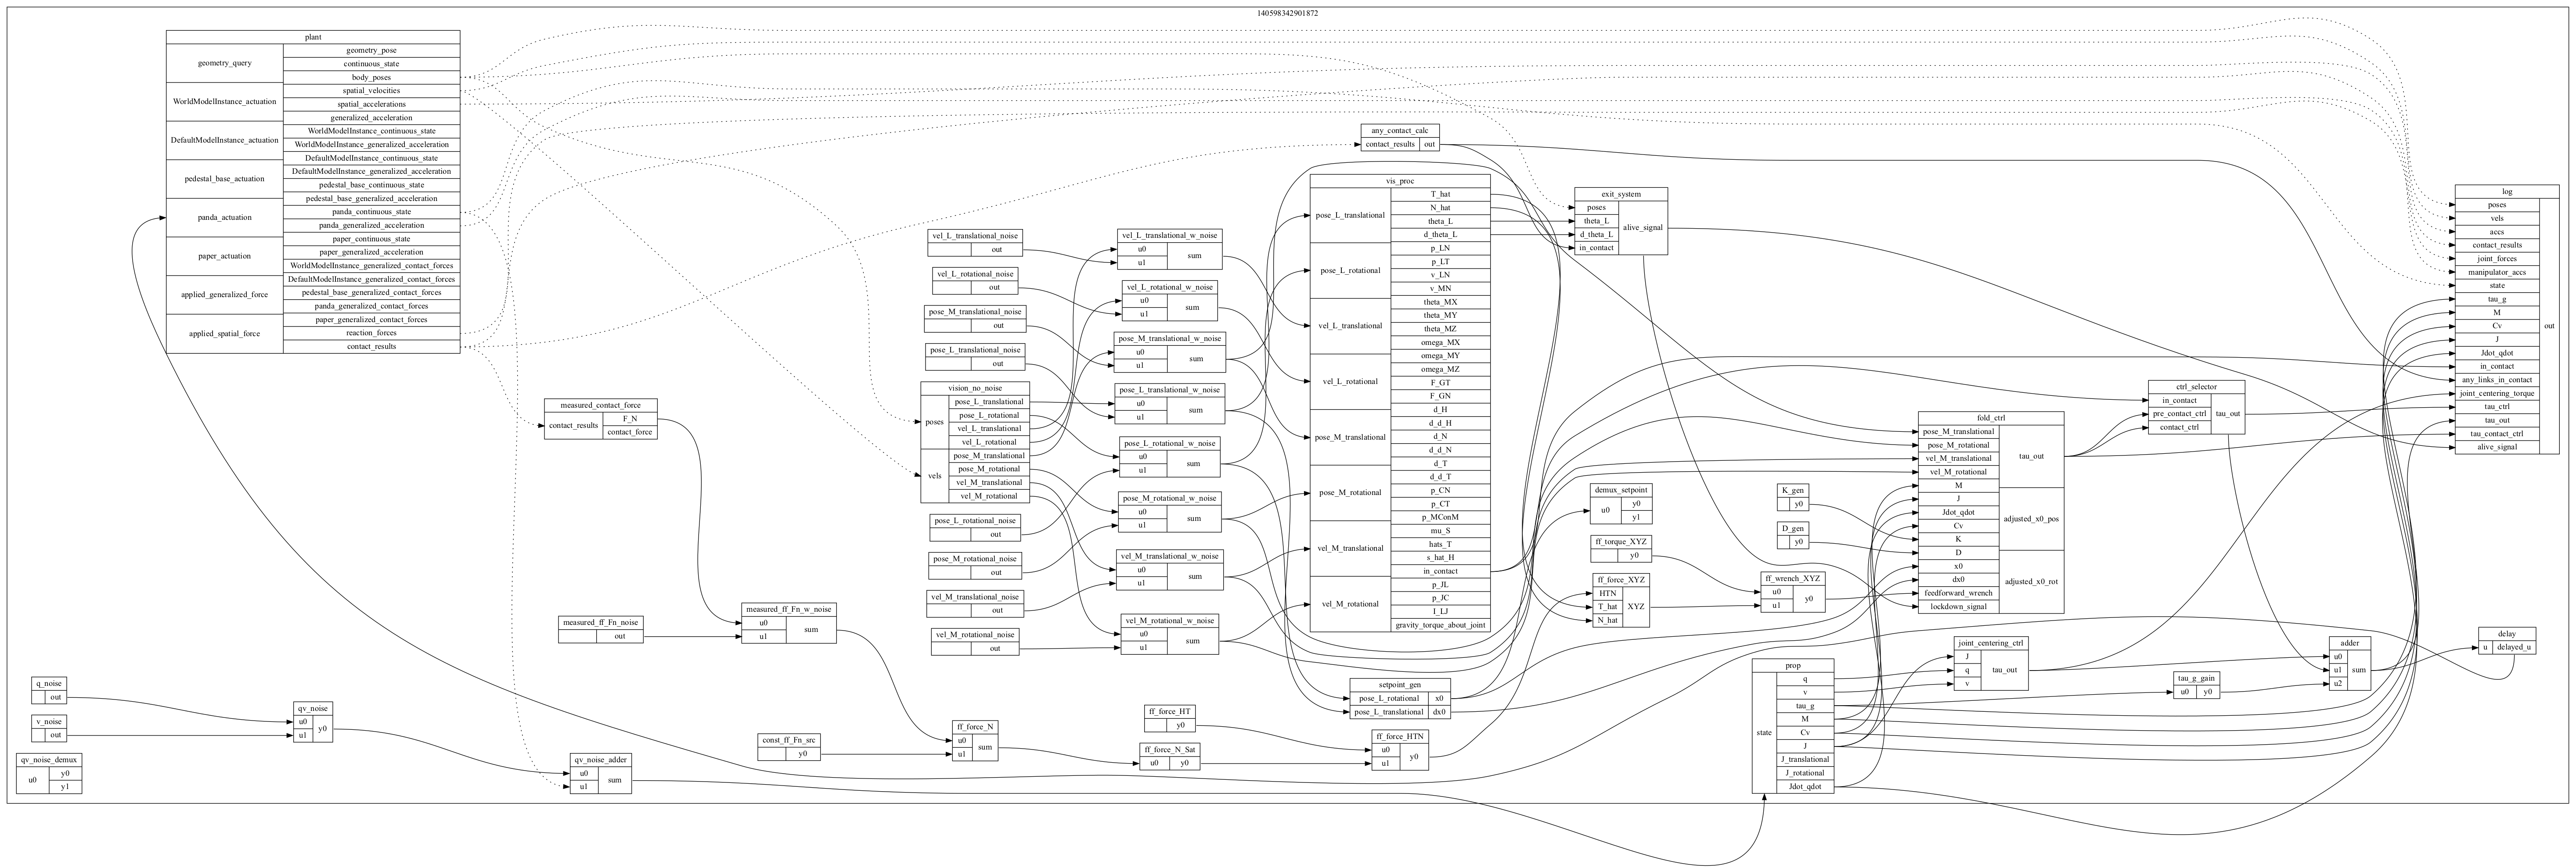

In [8]:
Image(pydot.graph_from_dot_data(sim.get_viz_str())[0].create_png())

# Run simulation

In [9]:
t_start_ = time.time()
log = sim.run_sim()
print(time.time() - t_start_)

[CtrlSelector] Switching to contact ctrl at 1.00
<class 'sim_exceptions.SimStalled'>

1007.9136431217194


In [10]:
# This way, we can use the actual time the simulation ran for
effective_tspan = max(log.sample_times())
print("effective_tspan:", effective_tspan)

effective_tspan: 15.953000000000001


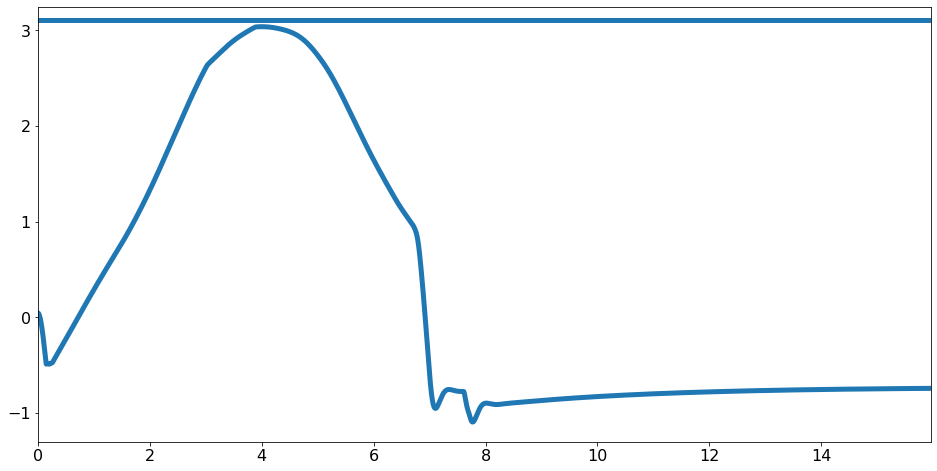

In [11]:
plt.plot(sim.exit_system.overall_theta_times, sim.exit_system.overall_thetas)
plt.axhline(0.99*np.pi)
plt.show()

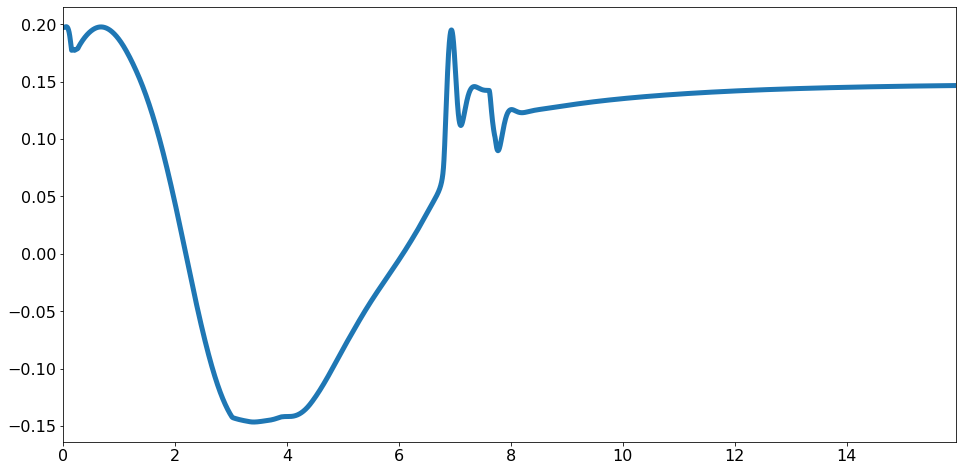

In [12]:
plt.plot(sim.exit_system.overall_theta_times, sim.exit_system.overall_thetas_xs)
plt.show()

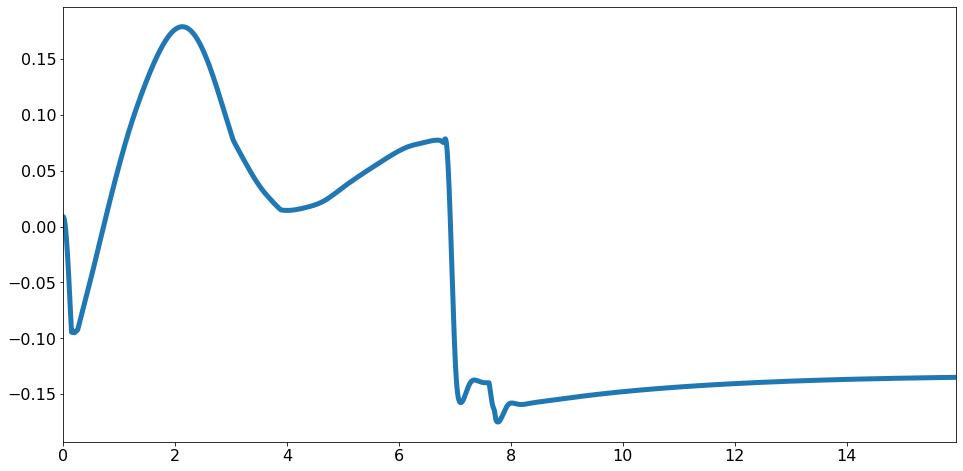

In [13]:
plt.plot(sim.exit_system.overall_theta_times, sim.exit_system.overall_thetas_ys)
plt.show()

# Define helper functions

In [14]:
# Friction helper functions
def step5(x):
    '''Python version of MultibodyPlant::StribeckModel::step5 method'''
    x3 = x * x * x
    return x3 * (10 + x * (6 * x - 15))

def stribeck(us, uk, v):
    '''
    Python version of MultibodyPlant::StribeckModel::ComputeFrictionCoefficient
    
    From
    https://github.com/RobotLocomotion/drake/blob/b09e40db4b1c01232b22f7705fb98aa99ef91f87/multibody/plant/images/stiction.py
    '''
    u = np.zeros_like(v) + uk
    u[v < 1] = us * step5(v[v < 1])
    mask = (v >= 1) & (v < 3)
    u[mask] = us - (us - uk) * step5((v[mask] - 1) / 2)
    return u

In [15]:
def T(vec):
    return np.transpose(vec, [0, 2, 1])

## `diff` functions

In [16]:
def diff_vec(vec):
    d_vec = np.diff(vec, axis=0)
    for i in range(vec.shape[1]):
        d_vec[:, i] /= np.expand_dims(np.diff(l_times), 1)
    d_vec = np.concatenate((d_vec, [d_vec[-1]]))
    return d_vec

In [17]:
def diff_arr(arr):
    d_arr = np.diff(arr)/np.diff(l_times)
    d_arr = np.concatenate((d_arr, [d_arr[-1]]))
    return d_arr

In [18]:
def diff_mat(mat):
    d_mat = np.diff(mat, axis=0)
    for i in range(mat.shape[1]):
        for j in range(mat.shape[2]):
            d_mat[:, i, j] /= np.diff(l_times)
    d_mat = np.concatenate((d_mat, [d_mat[-1]]))
    return d_mat

## `plot` functions

In [19]:
def plot_components(sig, finish_plotting=True):
    plt.figure()
    plt.plot(l_times, sig[:,0], color='r')
    plt.plot(l_times, sig[:,1], color='g')
    plt.plot(l_times, sig[:,2], color='b')
    if finish_plotting:
        plt.show()

In [20]:
def plot_vec(sig1, sig1_label, sig2, sig2_label, finish_plotting=True, start_time=None,
             plot_error=False, create_fig=True):
    if start_time is None:
        idx_start_ = idx_start
    else:
        idx_start_ = np.argmax(l_times > start_time)
    if create_fig:
        plt.figure(figsize=(16, 8))
    lw = 5
    
    if plot_error:
        plt.subplot(2,1,1)
        plt.plot(l_times[idx_start_:idx_end], (sig1 - sig2)[:,0][idx_start_:idx_end], label=r' $\hat x$ error', color='r', linewidth=lw, alpha=0.5)
        plt.plot(l_times[idx_start_:idx_end], (sig1 - sig2)[:,1][idx_start_:idx_end], label=r' $\hat y$ error', color='g', linewidth=lw, alpha=0.5)
        plt.plot(l_times[idx_start_:idx_end], (sig1 - sig2)[:,2][idx_start_:idx_end], label=r' $\hat z$ error', color='b', linewidth=lw, alpha=0.5)
        plt.xlabel("Time (seconds)")
        plt.legend()
        plt.autoscale(enable=True, axis='x', tight=True)
        plt.subplot(2,1,2)
    
    plt.plot(l_times[idx_start_:idx_end], sig1[:,0][idx_start_:idx_end], label=sig1_label + r' $\hat x$ component', color='pink', linewidth=lw)
    plt.plot(l_times[idx_start_:idx_end], sig1[:,1][idx_start_:idx_end], label=sig1_label + r' $\hat y$ component', color='lightgreen', linewidth=lw)
    plt.plot(l_times[idx_start_:idx_end], sig1[:,2][idx_start_:idx_end], label=sig1_label + r' $\hat z$ component', color='lightskyblue', linewidth=lw)
    
    plt.plot(l_times[idx_start_:idx_end], sig2[:,0][idx_start_:idx_end], label=sig2_label + r' $\hat x$ component', color='red', linewidth=lw, linestyle='--')
    plt.plot(l_times[idx_start_:idx_end], sig2[:,1][idx_start_:idx_end], label=sig2_label + r' $\hat y$ component', color='green', linewidth=lw, linestyle='--')
    plt.plot(l_times[idx_start_:idx_end], sig2[:,2][idx_start_:idx_end], label=sig2_label + r' $\hat z$ component', color='blue', linewidth=lw, linestyle='--')
    plt.xlabel("Time (seconds)")
    plt.legend()
    plt.autoscale(enable=True, axis='x', tight=True)
    if finish_plotting:
        plt.show()

In [21]:
def plot_vec_HTN(sig1, sig1_label, sig2, sig2_label, finish_plotting=True, start_time=None,
                 plot_error=False, create_fig=True):
    if start_time is None:
        idx_start_ = idx_start
    else:
        idx_start_ = np.argmax(l_times > start_time)
    if create_fig:
        plt.figure(figsize=(16, 8))
    lw = 5
    
    T_proj1 = np.matmul(T(sig1), T_hat).flatten()
    T_proj2 = np.matmul(T(sig2), T_hat).flatten()
    N_proj1 = np.matmul(T(sig1), N_hat).flatten()
    N_proj2 = np.matmul(T(sig2), N_hat).flatten()
    
    if plot_error:
        plt.subplot(2,1,1)
        plt.plot(l_times[idx_start_:idx_end], (T_proj1 - T_proj2)[idx_start_:idx_end], label=r' $\hat H$ error', color='r', linewidth=lw, alpha=0.5)
        plt.plot(l_times[idx_start_:idx_end], (sig1 - sig2)[:,hinge_rotation_axis][idx_start_:idx_end], label=r' $\hat T$ error', color='g', linewidth=lw, alpha=0.5)
        plt.plot(l_times[idx_start_:idx_end], (N_proj2 - N_proj2)[idx_start_:idx_end], label=r' $\hat N$ error', color='b', linewidth=lw, alpha=0.5)
        plt.xlabel("Time (seconds)")
        plt.legend()
        plt.autoscale(enable=True, axis='x', tight=True)
        plt.subplot(2,1,2)
    
    plt.plot(l_times[idx_start_:idx_end], sig1[:,hinge_rotation_axis][idx_start_:idx_end], label=sig1_label + r' $\hat H$ component', color='pink', linewidth=lw)
    plt.plot(l_times[idx_start_:idx_end], T_proj1[idx_start_:idx_end], label=sig1_label + r' $\hat T$ component', color='lightgreen', linewidth=lw)
    plt.plot(l_times[idx_start_:idx_end], N_proj1[idx_start_:idx_end], label=sig1_label + r' $\hat N$ component', color='lightskyblue', linewidth=lw)
    
    plt.plot(l_times[idx_start_:idx_end], sig2[:,hinge_rotation_axis][idx_start_:idx_end], label=sig2_label + r' $\hat H$ component', color='red', linewidth=lw, linestyle='--')
    plt.plot(l_times[idx_start_:idx_end], T_proj2[idx_start_:idx_end], label=sig2_label + r' $\hat T$ component', color='green', linewidth=lw, linestyle='--')
    plt.plot(l_times[idx_start_:idx_end], N_proj2[idx_start_:idx_end], label=sig2_label + r' $\hat N$ component', color='blue', linewidth=lw, linestyle='--')
    plt.xlabel("Time (seconds)")
    plt.legend()
    plt.autoscale(enable=True, axis='x', tight=True)
    if finish_plotting:
        plt.show()

In [22]:
def plot_eq(lhs, lhs_label, rhs, rhs_label, lhs_alpha=1, rhs_alpha=1, lw=5, finish_plotting=True, 
            plot_diff=True, figsize_=None, plot_err_as_pct=False, t_start_=None, newline_in_title=False,
            t_end_=None, create_fig=True):
    # Can't set these to be default params because I don't want to have to define t_start
    # before this function is defined
    if t_start_ is None:
        t_start_ = t_start
    if t_end_ is None:
        t_end_ = t_end

    if create_fig:
        if figsize_ is not None:
            plt.figure(figsize=figsize_)
        else:
            plt.figure(figsize=default_figsize)
    if isinstance(lhs, float) or isinstance(lhs, int):
        lhs = np.ones_like(l_times)*lhs
    if isinstance(rhs, float) or isinstance(rhs, int):
        rhs = np.ones_like(l_times)*rhs
    idx_start = np.argmax(l_times > t_start_)
    idx_end = np.argmax(l_times > t_end_)
    if idx_end == 0:
        idx_end = len(l_times) - 1
        
    b = np.broadcast(lhs, rhs)
    if np.count_nonzero(np.array(b.shape) > 1000) > 1:
        raise ValueError("Broadcast shape of lhs and rhs is {}, which is too large.".format(b.shape))
        
    if plot_diff:
        plt.subplot(211)
        error = lhs[idx_start:idx_end]-rhs[idx_start:idx_end]
        if plot_err_as_pct:
            lhs_range = np.nanmax(lhs[idx_start:idx_end]) - np.nanmin(lhs[idx_start:idx_end])
            rhs_range = np.nanmax(rhs[idx_start:idx_end]) - np.nanmin(rhs[idx_start:idx_end])

            lhs_max_val = np.nanmax(np.abs(lhs[idx_start:idx_end]))
            rhs_max_val = np.nanmax(np.abs(rhs[idx_start:idx_end]))
            error /= np.nanmax([lhs_max_val, rhs_max_val])
            error *= 100

        plt.plot(l_times[idx_start:idx_end],
                error,
                linewidth=lw)
        plt.autoscale(enable=True, axis='x', tight=True)
        plt.xlabel("Time (s)")
        if plot_err_as_pct:
            plt.ylabel("Error (percent of max val)")
        else:
            plt.ylabel("Error")
        if newline_in_title:
            plt.title("Difference between {}\n and {}".format(lhs_label, rhs_label))
        else:
            plt.title("Difference between {} and {}".format(lhs_label, rhs_label))


        plt.subplot(212)
    plt.plot(l_times[idx_start:idx_end],
             lhs[idx_start:idx_end],
             label=lhs_label, linewidth=lw, color='lightskyblue', zorder=0, alpha=lhs_alpha)
    plt.plot(l_times[idx_start:idx_end],
             rhs[idx_start:idx_end],
             label=rhs_label, linewidth=lw, color='b', linestyle='--', zorder=1, alpha=rhs_alpha)
    plt.autoscale(enable=True, axis='x', tight=True)
    
#     plt.axvline(t[np.argmax(in_contact)] + 0.5, color='k', linewidth=lw, linestyle='--')
    
    
#     plt.axvline(t[first_contact_idx], color='green', linewidth=lw)
#     plt.axvline(t_lose_contact, color='red', linewidth=lw)
    
    plt.legend()
    plt.xlabel("Time (s)")
    
    if finish_plotting:
        plt.show()

# Load signals

## Load times and `debug` dict

In [23]:
if hasattr(sim.fold_ctrl, "debug"):
    debug = sim.fold_ctrl.debug
    
    min_key_length = np.inf
    for k in debug.keys():
        if len(debug[k]) > 0 and len(debug[k]) < min_key_length:
            print(k)
            min_key_length = len(debug[k])
    for k in debug.keys():
        debug[k] = debug[k][:min_key_length]

    d_times = np.array(debug['times'])
else:
    debug = None

dx0


In [24]:
l_times = log.sample_times()

## Inputs
These should all come from simulation/geometry, since they are inputs to the controller and are "fixed" from the controller's perspective.

In [25]:
nq = manipulator.data['nq']

### Geometric quantities ($m_L, m_M, w_L, I_L, h_L, \mu$)

In [26]:
m_L = sim.sim_sys_consts.m_L
m_M = sim.sim_sys_consts.m_M
w_L = sim.sim_sys_consts.w_L
I_L = sim.sim_sys_consts.I_L
h_L = sim.sim_sys_consts.h_L
# mu = 2*mu_paper/(1+mu_paper) # 2μₘμₙ/(μₘ + μₙ)
mu = sim.sim_sys_consts.mu
b_J = sim.sim_sys_consts.b_J
k_J = sim.sim_sys_consts.k_J

### Gravity, unit vectors ($F_{GT}, F_{GN}, \hat T, \hat N$)

In [27]:
# Assume plane contact, so all N_hat should point the same direction
# TODO: verify all point in the same direction
N_hat_raw = log.data()[sim.log_wrapper.contact_entry_start_idx+14:sim.log_wrapper.contact_entry_start_idx+17,:].copy() # So it's writeable
N_hat = np.expand_dims(N_hat_raw.T, 2)
N_hat[:,0][np.isnan(N_hat[:,0])] = 0
N_hat[:,1][np.isnan(N_hat[:,1])] = 0
N_hat[:,2][np.isnan(N_hat[:,2])] = 1

In [28]:
H_hat = np.zeros_like(N_hat)
H_hat[:,hinge_rotation_axis] = 1

In [29]:
# T hat can be defined by rotating N hat about hinge axis by -90 degrees
rot = RotationMatrix(AngleAxis(axis=H_hat[0].flatten(), angle=-np.pi/2)).matrix()

T_hat = np.matmul(rot, N_hat)

It's also useful here to calculate project matrices:

In [30]:
N_hat_proj_mat = np.matmul(N_hat, np.transpose(N_hat, [0, 2, 1]))

In [31]:
g = sim.plant.gravity_field().gravity_vector()[-1]*-1
F_G = np.zeros([l_times.size, 3, 1])
F_G[:,2,0] = -np.ones_like(l_times)*g*m_L
F_GT = np.matmul(T(F_G), T_hat).flatten()
F_GN = np.matmul(T(F_G), N_hat).flatten()

In [32]:
g = sim.plant.gravity_field().gravity_vector()[-1]*-1
F_GM = np.zeros([l_times.size, 3, 1])
F_GM[:,2,0] = -np.ones_like(l_times)*g*m_M
F_GMT = np.matmul(T(F_GM), T_hat).flatten()
F_GMN = np.matmul(T(F_GM), N_hat).flatten()

In [33]:
idx = sim.log_wrapper.tau_g_start_idx
length = manipulator.data["nq"]
tau_g = np.expand_dims(log.data()[idx:idx+length].T, 2)

### Positions, velocities ($\dot\theta^2, r_T, \dot d_T$)

#### Object poses & vels

##### Link

Position:

In [34]:
idx = sim.log_wrapper.get_idx("pos", "trn", sim.ll_idx)
length = 3
p_L = np.expand_dims(log.data()[idx:idx+length].T, 2)
p_LN = np.matmul(T(p_L), N_hat).flatten()
p_LT = np.matmul(T(p_L), T_hat).flatten()
p_LH = p_L[:,hinge_rotation_axis].flatten()

In [35]:
idx = sim.log_wrapper.get_idx("pos", "rot", sim.ll_idx)
length = 3
rot_vec_L = np.expand_dims(log.data()[idx:idx+length].T, 2)

In [36]:
theta_LX = log.data()[sim.log_wrapper.get_idx("pos", "rot", sim.ll_idx)]
theta_LY = log.data()[sim.log_wrapper.get_idx("pos", "rot", sim.ll_idx)+1]
theta_LZ = log.data()[sim.log_wrapper.get_idx("pos", "rot", sim.ll_idx)+2]

In [37]:
theta_L = log.data()[sim.log_wrapper.get_idx("pos", "rot", sim.ll_idx) + hinge_rotation_axis].copy()
# Fix issue in RPY singularity
theta_L[theta_LZ > np.pi/2] = theta_L[theta_LZ > np.pi/2]*-1 + np.pi

Velocity:

In [38]:
idx = sim.log_wrapper.get_idx("vel", "trn", sim.ll_idx)
length = 3
v_L = np.expand_dims(log.data()[idx:idx+length].T,2)
v_LN = np.matmul(T(v_L), N_hat).flatten()
v_LT = np.matmul(T(v_L), T_hat).flatten()
v_LH = v_L[:,hinge_rotation_axis].flatten()

In [39]:
d_theta_L = log.data()[sim.log_wrapper.get_idx("vel", "rot", sim.ll_idx) + hinge_rotation_axis]

In [40]:
idx = sim.log_wrapper.get_idx("vel", "rot", sim.ll_idx)
length = 3
omega_vec_L = np.expand_dims(log.data()[idx:idx+length].T, 2)

##### Manipulator

Position:

In [41]:
idx = sim.log_wrapper.get_idx("pos", "trn", sim.contact_body_idx)
length = 3
p_M = np.expand_dims(log.data()[idx:idx+length].T, 2)
p_MN = np.matmul(T(p_M), N_hat).flatten()
p_MT = np.matmul(T(p_M), T_hat).flatten()
p_MH = p_M[:,hinge_rotation_axis].flatten()

In [42]:
idx = sim.log_wrapper.get_idx("pos", "rot", sim.contact_body_idx)
length = 3
rot_vec_M = np.expand_dims(log.data()[idx:idx+length].T, 2)

In [43]:
theta_MX = log.data()[sim.log_wrapper.get_idx("pos", "rot", sim.contact_body_idx)]
theta_MY = log.data()[sim.log_wrapper.get_idx("pos", "rot", sim.contact_body_idx)+1]
theta_MZ = log.data()[sim.log_wrapper.get_idx("pos", "rot", sim.contact_body_idx)+2]

Velocity:

In [44]:
idx = sim.log_wrapper.get_idx("vel", "trn", sim.contact_body_idx)
length = 3
v_M = np.expand_dims(log.data()[idx:idx+length].T, 2)
v_MN = np.matmul(T(v_M), N_hat).flatten()
v_MT = np.matmul(T(v_M), T_hat).flatten()
v_MH = v_M[:,hinge_rotation_axis].flatten()

In [45]:
idx = sim.log_wrapper.get_idx("vel", "rot", sim.contact_body_idx)
length = 3
omega_vec_M = np.expand_dims(log.data()[idx:idx+length].T, 2)

In [46]:
omega_MX = omega_vec_M[:,0].flatten()
omega_MY = omega_vec_M[:,1].flatten()
omega_MZ = omega_vec_M[:,2].flatten()

Roll, pitch, and yaw rates:

In [47]:
d_theta_MX = diff_arr(theta_MX)
d_theta_MY = diff_arr(theta_MY)
d_theta_MZ = diff_arr(theta_MZ)

##### Other terms

In [48]:
x_hat = np.zeros((len(l_times), 3, 1))
x_hat[:,0,:] = 1

y_hat = np.zeros((len(l_times), 3, 1))
y_hat[:,1,:] = 1

z_hat = np.zeros((len(l_times), 3, 1))
z_hat[:,2,:] = 1

#### Manipulator eq. terms

In [49]:
idx = sim.log_wrapper.J_start_idx
length = manipulator.data["nq"]*6
J = np.transpose(log.data()[idx:idx+length].reshape(6, nq, len(l_times)), [2, 0, 1])
J_rotational = J[:,:3,:]
J_translational = J[:,3:,:]

In [50]:
idx = sim.log_wrapper.joint_centering_torque_start_idx
length = manipulator.data["nq"]
joint_centering_torque = np.expand_dims(np.transpose(log.data()[idx:idx+length]), 2)

In [51]:
q = np.expand_dims((log.data()[sim.log_wrapper.state_start_idx:sim.log_wrapper.state_start_idx + nq,:]).T, 2)
d_q = np.expand_dims((log.data()[sim.log_wrapper.state_start_idx + nq:sim.log_wrapper.state_start_idx + nq*2,:]).T, 2)

In [52]:
idx = sim.log_wrapper.M_start_idx
length = manipulator.data["nq"]*manipulator.data["nq"]
M = np.transpose(log.data()[idx:idx+length].reshape(nq, nq, len(l_times)), [2, 0, 1])

In [53]:
idx = sim.log_wrapper.Cv_start_idx
length = manipulator.data["nq"]
Cv = np.expand_dims(log.data()[idx:idx+length].T, 2)

In [54]:
idx = sim.log_wrapper.Jdot_qdot_start_idx
length = 6
Jdot_qdot = np.expand_dims(log.data()[idx:idx+length].T, 2)

#### Body derived terms
Meaning terms derived from the positions/velocities of bodies

In [55]:
R = np.zeros((len(l_times), 3, 3))
R[:,1,1] = np.cos(theta_L)
R[:,1,2] = -np.sin(theta_L)
R[:,2,1] = np.sin(theta_L)
R[:,2,2] = np.cos(theta_L)

In [56]:
T_hat_geo = np.matmul(R, y_hat)
N_hat_geo = np.matmul(R, z_hat)

In [57]:
# Link edge
p_LE = p_L + (w_L/2)*T_hat-(h_L/2)*N_hat

In [58]:
J_dot = diff_vec(J)

#### Contact terms
TODO: edit out/simplify eventually

In [59]:
contact_point = log.data()[sim.log_wrapper.contact_entry_start_idx+11:sim.log_wrapper.contact_entry_start_idx+14,:]

In [60]:
p_C = np.expand_dims(contact_point.T, 2)
p_CT = np.matmul(T(p_C), T_hat).flatten()
p_CN = np.matmul(T(p_C), N_hat).flatten()

In [61]:
r = np.linalg.norm(p_C - p_M, axis=1).flatten()

In [62]:
# Assume all the slip speeds are the same
# TODO: verify
slip_speed = log.data()[sim.log_wrapper.contact_entry_start_idx+10,:]

In [63]:
# d vector
d_vec = p_C - p_LE
d_T = np.matmul(T(d_vec), T_hat).flatten()
d_N = np.matmul(T(d_vec), N_hat).flatten()
d_H = d_vec[:,hinge_rotation_axis].flatten()

In [64]:
d_d_T = -d_theta_L*h_L/2-d_theta_L*r - v_LT + v_MT + d_theta_L*d_N
d_d_N = -d_theta_L*w_L/2-v_LN+v_MN-d_theta_L*d_T
d_d_H = diff_arr(d_H)

In [65]:
dd_d_T = diff_arr(d_d_T)
dd_d_N = diff_arr(d_d_N)
dd_d_H = diff_arr(d_d_H)

In [66]:
d_d_vec = diff_vec(d_vec)
d_d_vec_T = np.matmul(T(d_d_vec), T_hat).flatten()
d_d_vec_N = np.matmul(T(d_d_vec), N_hat).flatten()

In [67]:
p_MConM = p_C - p_M
p_LConL = p_C - p_L

v_WConM = v_M + np.cross(omega_vec_M, p_MConM, axis=1)
v_WConL = v_L + np.cross(omega_vec_L, p_LConL, axis=1)

v_S_raw = v_WConM - v_WConL
v_S_N = np.matmul(N_hat_proj_mat, v_S_raw)
v_S = v_S_raw - v_S_N
s_S = np.linalg.norm(v_S, axis=1).flatten()

In [68]:
s_hat = v_S/np.expand_dims(np.linalg.norm(v_S, axis=1), 2)
s_hat_H = s_hat[:,hinge_rotation_axis].flatten()
s_hat_T = np.matmul(T(s_hat), T_hat).flatten()

In [69]:
d_d_T_diff = diff_arr(d_T)
d_d_N_diff = diff_arr(d_N)

### Friction coefficients

In [70]:
mu_S = stribeck(1, 1, s_S/constants.v_stiction)

## Outputs
These should all come directly from simulation, except for control forces.
### Measured accelerations ($a_{LT}, a_{LN}, a_{MT}, a_{MN}, \ddot\theta$)

In [71]:
idx = sim.log_wrapper.get_idx("acc", "trn", sim.ll_idx)
length = 3
a_L = np.expand_dims(log.data()[idx:idx+length].T, 2)
a_LH = np.matmul(T(a_L), H_hat).flatten()
a_LT = np.matmul(T(a_L), T_hat).flatten()
a_LN = np.matmul(T(a_L), N_hat).flatten()

In [72]:
idx = sim.log_wrapper.get_idx("acc", "trn", sim.contact_body_idx)
length = 3
a_M = np.expand_dims(log.data()[idx:idx+length].T, 2)
a_MH = np.matmul(T(a_M), H_hat).flatten()
a_MT = np.matmul(T(a_M), T_hat).flatten()
a_MN = np.matmul(T(a_M), N_hat).flatten()
a_MX = a_M[:,0].flatten()
a_MY = a_M[:,1].flatten()
a_MZ = a_M[:,2].flatten()

In [73]:
idx = sim.log_wrapper.get_idx("acc", "rot", sim.contact_body_idx)
length = 3
alpha_M = np.expand_dims(log.data()[idx:idx+length].T, 2)
alpha_MT = np.matmul(T(alpha_M), T_hat).flatten()
alpha_MN = np.matmul(T(alpha_M), N_hat).flatten()
alpha_MX = alpha_M[:,0].flatten()
alpha_MY = alpha_M[:,1].flatten()
alpha_MZ = alpha_M[:,2].flatten()

In [74]:
dd_theta_L = log.data()[sim.log_wrapper.get_idx("acc", "rot", sim.ll_idx) + hinge_rotation_axis]
dd_theta_M = log.data()[sim.log_wrapper.get_idx("acc", "rot", sim.contact_body_idx)]

In [75]:
dd_q = np.expand_dims((log.data()[sim.log_wrapper.gen_accs_start_idx:
                                     sim.log_wrapper.gen_accs_start_idx+nq,:]).T, 2)

### Contact forces ($F_{NL}, F_{FL}, F_{NM}, F_{FM}$)
Slightly different then just taking normal/tangent projections.

In [76]:
F_NM = np.zeros(len(l_times))
F_FMT = np.zeros(len(l_times))
F_FMH = np.zeros(len(l_times))
F_ContactM_XYZ = np.zeros((len(l_times), 3, 1))
tau_contact = np.zeros((len(l_times), nq, 1))
total_force = np.zeros((len(l_times), 3, 1))
total_friction = np.zeros((len(l_times)))
total_friction_H = np.zeros((len(l_times)))
total_friction_T = np.zeros((len(l_times)))
total_normal = np.zeros((len(l_times)))

total_normals = []
total_frictions = []
for i in range(sim.log_wrapper.max_contacts):
    # Pull out terms
    start_idx = sim.log_wrapper.contact_entry_start_idx + sim.log_wrapper.entries_per_contact*i
    contact_point = np.expand_dims(log.data()[start_idx+11:start_idx+14,:].T, 2)
    if np.all(np.isnan(contact_point)):
        break

    # Calculate intermediates
    lever_arm = contact_point - p_M
    force = np.expand_dims(log.data()[start_idx+0:start_idx+3,:].T, 2)

    total_force_ = np.expand_dims(log.data()[start_idx+0:start_idx+3,:].T, 2)
    n_hat = np.expand_dims(log.data()[start_idx+14:start_idx+17,:].T, 2)

    total_force += total_force_

    n_hat_proj_matrix = np.matmul(n_hat, np.transpose(n_hat, [0,2,1]))
    total_normal_vec = np.matmul(n_hat_proj_matrix, total_force_)
    total_normal_mag = np.linalg.norm(total_normal_vec, axis=1).flatten()
    total_friction_ = total_force_ - total_normal_vec
    total_friction_H_ = np.expand_dims((total_force_ - total_normal_vec)[:,hinge_rotation_axis,:], 2)
    total_friction_T_ = (total_force_ - total_normal_vec - total_friction_H_)
    total_normal += total_normal_mag
    total_friction_mag = np.linalg.norm(total_friction_, axis=1).flatten()
    total_friction += total_friction_mag
    total_friction_H += np.linalg.norm(total_friction_H_, axis=1).flatten()
    total_friction_T += np.linalg.norm(total_friction_T_, axis=1).flatten()
    total_normals.append(total_normal_mag)
    total_frictions.append(total_friction_mag)

    torque = np.cross(lever_arm, force, axis=1)
    wrench = np.hstack((torque, force))
    
    # Calculate updates
    F_FMT_update = np.matmul(T(force), T_hat).flatten()
    F_NM_update = np.matmul(T(force), N_hat).flatten()
    F_FMH_update = force[:,hinge_rotation_axis].flatten()
    F_ContactM_XYZ_update = force
    
    # Update
    tau_contact += np.matmul(T(J), wrench)
    F_FMT += F_FMT_update
    F_NM += F_NM_update
    F_FMH += F_FMH_update
    F_ContactM_XYZ += F_ContactM_XYZ_update
    
F_NM = np.nan_to_num(F_NM)
F_FMT = np.nan_to_num(F_FMT)
F_FMH = np.nan_to_num(F_FMH)
tau_contact = np.nan_to_num(tau_contact)
F_ContactM_XYZ = np.nan_to_num(F_ContactM_XYZ)

#### Friction plot sanity checks

In [77]:
# fig, axs = plt.subplots(
#     len(total_normals), 1, figsize=(12,10), constrained_layout=True,sharex=True,sharey=True)
# for Fn, Ff, ax in zip(total_normals, total_frictions, axs):
#     ax.plot(l_times, Fn*mu, 'c', label="Normal")
#     ax.plot(l_times, Ff, '--b', label="Friction")

In [78]:
# fig, axs = plt.subplots(
#     len(total_normals), 1, figsize=(12,10), constrained_layout=True,sharex=True,sharey=True)
# for Fn, Ff, ax in zip(total_normals, total_frictions, axs):
#     ax.plot(l_times, Ff/(Fn*mu))

In [79]:
F_FLT = -F_FMT
F_FLH = -F_FMH
F_NL = -F_NM

In [80]:
# Equivalent contact forces for each object
F_contact_M = np.expand_dims(F_FMH, [1, 2])*H_hat + \
                  np.expand_dims(F_FMT, [1, 2])*T_hat + \
                  np.expand_dims(F_NM, [1, 2])*N_hat

In [81]:
F_ContactMX = F_contact_M[:,0].flatten()
F_ContactMY = F_contact_M[:,1].flatten()
F_ContactMZ = F_contact_M[:,2].flatten()

In [82]:
F_contact_L = np.expand_dims(F_FLH, [1, 2])*H_hat + \
              np.expand_dims(F_FLT, [1, 2])*T_hat + \
              np.expand_dims(F_NL, [1, 2])*N_hat

### Object forces ($F_{ON}, F_{OT}, \tau_O$) and other joint terms

In [83]:
idx = sim.log_wrapper.get_last_jnt_idx("trn")
joint_force_in_compliance_frame = log.data()[idx:idx+3]

In [84]:
# Copy makes it mutable
# TODO: figure out how to make this more reliable
F_OH = joint_force_in_compliance_frame[1,:].copy()
F_OT = -joint_force_in_compliance_frame[0,:].copy() # X direction is opposite of T hat
F_ON = joint_force_in_compliance_frame[2,:].copy()

In [85]:
idx = sim.log_wrapper.get_last_jnt_idx("rot")
joint_torque_in_compliance_frame = log.data()[idx:idx+3]

In [86]:
# Copy makes it mutable
tau_O = joint_torque_in_compliance_frame[hinge_rotation_axis,:].copy()

In [87]:
F_OH = np.nan_to_num(F_OH)
F_OT = np.nan_to_num(F_OT)
F_ON = np.nan_to_num(F_ON)
tau_O = np.nan_to_num(tau_O)

In [88]:
# Get transform from link CoM to joint EXPRESSED IN LINK FRAME
X_LJ_L = sim.paper.joints[-1].frame_on_child().GetFixedPoseInBodyFrame()

p_JL = []
p_JC = []
p_WJ = []
rpy_WJ = []
for p_L_, p_C_, theta_LX_, theta_LY_, theta_LZ_ in zip(p_L, p_C, theta_LX, theta_LY, theta_LZ):
    # Construct transform of link CoM
    X_WL_ = RigidTransform(
        p=p_L_,
        rpy=RollPitchYaw(theta_LX_, theta_LY_, theta_LZ_)
    )
    
    # Get joint location EXPRESSED IN WORLD FRAME
    X_WJ = X_WL_.multiply(X_LJ_L)
    p_WJ.append(X_WJ.translation())
    rpy_WJ.append(RollPitchYaw(X_WJ.rotation()).vector())
    
    # Calculate lever arms for later torque math
    p_JL.append(p_L_.flatten() - X_WJ.translation())
    p_JC.append(p_C_.flatten() - X_WJ.translation())
p_JL = np.expand_dims(np.array(p_JL), 2)
p_JC = np.expand_dims(np.array(p_JC), 2)
p_WJ = np.expand_dims(np.array(p_WJ), 2)
rpy_WJ = np.expand_dims(np.array(rpy_WJ), 2)

In [89]:
theta_WJ = rpy_WJ[:,1].flatten()
d_theta_WJ = diff_arr(theta_WJ)
dd_theta_WJ = diff_arr(d_theta_WJ)

In [90]:
# Get inertia relative to joint of link, via parallel axis theorem
d_ = np.linalg.norm(p_JL, axis=1).flatten()
I_LJ = I_L + m_L*d_**2

In [91]:
contact_torque_about_joint = np.cross(p_JC, F_contact_L, axis=1)[:,hinge_rotation_axis].flatten()
gravity_torque_about_joint = np.cross(p_JL, F_G, axis=1)[:,hinge_rotation_axis].flatten()

## Control terms

In [92]:
idx = sim.log_wrapper.tau_ctrl_start_idx
length = manipulator.data["nq"]
tau_ctrl = np.expand_dims(np.transpose(log.data()[idx:idx+length]), 2)

In [93]:
idx = sim.log_wrapper.tau_out_start_idx
length = manipulator.data["nq"]
tau_out = np.expand_dims(np.transpose(log.data()[idx:idx+length]), 2)

In [94]:
idx = sim.log_wrapper.tau_contact_ctrl_idx
length = manipulator.data["nq"]
tau_contact_ctrl = np.expand_dims(np.transpose(log.data()[idx:idx+length]), 2)

In [95]:
F_out = np.matmul(J_translational, tau_out)
F_outN = np.matmul(T(F_out), N_hat).flatten()
F_outT = np.matmul(T(F_out), T_hat).flatten()
F_outH = F_out[:,hinge_rotation_axis].flatten()

## Other outputs

In [96]:
forces_found = log.data()[-1,:]

In [97]:
in_contact = log.data()[sim.log_wrapper.calc_in_contact_start_idx]

In [98]:
any_links_in_contact = log.data()[sim.log_wrapper.any_links_in_contact_idx]

In [99]:
t = l_times

In [100]:
idx = sim.log_wrapper.get_idx("pos", "trn", sim.paper.link_idxs[0])
length = 3
p_FL = np.expand_dims(log.data()[idx:idx+length].T, 2)

In [101]:
# Transform from first link to first joint, expressed in link fram
X_FL_FJ_L = sim.paper.joints[0].frame_on_parent().GetFixedPoseInBodyFrame()

In [102]:
# Transform from world to first joint
p_W_FJ = p_FL + np.expand_dims(X_FL_FJ_L.translation(), 1)

In [103]:
p_W_FJ[:,2]

array([[0.39686684],
       [0.39686684],
       [0.39686684],
       ...,
       [0.39686684],
       [0.39686684],
       [0.39686684]])

In [104]:
p_FL[:,2]

array([[0.39091371],
       [0.39091371],
       [0.39091371],
       ...,
       [0.39091371],
       [0.39091371],
       [0.39091371]])

# Set up plotting times

## Process contact times

These are all derived by contact, so we should first inspect the contact plot:

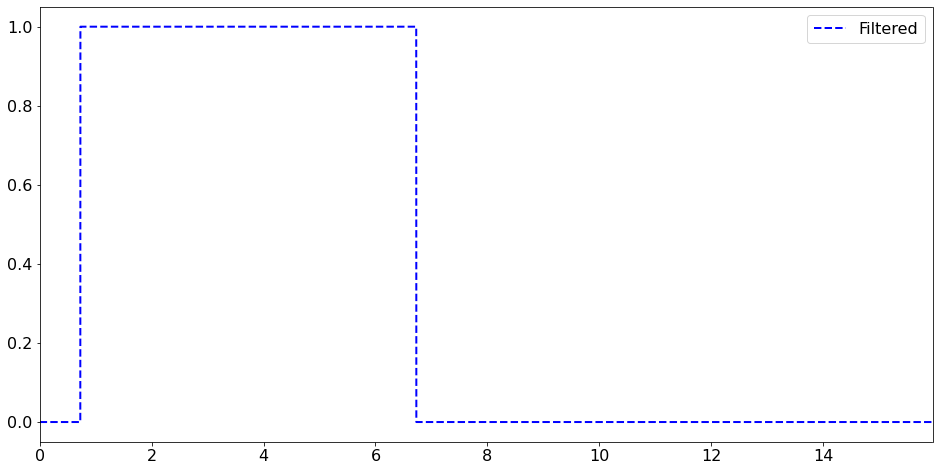

In [105]:
plt.plot(l_times, in_contact, "b--", linewidth=2, label="Filtered")
plt.legend()
plt.show()

Select what data should be use to select contact:

In [106]:
contact_data = in_contact

In [107]:
first_contact_idx = np.argmax(contact_data)
last_contact_idx = contact_data.size - np.argmax(contact_data[::-1]-1)-1
l_times[last_contact_idx]

6.728000000000001

In [108]:
last_not_in_contact_idx = contact_data.size - np.argmax(np.logical_not(contact_data[::-1])-1)-1
t_start_of_last_contact = t[min(last_not_in_contact_idx+1, len(l_times) - 1)]

## Select final `t_start` and `t_end`

In [109]:
# t_start = 0
t_start = t[first_contact_idx]

In [110]:
t_end = effective_tspan
# t_end = t[last_contact_idx]-0.5

In [111]:
idx_start = np.argmax(l_times > t_start)
idx_end = np.argmax(l_times > t_end)
if idx_end == 0:
    idx_end = len(l_times) - 1

# Plots (individual run)

## Verify controller input signals
This plot automatically compares all outputs of `vision_processer` with what we have already loaded into the workspace.

<Figure size 1152x576 with 0 Axes>

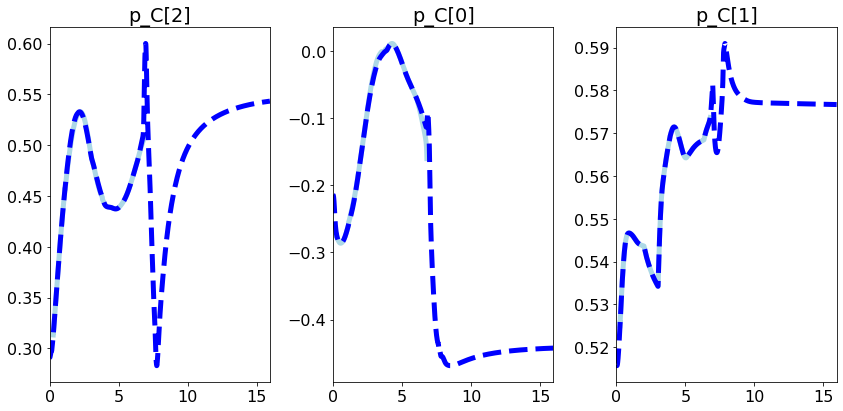

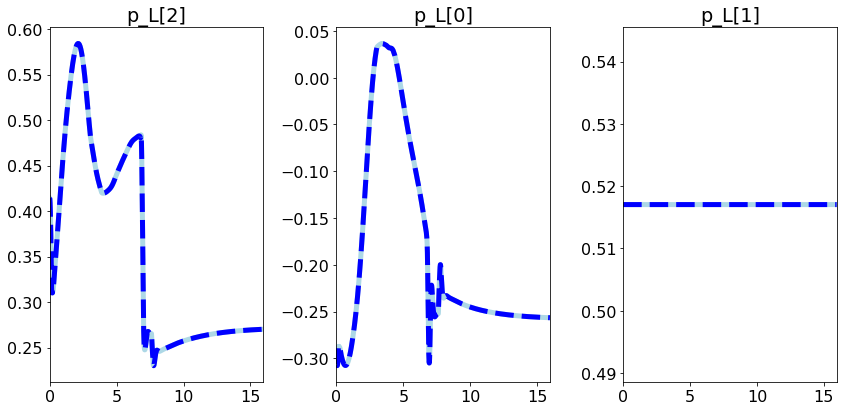

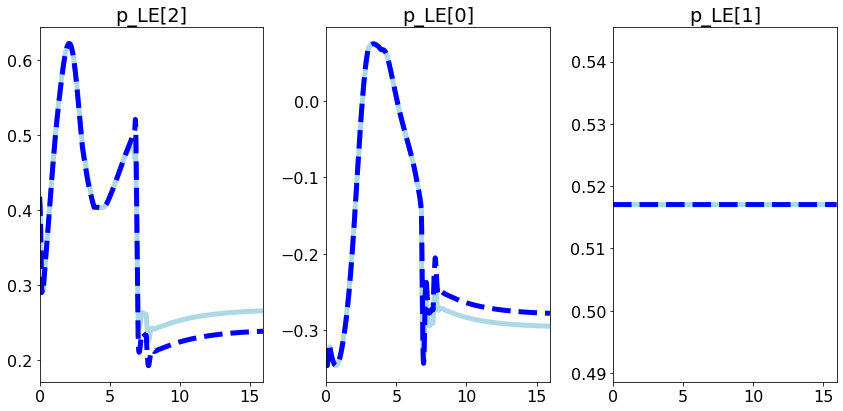

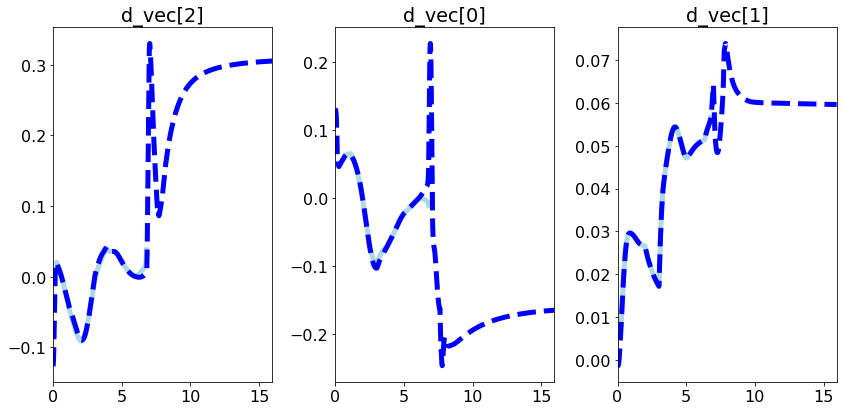

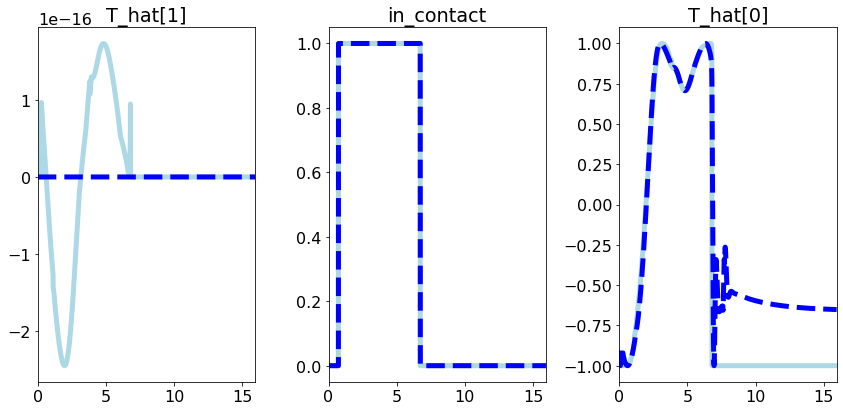

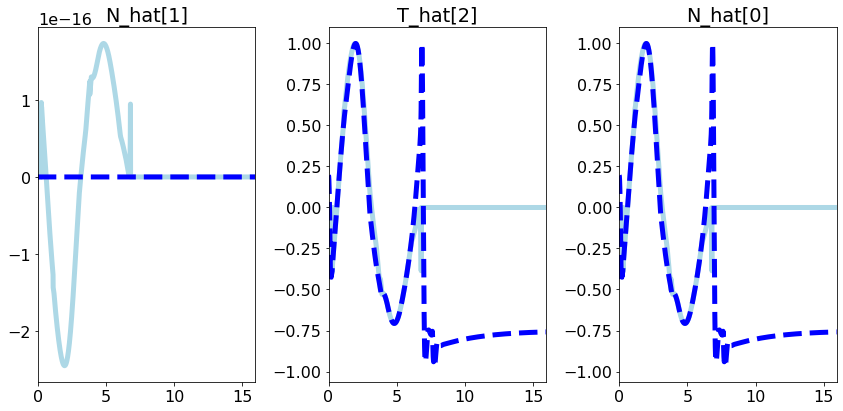

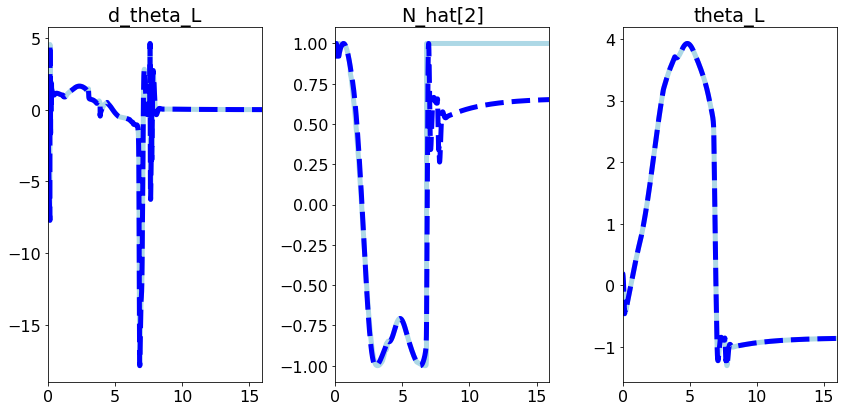

In [112]:
counter = 1
ignored_keys = {'t'}

# Get number of subplots
num_subplots = 0
for i, k in enumerate(sim.vision_processor.debug.keys()):
    if k in ignored_keys:
        continue
    if k.endswith('_t'):
        continue
    if len(locals()[k].shape) > 1:
        for i in range(locals()[k].shape[1]):
            num_subplots += 1
    else:
        num_subplots += 1

height_per_row = 6

for i, k in enumerate(sim.vision_processor.debug.keys()):
    if k in ignored_keys:
        continue
    if len(sim.vision_processor.debug[k]) == 0:
        continue
    if k.endswith('_t'):
        continue
    if len(locals()[k].shape) > 1:
        for i in range(locals()[k].shape[1]):
            if (counter%3) == 1:
                plt.tight_layout()
                plt.show()
                plt.figure(figsize=(12, height_per_row))
            plt.subplot(1, 3, (counter%3) + 1)
            counter += 1
            plt.title(k + '[' + str(i) + ']')
            plt.plot(l_times, locals()[k][:,i], color='lightblue')
            plt.plot(sim.vision_processor.debug[k + '_t'], np.array(sim.vision_processor.debug[k])[:,i], \
                     color='blue', linestyle='--')
    else:
        if (counter%3) == 1:
            plt.tight_layout()
            plt.show()
            plt.figure(figsize=(12, height_per_row))
        plt.subplot(1, 3, (counter%3) + 1)
        counter += 1
        plt.title(k)
        plt.plot(l_times, locals()[k], color='lightblue')
        plt.plot(sim.vision_processor.debug[k + '_t'], sim.vision_processor.debug[k], \
                 color='blue', linestyle='--')
plt.tight_layout()
plt.show()

## Inverse dynamics verification

### Load debug signals

In [113]:
if (ctrl_paradigm == plant.simulation.CtrlParadigm.INVERSE_DYNAMICS):
    debug_tau_contact = scipy.interpolate.interp1d(d_times, debug['tau_contact'], axis=0)(l_times)
    debug_a_MH = scipy.interpolate.interp1d(d_times, debug['a_MH'], axis=0)(l_times)
    debug_F_OT = scipy.interpolate.interp1d(d_times, debug['F_OT'], axis=0)(l_times)
    debug_F_ON = scipy.interpolate.interp1d(d_times, debug['F_ON'], axis=0)(l_times)
    debug_mu_S = scipy.interpolate.interp1d(d_times, debug['mu_S'], axis=0)(l_times)
    debug_mu = scipy.interpolate.interp1d(d_times, debug['mu'], axis=0)(l_times)
    debug_s_hat_T = scipy.interpolate.interp1d(d_times, debug['s_hat_T'], axis=0)(l_times)
    debug_gravity_torque_about_joint = scipy.interpolate.interp1d(
        d_times, debug['gravity_torque_about_joint'], axis=0)(l_times)
    debug_contact_torque_about_joint = scipy.interpolate.interp1d(
        d_times, debug['contact_torque_about_joint_out'], axis=0)(l_times)
    debug_F_NM = scipy.interpolate.interp1d(d_times, debug['F_NM'], axis=0)(l_times)
    debug_F_FMT = scipy.interpolate.interp1d(d_times, debug['F_FMT'], axis=0)(l_times).flatten()
    debug_F_FMH = scipy.interpolate.interp1d(d_times, debug['F_FMH'], axis=0)(l_times)
    debug_F_FMH = np.zeros_like(l_times)
    debug_F_ContactMX = scipy.interpolate.interp1d(d_times, debug['F_ContactMX'], axis=0)(l_times)
    debug_F_ContactMY = scipy.interpolate.interp1d(d_times, debug['F_ContactMY'], axis=0)(l_times)
    debug_F_ContactMZ = scipy.interpolate.interp1d(d_times, debug['F_ContactMZ'], axis=0)(l_times)
    debug_F_NL = scipy.interpolate.interp1d(d_times, debug['F_NL'], axis=0)(l_times)
    debug_F_FLT = scipy.interpolate.interp1d(d_times, debug['F_FLT'], axis=0)(l_times).flatten()
    debug_F_FLH = scipy.interpolate.interp1d(d_times, debug['F_FLH'], axis=0)(l_times)
    debug_F_FLH = np.zeros_like(l_times)
    debug_a_MX = scipy.interpolate.interp1d(d_times, debug['a_MX'], axis=0)(l_times)
    debug_a_MT = scipy.interpolate.interp1d(d_times, debug['a_MT'], axis=0)(l_times)
    debug_a_MY = scipy.interpolate.interp1d(d_times, debug['a_MY'], axis=0)(l_times)
    debug_a_MZ = scipy.interpolate.interp1d(d_times, debug['a_MZ'], axis=0)(l_times)
    debug_a_MN = scipy.interpolate.interp1d(d_times, debug['a_MN'], axis=0)(l_times)
    debug_a_LT = scipy.interpolate.interp1d(d_times, debug['a_LT'], axis=0)(l_times)
    debug_a_LN = scipy.interpolate.interp1d(d_times, debug['a_LN'], axis=0)(l_times)
    debug_alpha_MX = scipy.interpolate.interp1d(d_times, debug['alpha_MX'], axis=0)(l_times)
    debug_alpha_MY = scipy.interpolate.interp1d(d_times, debug['alpha_MY'], axis=0)(l_times)
    debug_alpha_MZ = scipy.interpolate.interp1d(d_times, debug['alpha_MZ'], axis=0)(l_times)
    debug_dd_theta_L = scipy.interpolate.interp1d(d_times, debug['dd_theta_L'], axis=0)(l_times)
    debug_dd_d_N = scipy.interpolate.interp1d(d_times, debug['dd_d_N'], axis=0)(l_times)
    debug_dd_d_T = scipy.interpolate.interp1d(d_times, debug['dd_d_T'], axis=0)(l_times)
    debug_success = scipy.interpolate.interp1d(d_times, debug['is_success'], axis=0)(l_times)
    debug_ddqs = []
    for i in range(nq):
        debug_ddqs.append(scipy.interpolate.interp1d(d_times, debug['ddq_' + str(i)], axis=0)(l_times))

### Automatic constraint plots
These plots are automatically generated based on the constraints in the inverse dynamics controller

In [114]:
mapping = {'ddq': 'dd_q'}

#### Checking debug versions of variables

In [115]:
if (ctrl_paradigm == plant.simulation.CtrlParadigm.INVERSE_DYNAMICS):
    debug_ddq = np.expand_dims(np.array(debug_ddqs).T, 2)

Commented out for now because of issue with A changing dimensions (it can plot some plots but not all)
- [ ]  TODO: fix

In [116]:
# if (ctrl_paradigm == plant.simulation.CtrlParadigm.INVERSE_DYNAMICS):
#     time_key = 't' # TODO: make this an attribute
#     for c_name, c_data in sim.fold_ctrl.constraint_data.items():
#         if c_name == time_key:
#             continue

#         vars_interp = []
#         for v in c_data['var_names']:
#             v_name, v_idx_str = v.split('(')
#             if v_name != 'tau_ctrl':
#                 v_name = 'debug_' + v_name
#             else:
#                 v_name = 'tau_contact_ctrl'
#             v_idx = int(v_idx_str[:-1])
#             if v_name in mapping.keys():
#                 v_name = mapping[v_name]
#             local_data = locals()[v_name]
#             if len(local_data.shape) > 1:
#                 local_data = local_data[:,v_idx]
#             else:
#                 local_data = np.expand_dims(local_data, 1)
#                 assert v_idx == 0
#             vars_interp.append(local_data)
#         vars_interp = np.array(vars_interp).transpose([1,0,2])

#         A_interp = scipy.interpolate.interp1d(
#             sim.fold_ctrl.constraint_data['t'],
#             c_data['A'], axis=0)(l_times)

#         b_interp = scipy.interpolate.interp1d(
#             sim.fold_ctrl.constraint_data['t'],
#             c_data['b'], axis=0)(l_times).flatten()
#         plot_eq(np.matmul(A_interp, vars_interp).flatten(), r"$Ax$", b_interp, "$b$", finish_plotting=False)
#         plt.suptitle(c_name)
#         plt.show()

#### Checking "groundtruth" versions of variables
Groundtruth here just means what we have loaded into `locals()` instead

Commented out for now because of issue with A changing dimensions (it can plot some plots but not all)
- [ ]  TODO: fix

In [117]:
# if (ctrl_paradigm == plant.simulation.CtrlParadigm.INVERSE_DYNAMICS):
#     time_key = 't' # TODO: make this an attribute
#     for c_name, c_data in sim.fold_ctrl.constraint_data.items():
#         if c_name == time_key:
#             continue

#         vars_interp = []
#         for v in c_data['var_names']:
#             v_name, v_idx_str = v.split('(')
#             v_idx = int(v_idx_str[:-1])
#             if v_name in mapping.keys():
#                 v_name = mapping[v_name]
#             local_data = locals()[v_name]
#             if len(local_data.shape) > 1:
#                 local_data = local_data[:,v_idx]
#             else:
#                 local_data = np.expand_dims(local_data, 1)
#                 assert v_idx == 0
#             vars_interp.append(local_data)
#         vars_interp = np.array(vars_interp).transpose([1,0,2])

#         A_interp = scipy.interpolate.interp1d(
#             sim.fold_ctrl.constraint_data['t'],
#             c_data['A'], axis=0)(l_times)

#         b_interp = scipy.interpolate.interp1d(
#             sim.fold_ctrl.constraint_data['t'],
#             c_data['b'], axis=0)(l_times).flatten()
#         plot_eq(np.matmul(A_interp, vars_interp).flatten(), r"$Ax$", b_interp, "$b$", finish_plotting=False)
#         plt.suptitle(c_name)
#         plt.show()

### Check decision variable values
If these all match, then the inverse dynamics controller should have totally correct dynamics.

In [118]:
if (ctrl_paradigm == plant.simulation.CtrlParadigm.INVERSE_DYNAMICS):
    plot_eq(debug_F_NM, "F_NM (debug)", F_NM, "F_NM (actual)")
    plot_eq(debug_F_FMT, "F_FMT (debug)", F_FMT, "F_FMT (actual)")
    plot_eq(debug_F_FMH, "F_FMH (debug)", F_FMH, "F_FMH (actual)")
    plot_eq(debug_F_ContactMY, "F_ContactMY (debug)", F_ContactMY, "F_ContactMY (actual)")
    plot_eq(debug_F_ContactMZ, "F_ContactMZ (debug)", F_ContactMZ, "F_ContactMZ (actual)")
    plot_eq(debug_F_NL, "F_NL (debug)", F_NL, "F_NL (actual)")
    plot_eq(debug_F_FLT, "F_FLT (debug)", F_FLT, "F_FLT (actual)")
    plot_eq(debug_F_FLH, "F_FLH (debug)", F_FLH, "F_FLH (actual)")
    plot_eq(debug_a_MX, "a_MX (debug)", a_MX, "a_MX (actual)")
    plot_eq(debug_a_MT, "a_MT (debug)", a_MT, "a_MT (actual)")
    plot_eq(debug_a_MY, "a_MY (debug)", a_MY, "a_MY (actual)")
    plot_eq(debug_a_MZ, "a_MZ (debug)", a_MZ, "a_MZ (actual)")
    plot_eq(debug_a_MN, "a_MN (debug)", a_MN, "a_MN (actual)")
    plot_eq(debug_a_LT, "a_LT (debug)", a_LT, "a_LT (actual)")
    plot_eq(debug_a_LN, "a_LN (debug)", a_LN, "a_LN (actual)")
    plot_eq(debug_alpha_MX, "alpha_MX (debug)", alpha_MX, "alpha_MX (actual)")
    plot_eq(debug_alpha_MY, "alpha_MY (debug)", alpha_MY, "alpha_MY (actual)")
    plot_eq(debug_alpha_MZ, "alpha_MZ (debug)", alpha_MZ, "alpha_MZ (actual)")
    plot_eq(debug_dd_theta_L, "dd_theta_L (debug)", dd_theta_L, "dd_theta_L (actual)")
    plot_eq(debug_dd_d_N, "dd_d_N (debug)", dd_d_N, "dd_d_N (actual)")
    plot_eq(debug_dd_d_T, "dd_d_T (debug)", dd_d_T, "dd_d_T (actual)")
    for i in range(nq):
        plot_eq(debug_ddqs[i], "dd_d " + str(i) + " (debug)", dd_q[:,i].flatten(), "dd_d " + str(i) + " (actual)")

## Environmental constraints
There are things where I expect them to be satisfied no matter what, no matter the success of my controller.

### Set up

In [119]:
errors = []
max_errors = []
med_errors = []
max_error_pct = []
med_error_pct = []
error_labels = []

In [120]:
def update_error(lhs, lhs_label, rhs, rhs_label, newline_in_label=False):
    error = ((lhs) - (rhs))[idx_start:idx_end]
    
    if isinstance(lhs, float) or isinstance(lhs, int):
        lhs = np.ones_like(l_times)*lhs
    if isinstance(rhs, float) or isinstance(rhs, int):
        rhs = np.ones_like(l_times)*rhs
    max_val_l = np.max(np.abs(lhs[idx_start:idx_end]))
    max_val_r = np.max(np.abs(rhs[idx_start:idx_end]))
    max_val = max(max_val_l,max_val_r)
    
    label = r"$\left(" + lhs_label.replace("$", "") + r"\right) "
    if newline_in_label:
        label += "$\n$"
    label += "- \left(" + rhs_label.replace("$", "") + r"\right)$"
    label_idx = None
    for i, l in enumerate(error_labels):
        if l == label:
            label_idx = i
            break
    max_error = np.nanmax(np.abs(error))
    med_error = np.median(np.abs(error[np.logical_not(np.isnan(error))]))
    if label_idx is None:
        errors.append(error)
        error_labels.append(label)
        max_errors.append(max_error)
        med_errors.append(med_error)
        max_error_pct.append(max_error/max_val)
        med_error_pct.append(max_error/max_val)
    else:
        errors[label_idx] = error
        max_errors[label_idx] = max_error
        med_errors[label_idx] = med_error
        max_error_pct[label_idx] = max_error/max_val
        med_error_pct[label_idx] = med_error/max_val

### Plots

#### Link (H) accel $m_La_{LH} = F_{FLH} + F_{OX}$

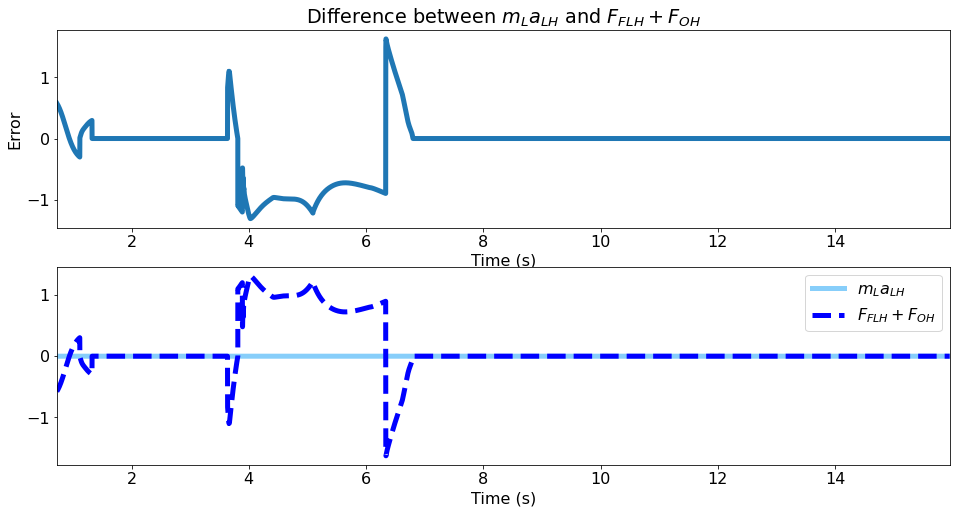

In [121]:
lhs_label = r'$m_La_{LH}$'
rhs_label = r'$F_{FLH} + F_{OH}$'

lhs = m_L*a_LH

rhs = F_FLH + F_OH

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

#### Link (T) accel $m_La_{LT} = F_{FLT} + F_{GT} +F_{OT}$
*If this plot is correct:*
The free body diagram is correct in thet $\hat T$ direction on the link.

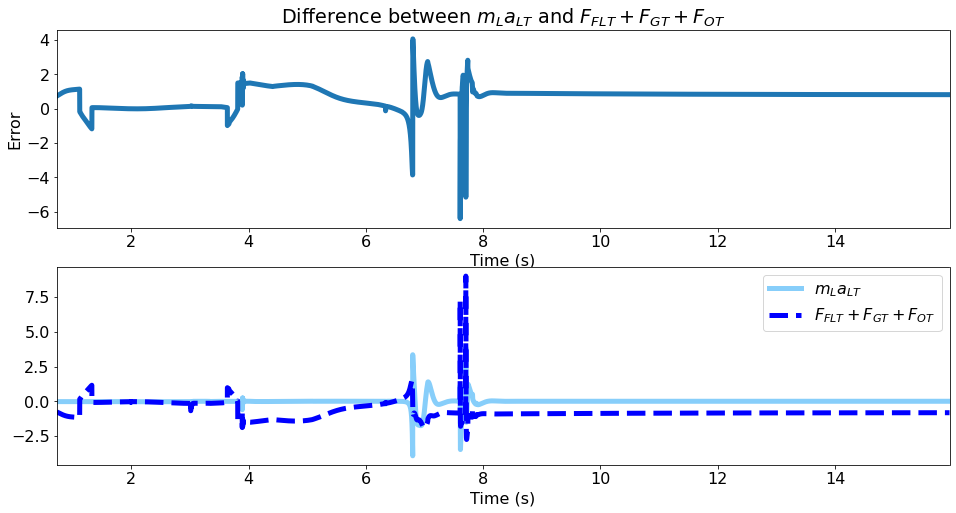

In [122]:
lhs_label = r'$m_La_{LT}$'
rhs_label = r'$F_{FLT} + F_{GT} +F_{OT}$'

lhs = m_L*a_LT
# lhs /= np.max(np.abs(lhs[idx_start:idx_end]))

rhs = F_GT+F_OT+F_FLT
# rhs /= np.max(np.abs(rhs[idx_start:idx_end]))

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

#### Link (N) accel $m_La_{LN} = F_{NL} + F_{GN} +F_{ON}$
*If this plot is correct:*
The free body diagram is correct in thet $\hat N$ direction on the link.

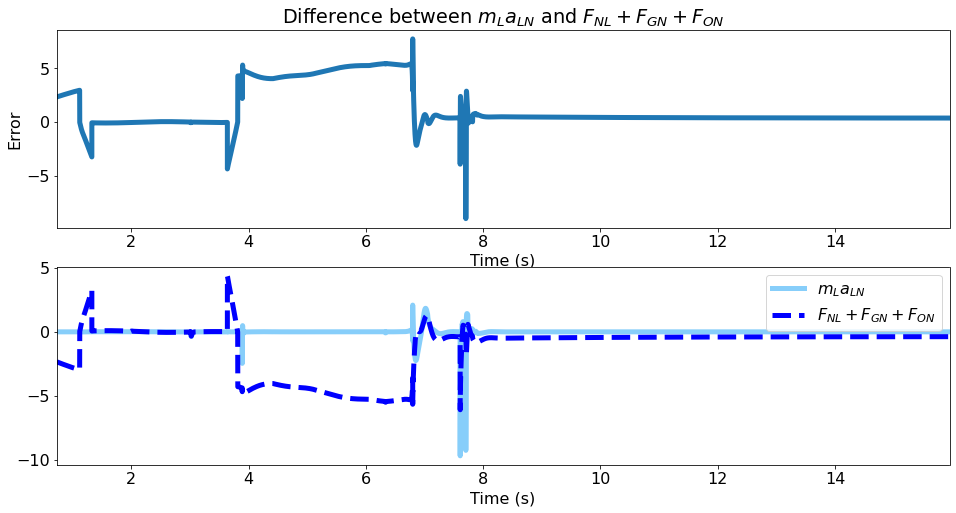

In [123]:
lhs_label = r'$m_La_{LN}$'
rhs_label = r'$F_{NL} + F_{GN} +F_{ON}$'

lhs = m_L*a_LN

rhs = F_NL + F_GN + F_ON

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

#### Link (H) angle accel $I_{LJ}\ddot\theta_L = p_{JC}\times F_{contact} + p_{JL}\times F_G + \tau_O$
*If this plot is correct:* The moment balance about the joint on the link is correct.

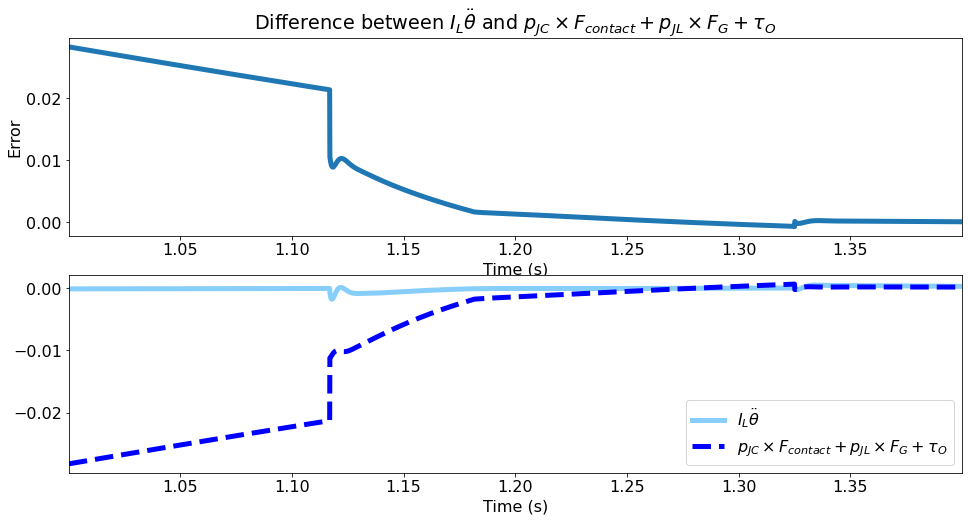

In [124]:
lhs_label = r'$I_L\ddot\theta$'
rhs_label = r'$p_{JC}\times F_{contact} + p_{JL}\times F_G + \tau_O$'

lhs = I_LJ*dd_theta_L
rhs = gravity_torque_about_joint + contact_torque_about_joint + tau_O

plot_eq(lhs, lhs_label, rhs, rhs_label, t_start_=1, t_end_=1.4)
update_error(lhs, lhs_label, rhs, rhs_label)

#### 3rd law normal forces $F_{NL} = -F_{NM}$
*If this plot is correct:* Newton's 3rd law is correction applied to the normal forces.

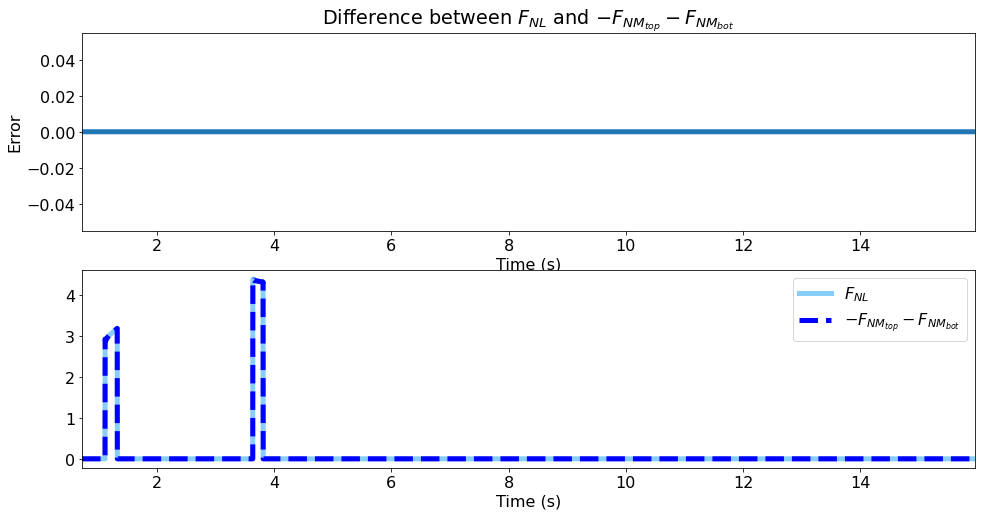

In [125]:
lhs_label = r'$F_{NL}$'
rhs_label = r'$-F_{NM_{top}}-F_{NM_{bot}}$'

lhs = F_NL

rhs = -F_NM

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

#### 3rd law friction forces $F_{FLT} = -F_{FMT}$
*If this plot is correct:* Newton's 3rd law is correction applied to the friction forces in the tangent direction.

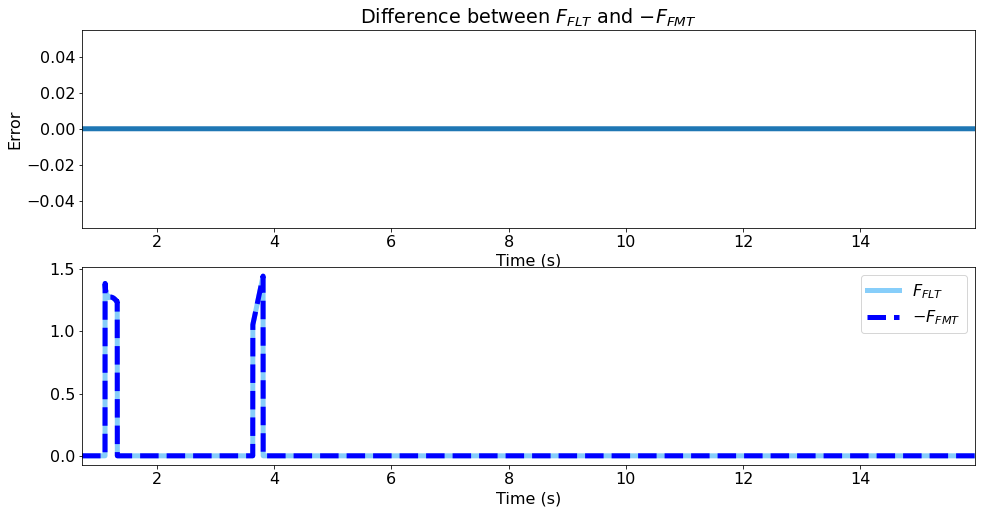

In [126]:
lhs_label = r'$F_{FLT}$'
rhs_label = r'$-F_{FMT}$'

lhs = F_FLT

rhs = -F_FMT

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

#### d vec tangential derivative $-\ddot\theta_L h_L/2 - \ddot\theta_L r + \dot\theta_L^2 w_L/2 - a_{LT} + a_{MT} = -\ddot\theta_L {d}_N + \ddot{d}_T - \dot\theta_L^2 {d}_T - 2\dot\theta_L \dot{d}_N$
*If this plot is correct:* The derivatives for  $\vec d$  are correct.

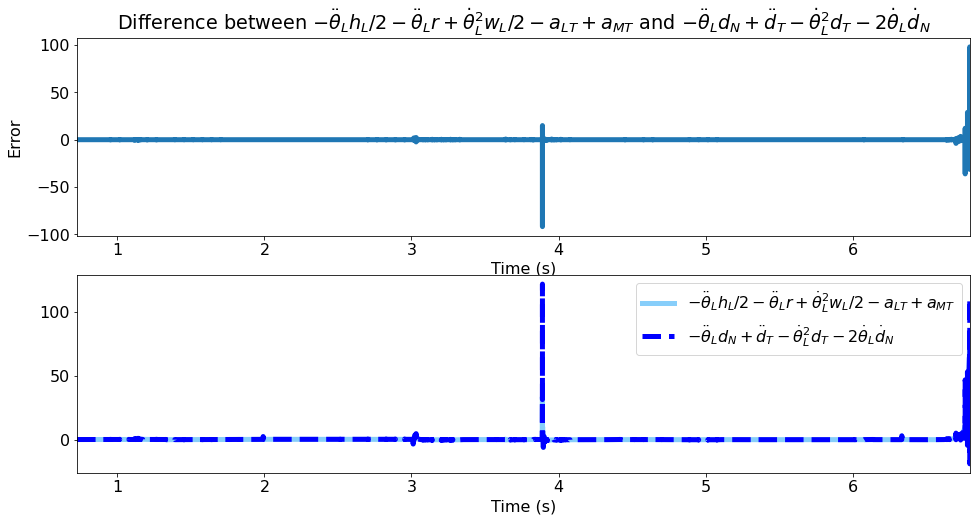

In [127]:
lhs = -dd_theta_L*(h_L/2+r) + d_theta_L**2*w_L/2 - a_LT + a_MT
lhs_label = r"$-\ddot\theta_L h_L/2 - \ddot\theta_L r + \dot\theta_L^2 w_L/2 - a_{LT} + a_{MT}$"

rhs = -dd_theta_L*d_N + dd_d_T - d_theta_L**2*d_T - 2*d_theta_L*d_d_N
rhs_label = r"$-\ddot\theta_L {d}_N + \ddot{d}_T - \dot\theta_L^2 {d}_T - 2\dot\theta_L \dot{d}_N$"

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label, newline_in_label=True)

#### d vec normal derivative $- \frac{w_{L}}{2}\ddot\theta_{L} - \frac{h_{L}}{2}\dot\theta_{L}^{2} - \dot\theta_{L}^{2} r - a_{LN} + a_{MN} = \ddot\theta_{L} d_{T} + \ddot{d}_N - \dot\theta_{L}^{2} d_{N} + 2 \dot\theta_{L} \dot{d}_T$
*If this plot is correct:* The derivatives for  $\vec d$  are correct.

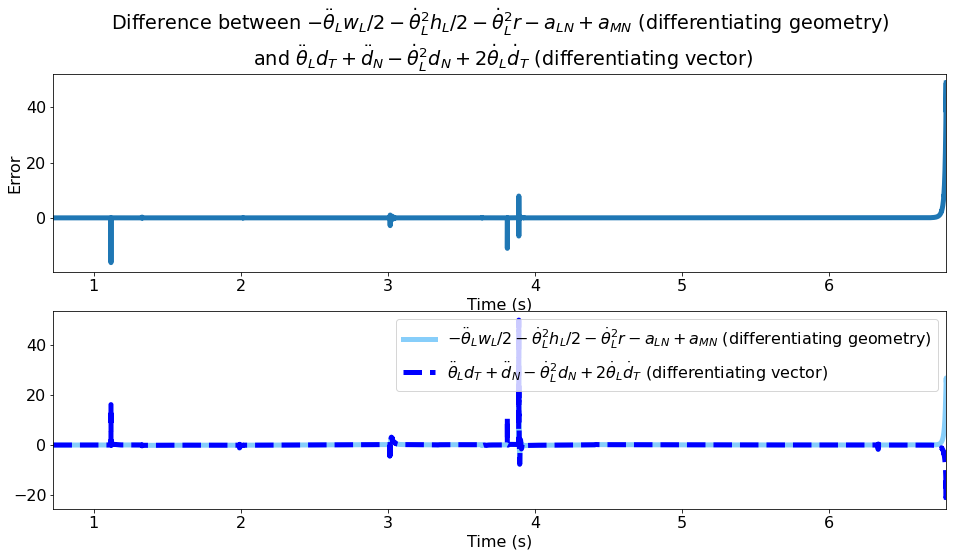

In [128]:
lhs = -dd_theta_L*w_L/2 - d_theta_L**2*h_L/2 - d_theta_L**2*r - a_LN + a_MN
lhs_label = r"$-\ddot\theta_L w_L/2 - \dot\theta_L^2 h_L/2 - \dot\theta_L^2 r - a_{LN} + a_{MN}$ (differentiating geometry)"

rhs = dd_theta_L*d_T + dd_d_N - d_theta_L**2*d_N + 2*d_theta_L*d_d_T
rhs_label = r"$\ddot\theta_L {d}_T + \ddot{d}_N - \dot\theta_L^2 {d}_N + 2 \dot\theta_L \dot{d}_T$ (differentiating vector)"

plot_eq(lhs, lhs_label, rhs, rhs_label, newline_in_title=True)

lhs_label = r"$-\ddot\theta_L w_L/2 - \dot\theta_L^2 h_L/2 - \dot\theta_L^2 r - a_{LN} + a_{MN}$"
rhs_label = r"$\ddot\theta_L {d}_T + \ddot{d}_N - \dot\theta_L^2 {d}_N + 2 \dot\theta_L \dot{d}_T$"
update_error(lhs, lhs_label, rhs, rhs_label, newline_in_label=True)
plt.show()

#### No penetration $\ddot d_N = 0$
*If this plot is correct:* There is effectively no penetration between the rigid bodies.

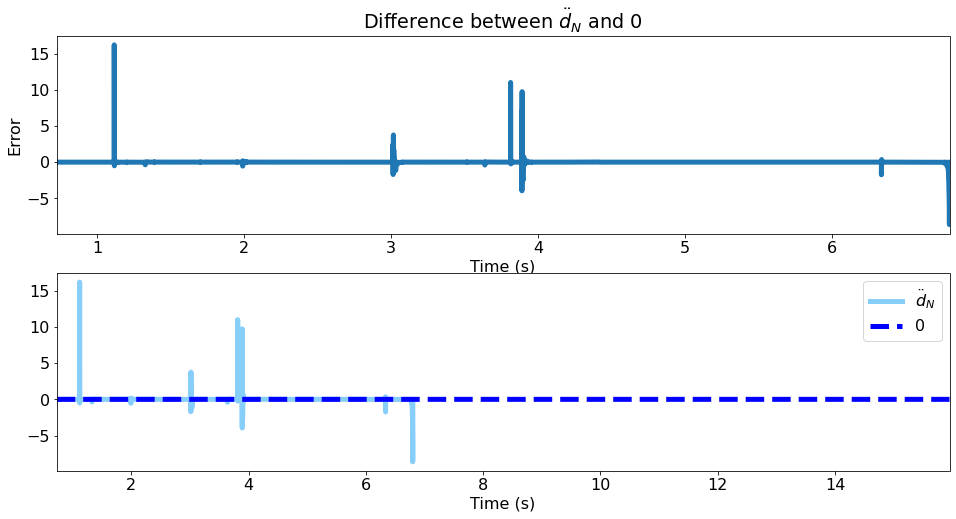

In [129]:
lhs_label = r'$\ddot{d}_N$'
rhs_label = r'0'

lhs = dd_d_N

rhs = 0

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

#### Link (T) friction equation $F_{FLT}=\mu\mu_SF_{NL}\hat s_T$

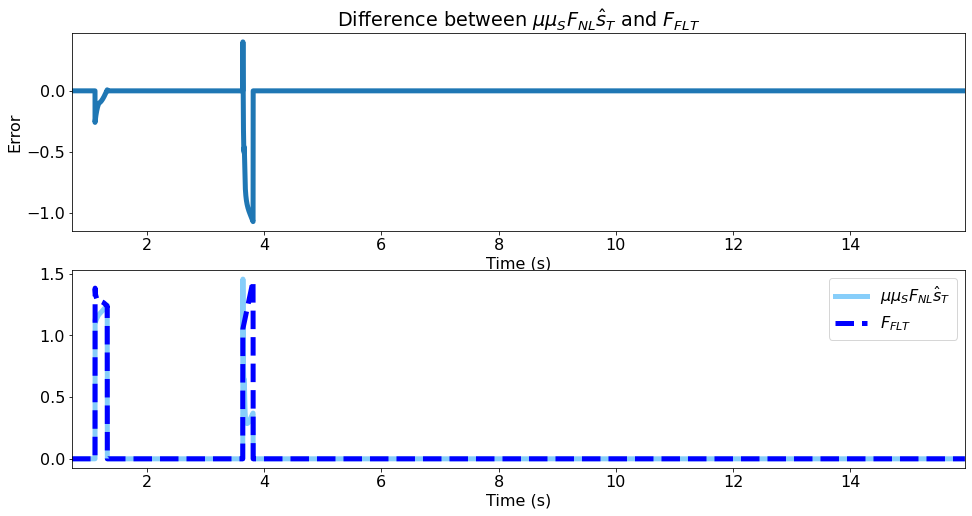

In [130]:
lhs_label = r'$\mu\mu_SF_{NL}\hat s_T$'
rhs_label = r'$F_{FLT}$'

lhs = np.nan_to_num(mu_S*F_NL*mu*s_hat_T)
rhs = F_FLT

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

#### Link (x) friction equation $F_{FLX}=\mu\mu_SF_{NL}\hat s_X$

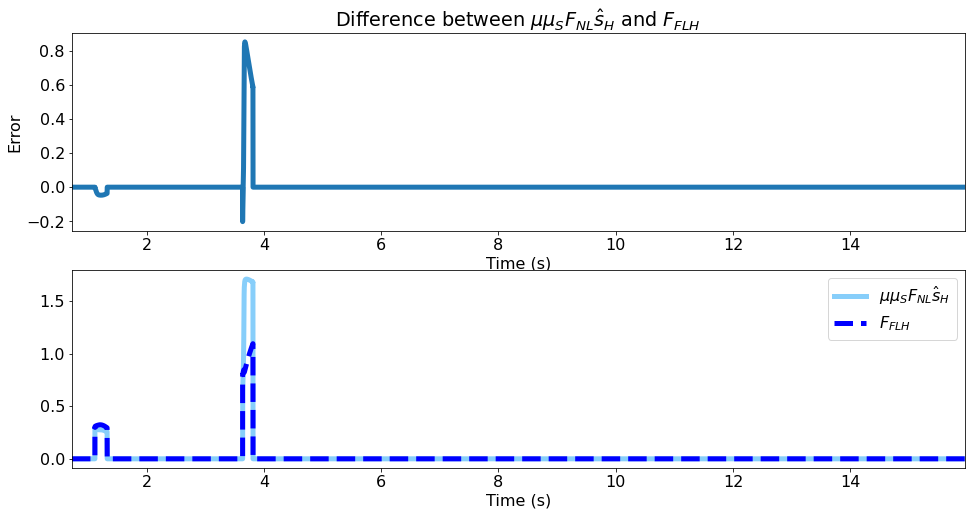

In [131]:
lhs_label = r'$\mu\mu_SF_{NL}\hat s_H$'
rhs_label = r'$F_{FLH}$'

lhs = np.nan_to_num(mu_S*F_NM*mu*s_hat_H)
rhs = F_FMH

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

#### Jacobian and (x) accel $a_{MX}=\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_3$

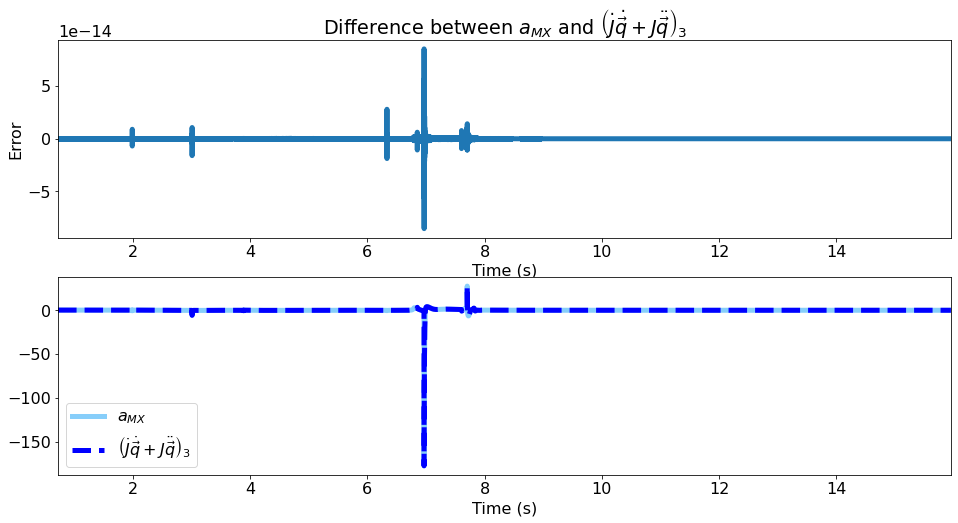

In [132]:
lhs_label = r'$a_{MX}$'
rhs_label = r'$\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_3$'

lhs = a_MX
rhs = (Jdot_qdot + np.matmul(J, dd_q))[:,3].flatten()

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

#### Jacobian and (y) accel $a_{MY}=\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_4$

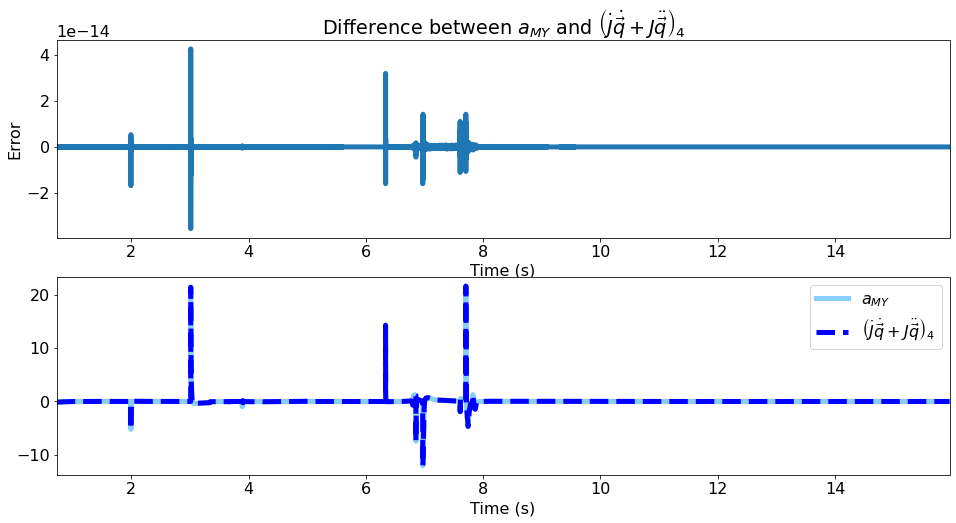

In [133]:
lhs_label = r'$a_{MY}$'
rhs_label = r'$\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_4$'

lhs = a_MY
rhs = (Jdot_qdot + np.matmul(J, dd_q))[:,4].flatten()

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

#### Jacobian and (z) accel $a_{MZ}=\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_5$

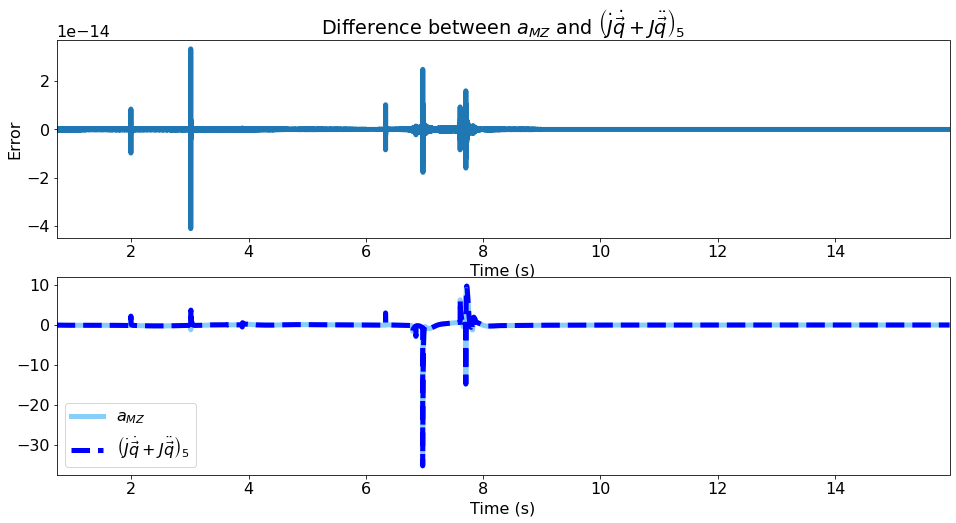

In [134]:
lhs_label = r'$a_{MZ}$'
rhs_label = r'$\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_5$'

lhs = a_MZ
rhs = (Jdot_qdot + np.matmul(J, dd_q))[:,5].flatten()

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

#### Jacobian and (x) ang accel $\alpha_{MX}=\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_0$

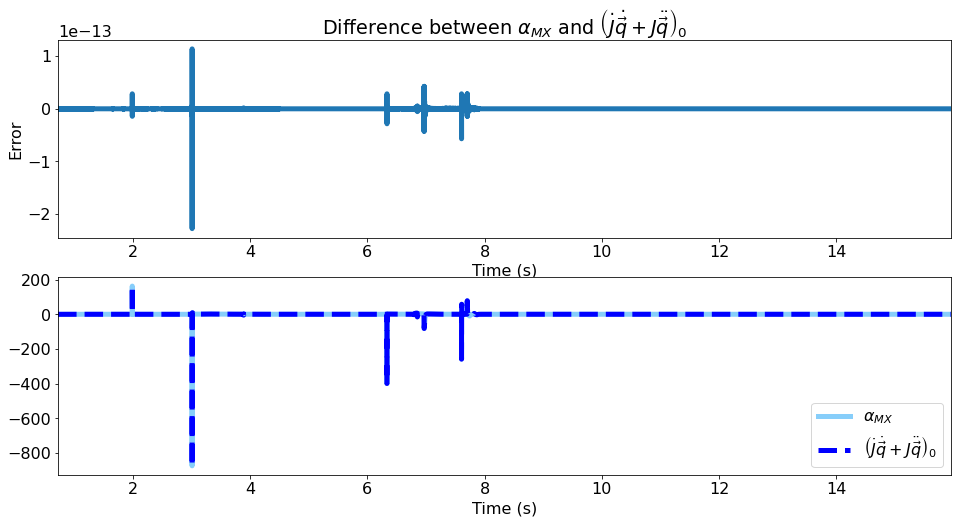

In [135]:
lhs_label = r'$\alpha_{MX}$'
rhs_label = r'$\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_0$'

lhs = alpha_MX
rhs = (Jdot_qdot + np.matmul(J, dd_q))[:,0].flatten()

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

#### Jacobian and (y) ang accel $\alpha_{MY}=\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_1$

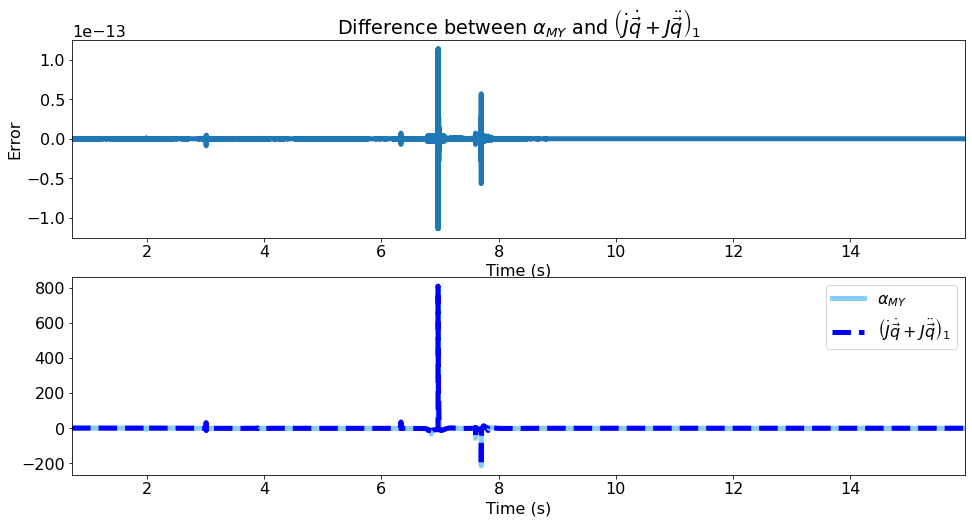

In [136]:
lhs_label = r'$\alpha_{MY}$'
rhs_label = r'$\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_1$'

lhs = alpha_MY
rhs = (Jdot_qdot + np.matmul(J, dd_q))[:,1].flatten()

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

#### Jacobian and (z) ang accel $\alpha_{MZ}=\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_2$

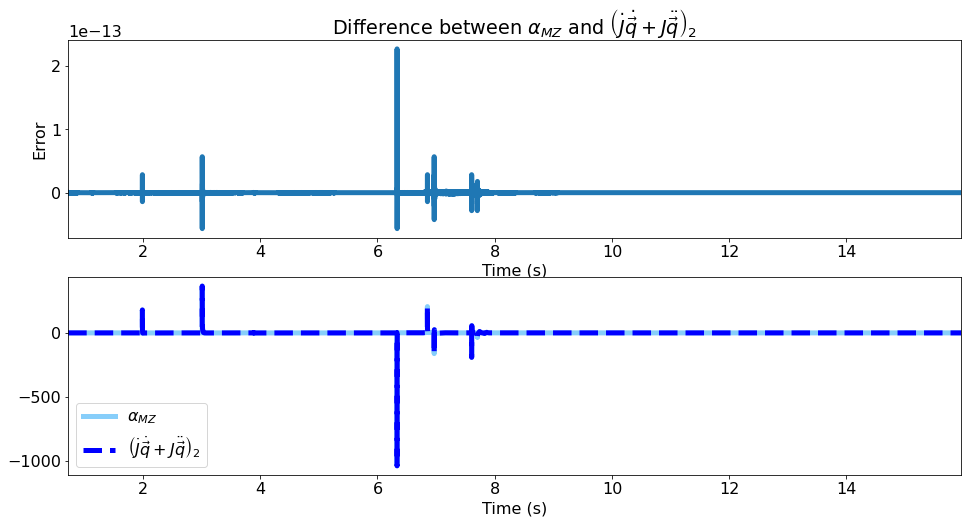

In [137]:
lhs_label = r'$\alpha_{MZ}$'
rhs_label = r'$\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_2$'

lhs = alpha_MZ
rhs = (Jdot_qdot + np.matmul(J, dd_q))[:,2].flatten()

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

#### Manipulator equation $M \ddot q + C \dot q = \tau_g + \vec \tau_{\text{contact}} + \vec \tau_{\text{out}}$

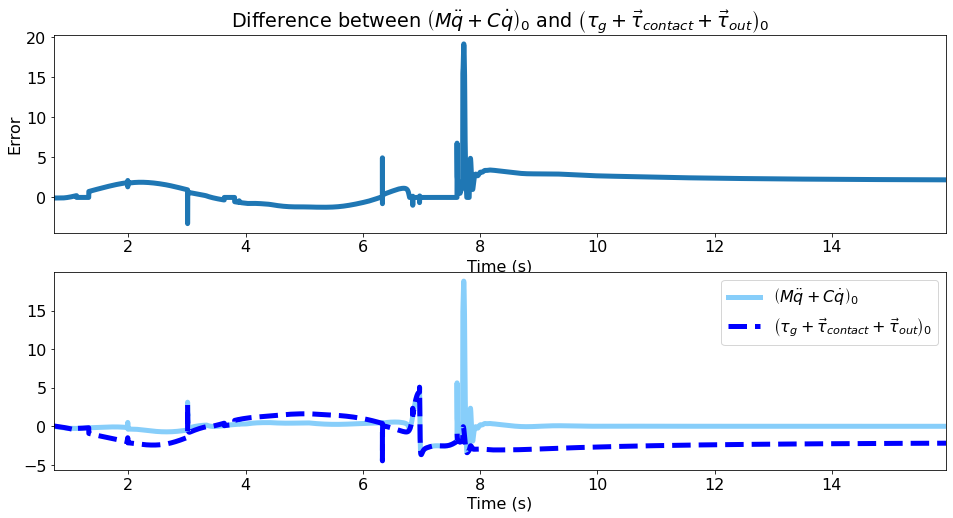

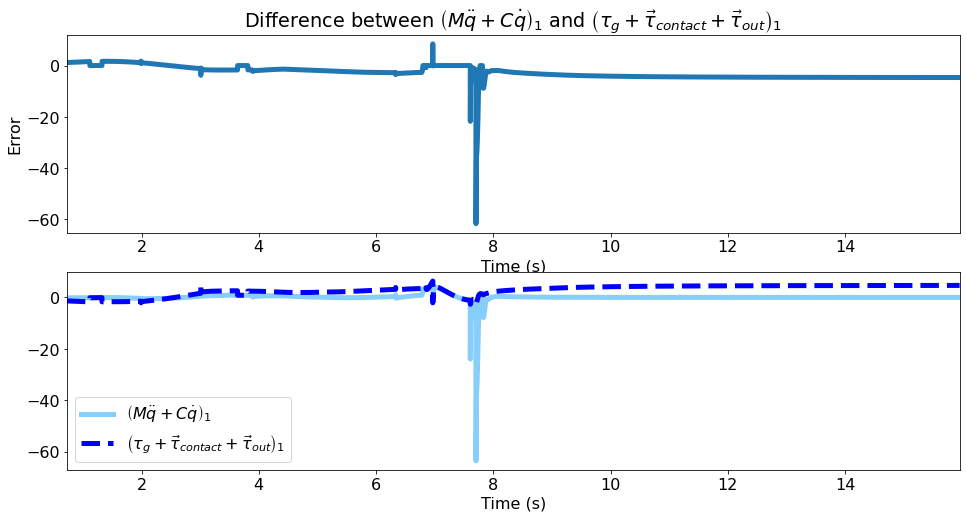

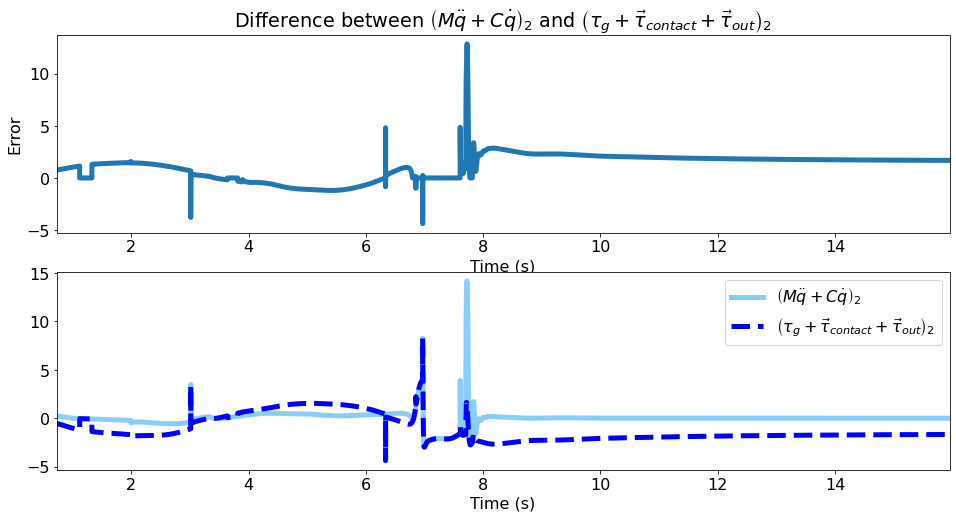

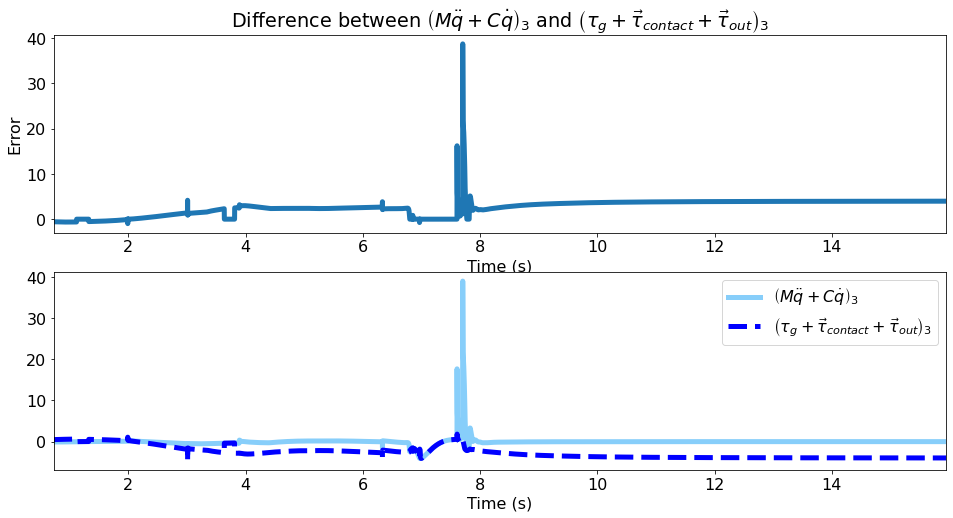

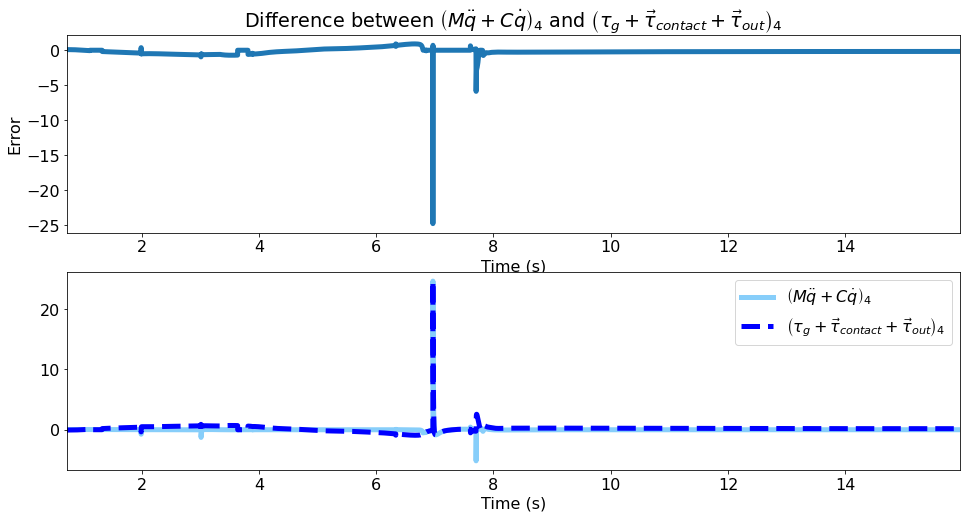

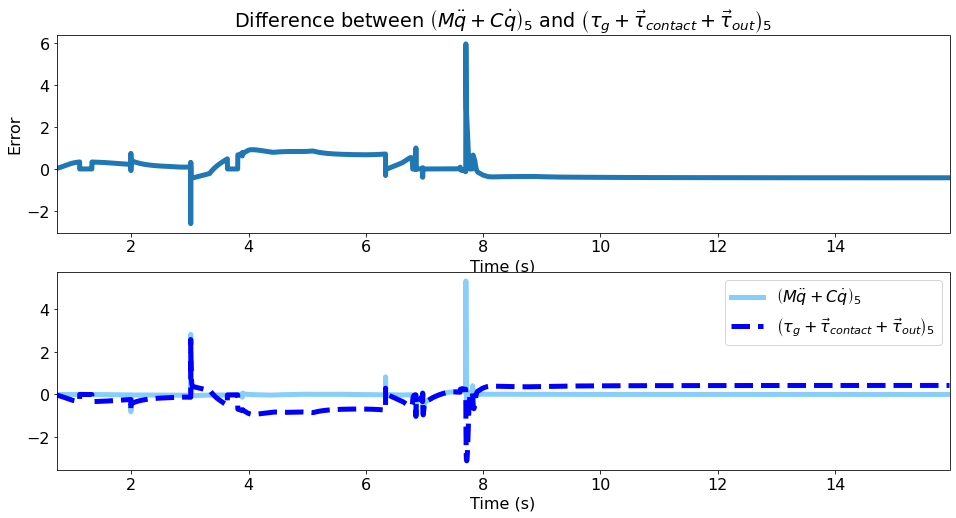

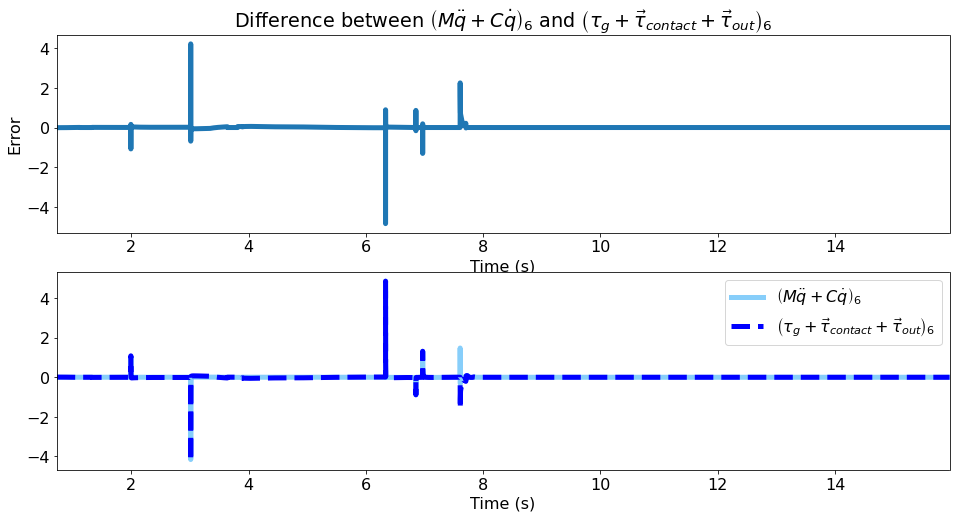

In [138]:
lhs_ = np.matmul(M, dd_q) + Cv
lhs_label_ = r"M \ddot q + C \dot q"
rhs_ = tau_g + tau_contact + tau_out
rhs_label_ = r"\tau_g + \vec \tau_{contact} + \vec \tau_{out}"
labels = [str(i) for i in range(nq)]

for i, label in enumerate(labels):
    lhs = lhs_[:,i,:]
    lhs_label = r"$\left(" + lhs_label_ + r"\right)_" + label + "$"

    rhs = rhs_[:,i,:]
    rhs_label = r"$\left(" + rhs_label_ + r"\right)_" + label + "$"

    plot_eq(lhs, lhs_label, rhs, rhs_label)
    update_error(lhs, lhs_label, rhs, rhs_label)
    plt.show()

#### Tau out vs tau ctrl $\vec \tau_{\text{out}} = \vec\tau_{\text{ctrl}} - \tau_g + \tau_{\text{joint centering}}$

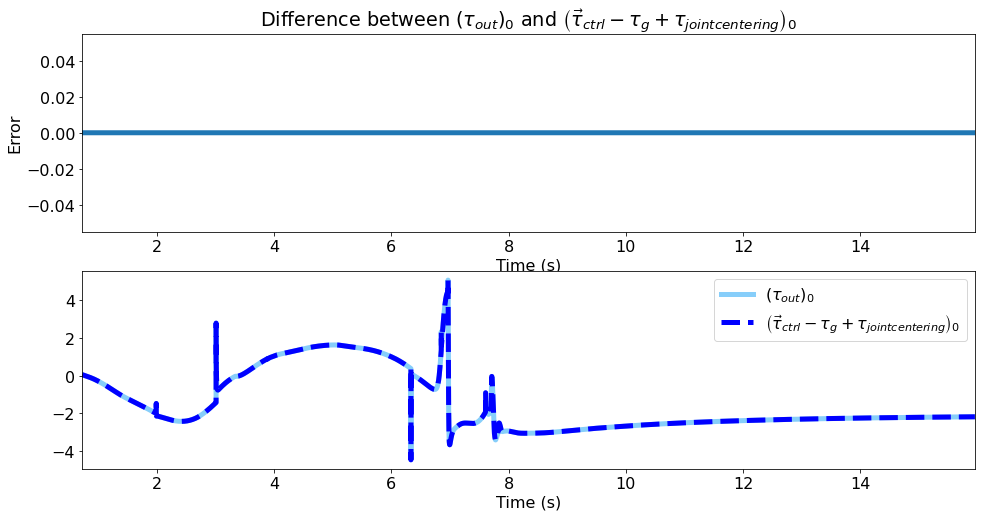

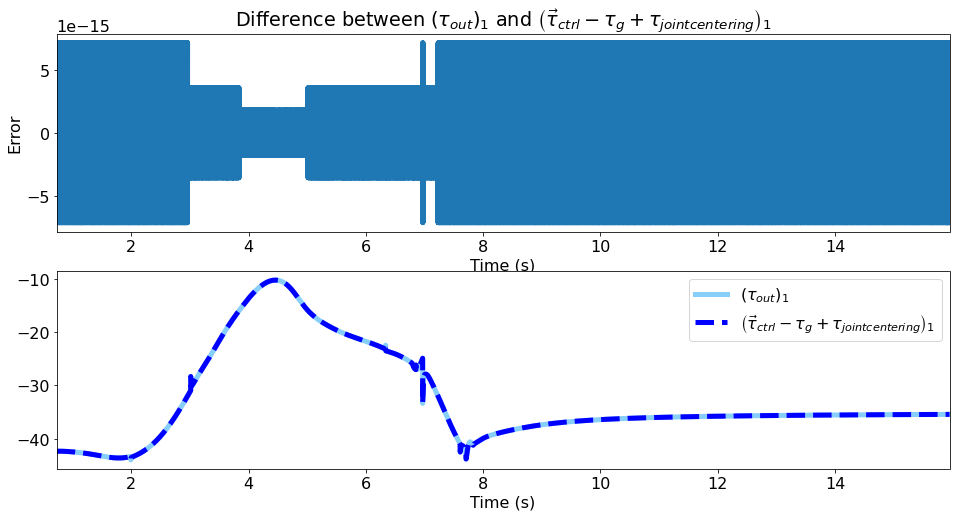

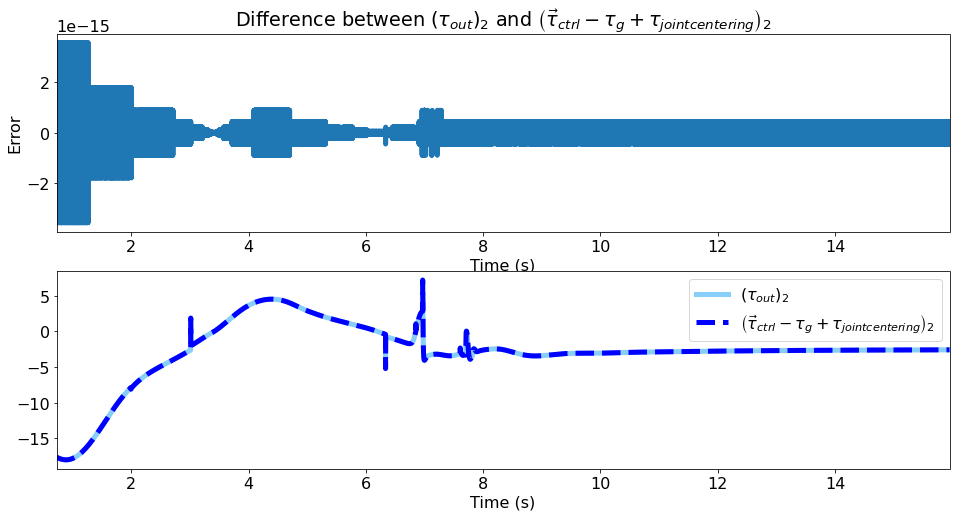

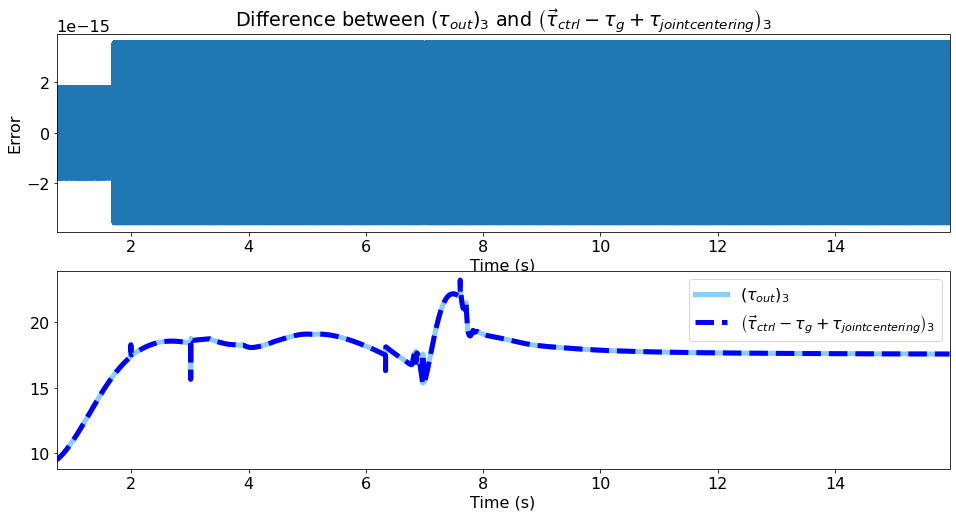

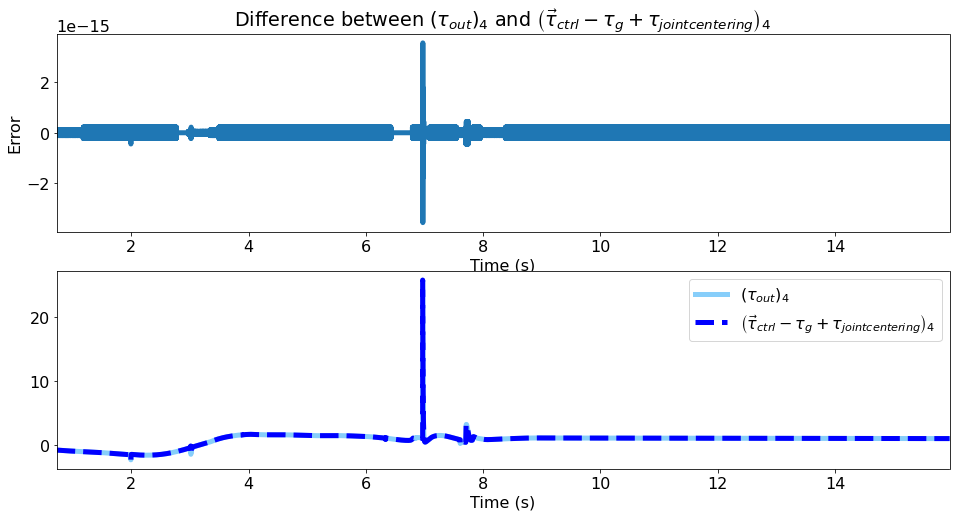

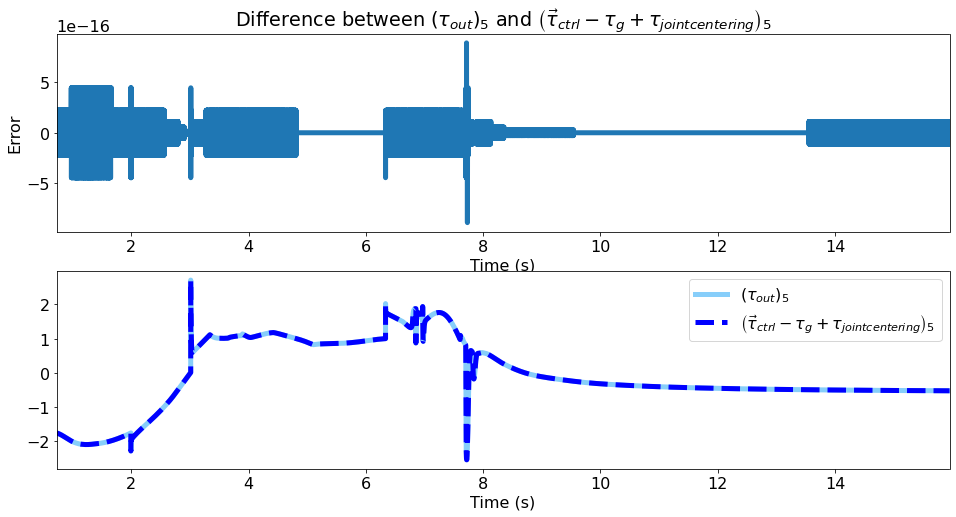

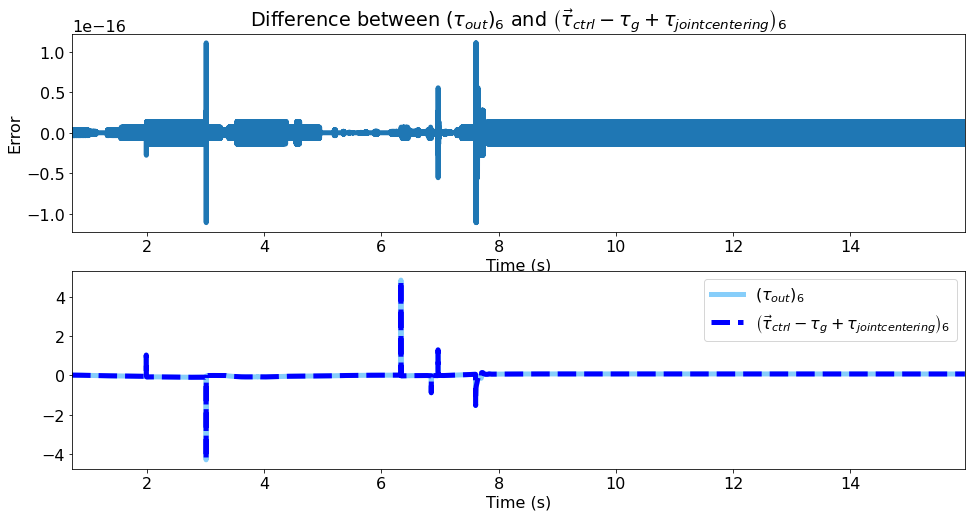

In [139]:
lhs_ = tau_out
lhs_label_ = r"\tau_{out}"
rhs_ = tau_ctrl - tau_g + joint_centering_torque
rhs_label_ = r"\vec\tau_{ctrl} - \tau_g + \tau_{joint centering}"
labels = [str(i) for i in range(nq)]

for i, label in enumerate(labels):
    lhs = lhs_[:,i,:]
    lhs_label = r"$\left(" + lhs_label_ + r"\right)_" + label + "$"

    rhs = rhs_[:,i,:]
    rhs_label = r"$\left(" + rhs_label_ + r"\right)_" + label + "$"

    plot_eq(lhs, lhs_label, rhs, rhs_label)
    update_error(lhs, lhs_label, rhs, rhs_label)
    plt.show()

### Plot errors
How accurate is my modeling?

#### Absolute error

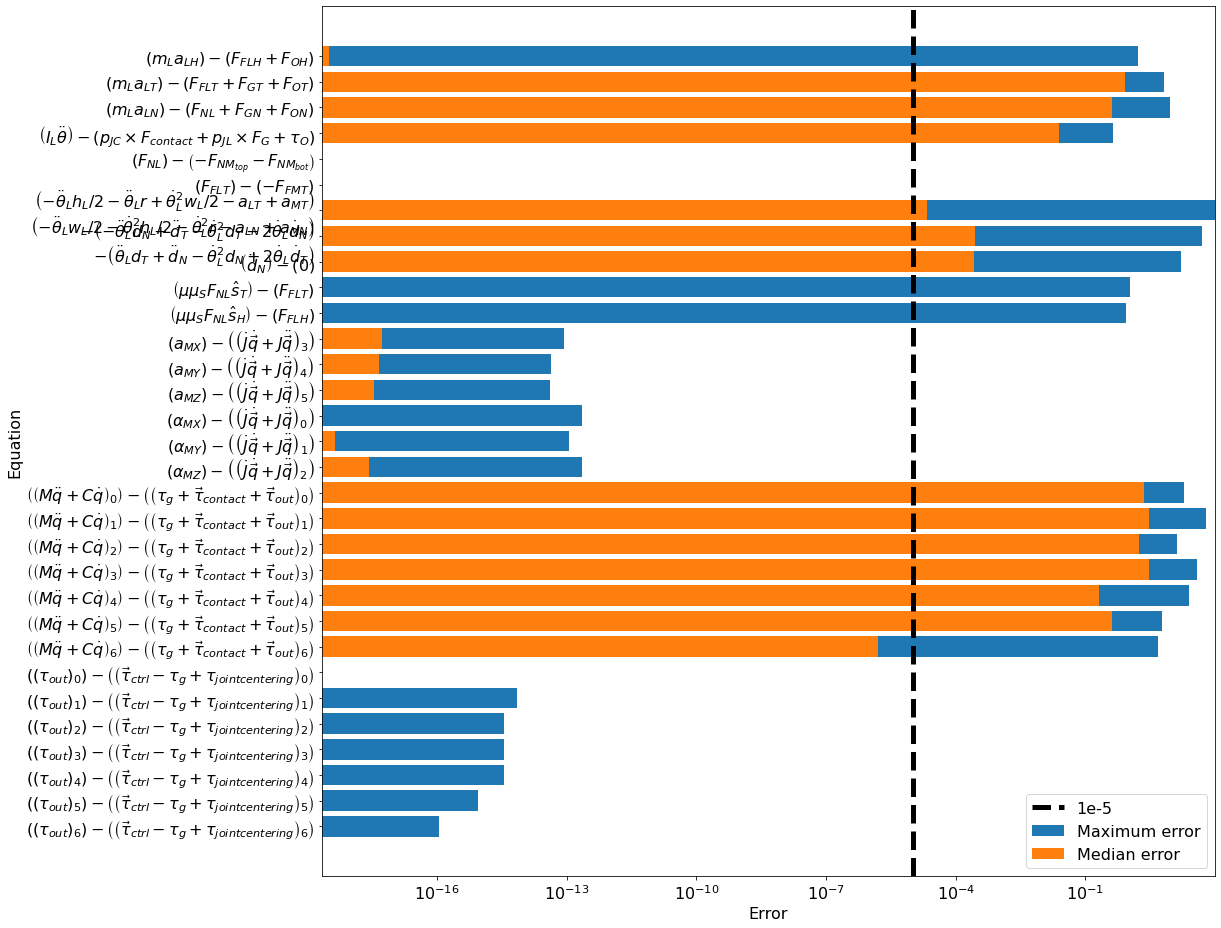

In [140]:
plt.figure(figsize=(16,16))
plt.barh(error_labels[::-1], np.array(max_errors[::-1]), label="Maximum error")
plt.barh(error_labels[::-1], np.array(med_errors[::-1]), label="Median error")
plt.axvline(1e-5, color='k', linestyle='--', label="1e-5")
plt.xscale("log")
plt.xlabel("Log(error)")
plt.xlabel("Error")
plt.ylabel("Equation")
plt.legend()
# plt.xlim(0, 100)
plt.show()

#### Percent error

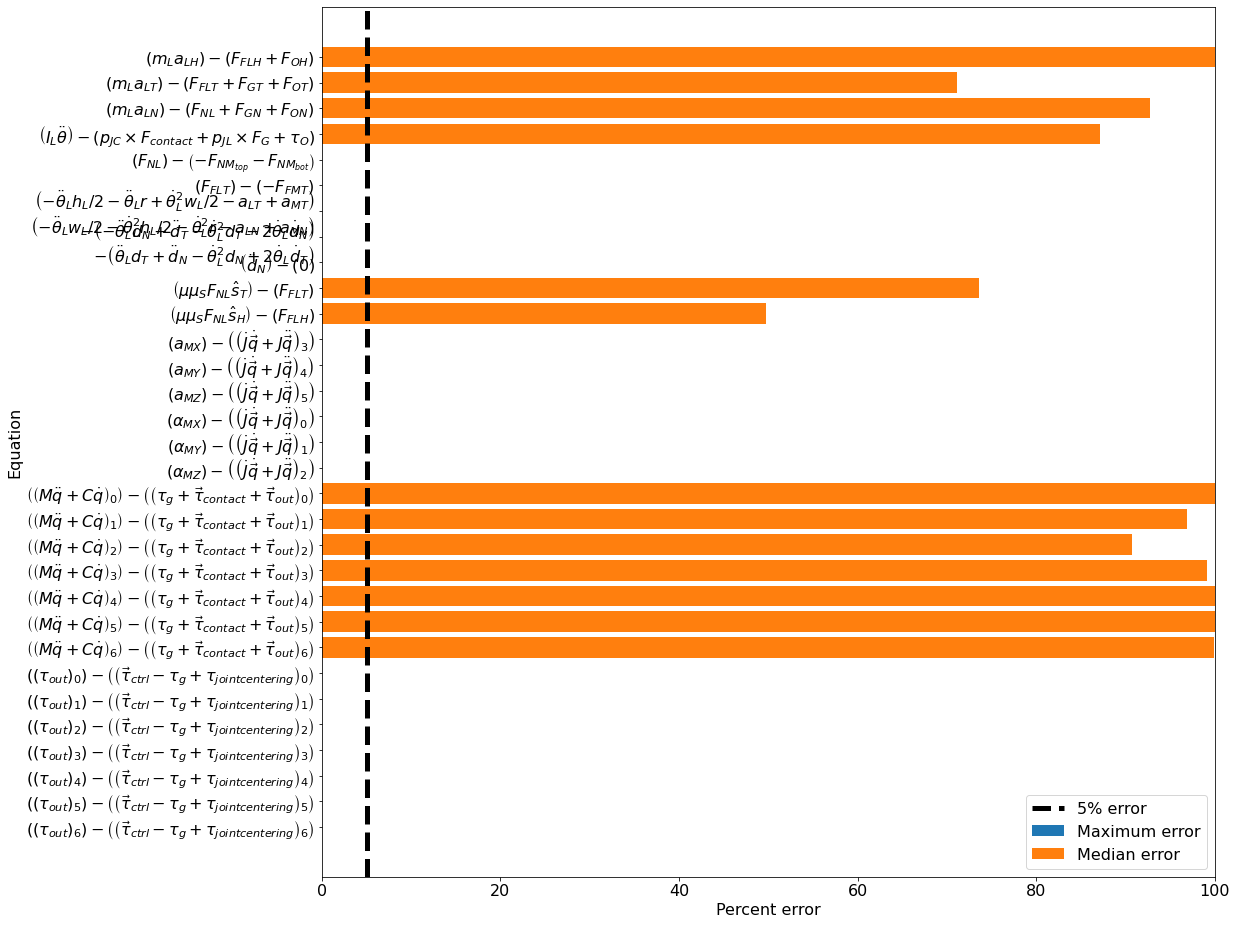

In [141]:
plt.figure(figsize=(16,16))
plt.barh(error_labels[::-1], np.array(max_error_pct[::-1])*100, label="Maximum error")
plt.barh(error_labels[::-1], np.array(med_error_pct[::-1])*100, label="Median error")
plt.axvline(5, color='k', linestyle='--', label="5% error")
# plt.xscale("log")
# plt.xlabel("Log(error)")
plt.xlabel("Percent error")
plt.ylabel("Equation")
plt.legend()
plt.xlim(0, 100)
plt.show()

### Environmental constraints (two link specific)

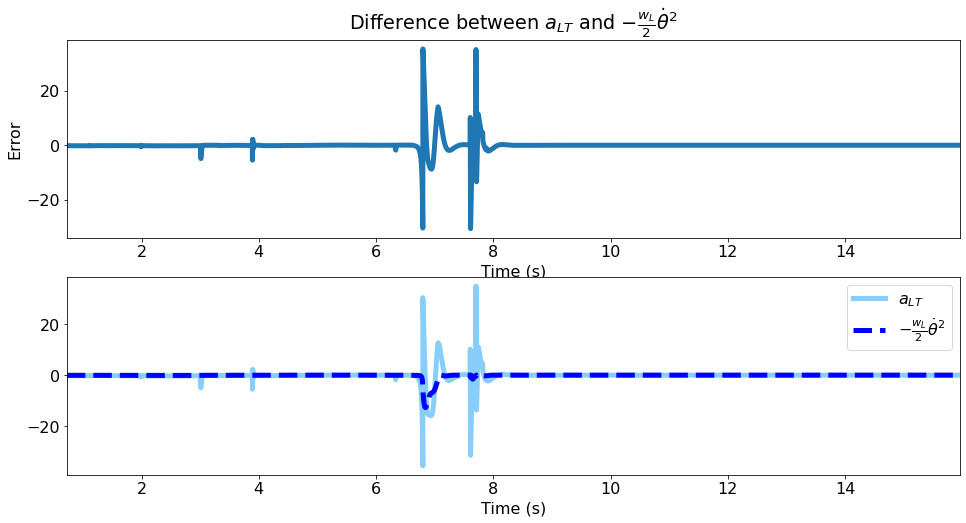

In [142]:
lhs = a_LT
lhs_label = r"$a_{LT}$"
rhs = -np.linalg.norm(p_JL,axis=1).flatten()*d_theta_L**2
rhs_label = r"$-\frac{w_L}{2}\dot\theta^2$"
plot_eq(lhs, lhs_label, rhs, rhs_label)

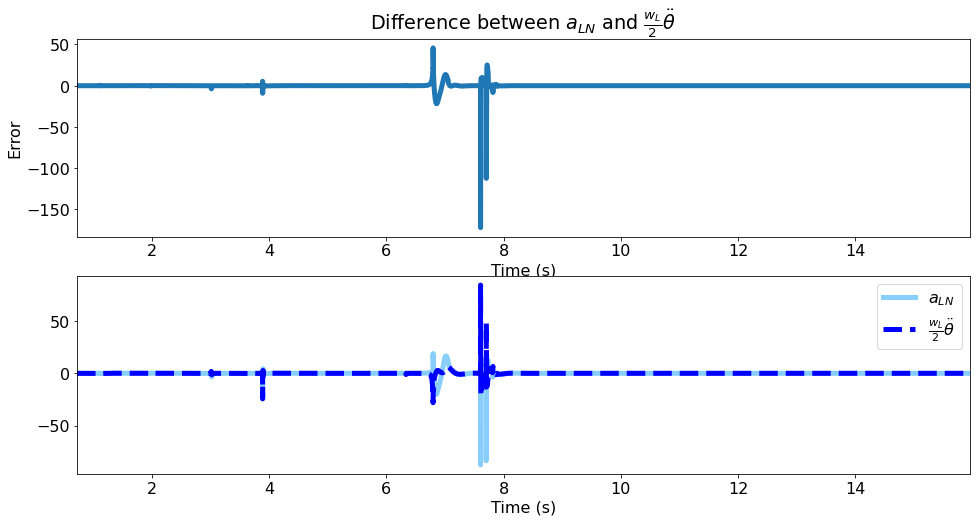

In [143]:
lhs = a_LN
lhs_label = r"$a_{LN}$"
rhs = np.linalg.norm(p_JL,axis=1).flatten()*dd_theta_L
rhs_label = r"$\frac{w_L}{2}\ddot\theta$"
plot_eq(lhs, lhs_label, rhs, rhs_label)

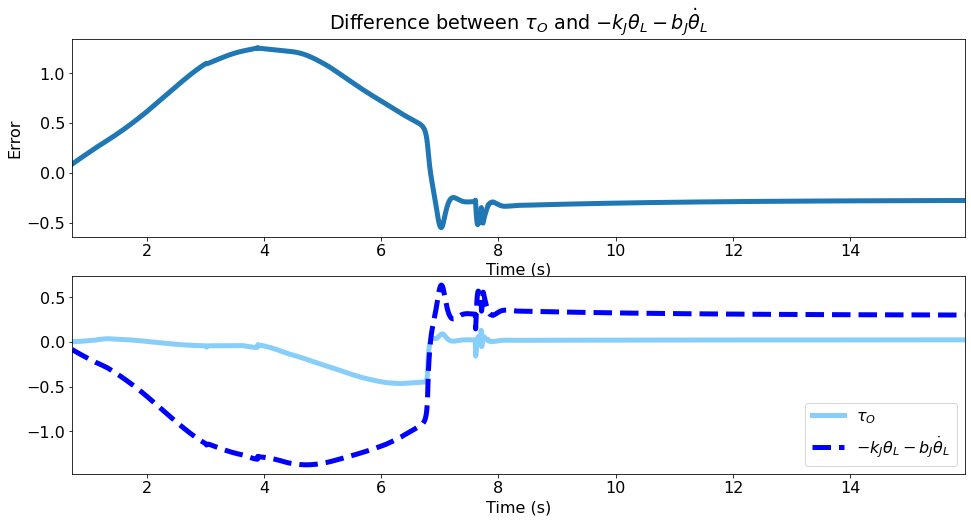

In [144]:
lhs = tau_O
lhs_label = r"$\tau_O$"
rhs = -sim.sim_sys_consts.k_J*theta_L - sim.sim_sys_consts.b_J*d_theta_L
rhs_label = r"$-k_J\theta_L-b_J\dot\theta_L$"
plot_eq(lhs, lhs_label, rhs, rhs_label)

## Controller performance

### Inverse dynamics targets

#### Load values

In [145]:
if (ctrl_paradigm == plant.simulation.CtrlParadigm.INVERSE_DYNAMICS):
    # Second order targets
    dd_d_Td = scipy.interpolate.interp1d(d_times, debug['dd_d_Td'], axis=0, fill_value="extrapolate")(l_times)
    dd_theta_Ld = scipy.interpolate.interp1d(d_times, debug['dd_theta_Ld'], axis=0, fill_value="extrapolate")(l_times)
    a_MHd = scipy.interpolate.interp1d(d_times, debug['a_MH_d'], axis=0, fill_value="extrapolate")(l_times)
    alpha_MXd = scipy.interpolate.interp1d(d_times, debug['alpha_MXd'], axis=0, fill_value="extrapolate")(l_times).flatten()
    alpha_MYd = scipy.interpolate.interp1d(d_times, debug['alpha_MYd'], axis=0, fill_value="extrapolate")(l_times).flatten()
    alpha_MZd = scipy.interpolate.interp1d(d_times, debug['alpha_MZd'], axis=0, fill_value="extrapolate")(l_times).flatten()
    dd_d_Nd = scipy.interpolate.interp1d(d_times, debug['dd_d_Nd'], axis=0, fill_value="extrapolate")(l_times)
    
    # First order targets
    d_theta_Ld = sim.fold_ctrl.d_theta_Ld*np.ones_like(l_times)
    omega_MXd = scipy.interpolate.interp1d(d_times, debug['omega_MXd'], axis=0, fill_value="extrapolate")(l_times)
    omega_MYd = scipy.interpolate.interp1d(d_times, debug['omega_MYd'], axis=0, fill_value="extrapolate")(l_times)
    omega_MZd = scipy.interpolate.interp1d(d_times, debug['omega_MZd'], axis=0, fill_value="extrapolate")(l_times)
    d_theta_MXd = scipy.interpolate.interp1d(d_times, debug['omega_MXd'], axis=0, fill_value="extrapolate")(l_times)
    d_theta_MYd = scipy.interpolate.interp1d(d_times, debug['omega_MYd'], axis=0, fill_value="extrapolate")(l_times)
    d_theta_MZd = scipy.interpolate.interp1d(d_times, debug['omega_MZd'], axis=0, fill_value="extrapolate")(l_times)
    
    theta_MXd = scipy.interpolate.interp1d(d_times, debug['theta_MXd'], axis=0, fill_value="extrapolate")(l_times)
    theta_MYd = scipy.interpolate.interp1d(d_times, debug['theta_MYd'], axis=0, fill_value="extrapolate")(l_times)
    theta_MZd = scipy.interpolate.interp1d(d_times, debug['theta_MZd'], axis=0, fill_value="extrapolate")(l_times)

#### Desired second accelerations
These are all decision variables.

In [146]:
if (ctrl_paradigm == plant.simulation.CtrlParadigm.INVERSE_DYNAMICS):
    lhs = dd_d_Td
    lhs_label = r"$\ddot{d}_{T_d}$"
    rhs = dd_d_T
    rhs_label = r"$\ddot{d}_{T}$"
    plot_eq(lhs, lhs_label, rhs, rhs_label)

In [147]:
if (ctrl_paradigm == plant.simulation.CtrlParadigm.INVERSE_DYNAMICS):
    lhs = dd_theta_Ld
    lhs_label = r"$\ddot\theta_{Ld}$"
    rhs = dd_theta_L
    rhs_label = r"$\ddot\theta_{L}$"
    plot_eq(lhs, lhs_label, rhs, rhs_label)

In [148]:
if (ctrl_paradigm == plant.simulation.CtrlParadigm.INVERSE_DYNAMICS):
    lhs = a_MHd
    lhs_label = r"$a_{MHd}$"
    rhs = a_MH
    rhs_label = r"$a_{MH}$"
    plot_eq(lhs, lhs_label, rhs, rhs_label)

In [149]:
if (ctrl_paradigm == plant.simulation.CtrlParadigm.INVERSE_DYNAMICS):
    lhs = alpha_MXd
    lhs_label = r"$\alpha_{MX_d}$"
    rhs = alpha_MX
    rhs_label = r"$\alpha_{MX}$"
    plot_eq(lhs, lhs_label, rhs, rhs_label)

In [150]:
if (ctrl_paradigm == plant.simulation.CtrlParadigm.INVERSE_DYNAMICS):
    lhs = alpha_MYd
    lhs_label = r"$\alpha_{MY_d}$"
    rhs = alpha_MY
    rhs_label = r"$\alpha_{MY}$"
    plot_eq(lhs, lhs_label, rhs, rhs_label)

In [151]:
if (ctrl_paradigm == plant.simulation.CtrlParadigm.INVERSE_DYNAMICS):
    lhs = alpha_MZd
    lhs_label = r"$\alpha_{MZ_d}$"
    rhs = alpha_MZ
    rhs_label = r"$\alpha_{MZ}$"
    plot_eq(lhs, lhs_label, rhs, rhs_label)

In [152]:
if (ctrl_paradigm == plant.simulation.CtrlParadigm.INVERSE_DYNAMICS):
    lhs = dd_d_Nd
    lhs_label = r"$\ddot{d}_{N_d}$"
    rhs = dd_d_N
    rhs_label = r"$\ddot{d}_{N}$"
    plot_eq(lhs, lhs_label, rhs, rhs_label)

#### Desired velocities

In [153]:
if (ctrl_paradigm == plant.simulation.CtrlParadigm.INVERSE_DYNAMICS):
    plot_eq(omega_MX, r"$\omega_{MX}$", omega_MXd, r"$\omega_{MXd}$")
    plot_eq(omega_MY, r"$\omega_{MY}$", omega_MYd, r"$\omega_{MYd}$")
    plot_eq(omega_MZ, r"$\omega_{MZ}$", omega_MZd, r"$\omega_{MZd}$")
    plot_eq(d_theta_MX, r"$\dot\theta_{MX}$", d_theta_MXd, r"$\dot\theta_{MXd}$")
    plot_eq(d_theta_MY, r"$\dot\theta_{MY}$", d_theta_MYd, r"$\dot\theta_{MYd}$")
    plot_eq(d_theta_MZ, r"$\dot\theta_{MZ}$", d_theta_MZd, r"$\dot\theta_{MZd}$")
    plot_eq(d_theta_L, r"$\dot\theta_{L}$", d_theta_Ld, r"$\dot\theta_{Ld}$")

#### Desired positions

In [154]:
if (ctrl_paradigm == plant.simulation.CtrlParadigm.INVERSE_DYNAMICS):
    plot_eq(d_T, r"$d_T$", sim.fold_ctrl.d_Td, r"$d_{Td}$")
    plot_eq(d_H, r"$d_H$", sim.fold_ctrl.d_Hd, r"$d_{Hd}$")
    plot_eq(theta_MX, r"$\theta_{MX}$", theta_MXd, r"$\theta_{MXd}$")
    plot_eq(theta_MY, r"$\theta_{MY}$", theta_MYd, r"$\theta_{MYd}$")
    plot_eq(theta_MZ, r"$\theta_{MZ}$", theta_MZd, r"$\theta_{MZd}$")

#### Other plots

In [155]:
if (ctrl_paradigm == plant.simulation.CtrlParadigm.INVERSE_DYNAMICS):
    lw=5
    plt.figure(figsize=(16, 8))
    plt.axhline(sim.fold_ctrl.d_Td, linestyle='--', color='gray', linewidth=lw, label="Desired $d_T$")
    plt.plot(l_times, d_T, label='$d_T$', linewidth=lw)
    plt.axhline(-(0), label='Bounds on $d_T$ (0 and link width)', linestyle='--', color='k', linewidth=lw)
    plt.axhline(-(sim.sim_sys_consts.w_L), linestyle='--', color='k', linewidth=lw)
    plt.legend()
    plt.xlabel("Time (seconds)")
    plt.ylabel("Distance (m)")
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.xlim(t_start, t_end)
    plt.show()

## Controller exits
If `exit_when_folded` is true, this plot will not be as useful.

### Successful finish

In [156]:
link_z = sim.vision_processor.X_LJ_L.translation()[-1]

In [157]:
z_thresh_tol = h_L/10
z_thresh = p_FL[0][-1,0] + 2*link_z + z_thresh_tol
z_thresh

0.40377246238000797

In [158]:
# final_idx = np.argmax(np.logical_and(
#     p_L[first_contact_idx:,2] < z_thresh,
#     theta_L[first_contact_idx:] > np.pi,
# )) + first_contact_idx

In [159]:
# plt.figure()
# plt.subplot(131)
# plt.axhline(0, color='k', linewidth=2)
# plt.plot(l_times, theta_L)

# # plt.axvline(l_times[first_contact_idx], color='g', alpha=0.2, label="First contact time")
# # plt.axvline(l_times[final_idx], color='r', alpha=0.2, label="Calculated final time")
# plt.axhline(np.pi, color='black', linestyle='--', linewidth=2, label=r"$\theta_L$ threshold ($\pi$)")
# plt.legend()
# plt.title(r"$\theta_L$")
# plt.xlabel("Time (s)")
# plt.ylabel("Angle (radiancs)")

# plt.subplot(132)
# plt.plot(l_times, p_L[:,2])
# # plt.axvline(l_times[first_contact_idx], color='g', alpha=0.2, label="First contact time")
# # plt.axvline(l_times[final_idx], color='r', alpha=0.2, label="Calculated final time")
# plt.axhline(z_thresh, color='black', linestyle='--', linewidth=2,
#             label=r"$p_{LZ}$ threshold (" + "{:.2f}".format(z_thresh) + ")")
# plt.legend()
# plt.title(r"$p_{LZ}$")
# plt.xlabel("Time (s)")
# plt.ylabel("Position (m)")

# plt.subplot(133)
# plt.plot(l_times, p_L[:,1-hinge_rotation_axis])
# plt.plot(l_times, p_FL[:,1-hinge_rotation_axis])
# # plt.axvline(l_times[first_contact_idx], color='g', alpha=0.2, label="First contact time")
# # plt.axvline(l_times[final_idx], color='r', alpha=0.2, label="Calculated final time")
# plt.axhline(z_thresh, color='black', linestyle='--', linewidth=2,
#             label=r"$p_{LZ}$ threshold (" + "{:.2f}".format(z_thresh) + ")")
# plt.legend()
# plt.title(r"$p_{LZ}$")
# plt.xlabel("Time (s)")
# plt.ylabel("Position (m)")
# plt.show()

### Unsuccessful finish

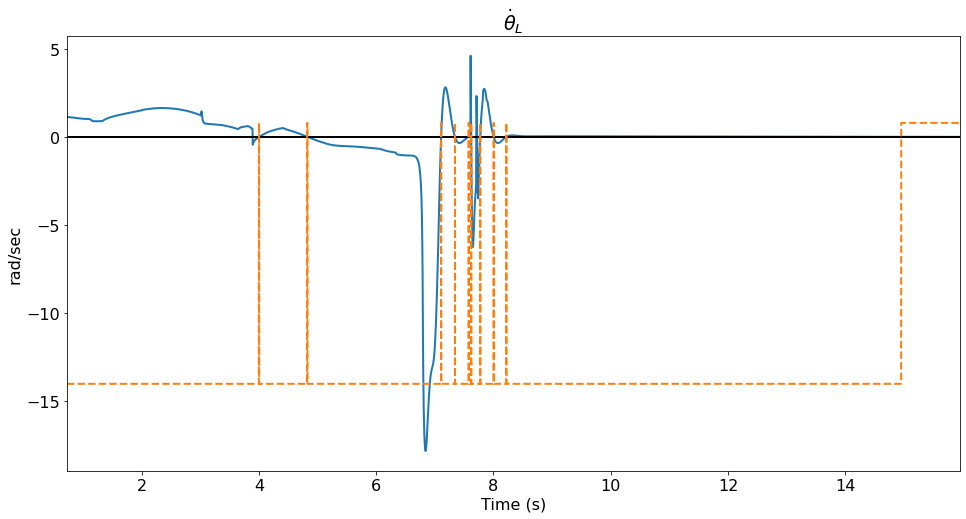

In [160]:
d_theta_L_mag_cutoff = 0.005 # TODO: get this programattically
within_thresh = np.abs(d_theta_L) < d_theta_L_mag_cutoff

start_idx_ = first_contact_idx

plt.figure()
plt.plot(l_times[start_idx_:], d_theta_L[start_idx_:], linewidth=2)
plt.axhline(0, color='k', linewidth=2)
plt.title(r"$\dot\theta_L$")
plt.xlabel("Time (s)")
plt.ylabel("rad/sec")

ylims = plt.ylim()
ylim_range = ylims[1] - ylims[0]
no_val = ylims[0]+ylim_range*0.2
yes_val = ylims[0]+ylim_range*0.8
vals_to_plot = np.ones_like(l_times)*no_val
vals_to_plot[within_thresh == 1] = yes_val
plt.plot(l_times[start_idx_:], vals_to_plot[start_idx_:], linestyle='--', linewidth=2)
plt.show()

## General inspection
Any other plots used for just looking at values in the sim, not directly related to the controller.

### Meta controller plots

In [161]:
if (ctrl_paradigm == plant.simulation.CtrlParadigm.INVERSE_DYNAMICS):
    plt.figure()
    plt.plot(l_times, debug_success)
    plt.ylim(-0.5,1.5)
    plt.show()

#### Contact ctrl?

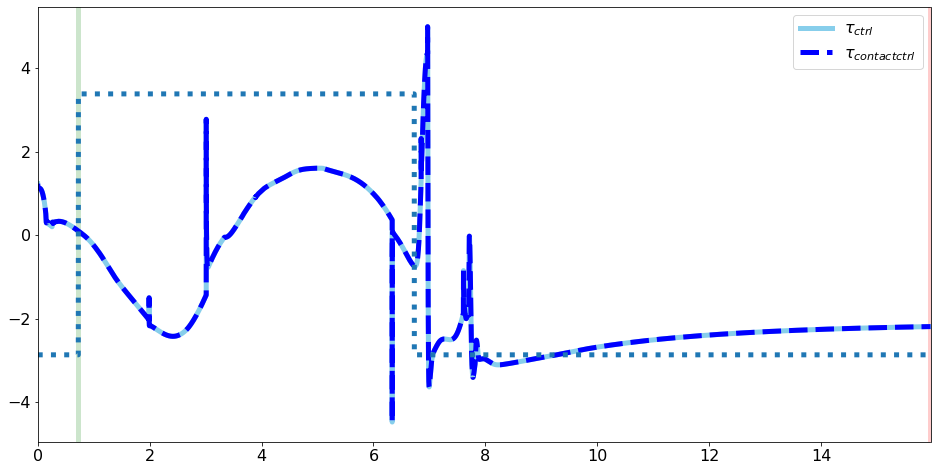

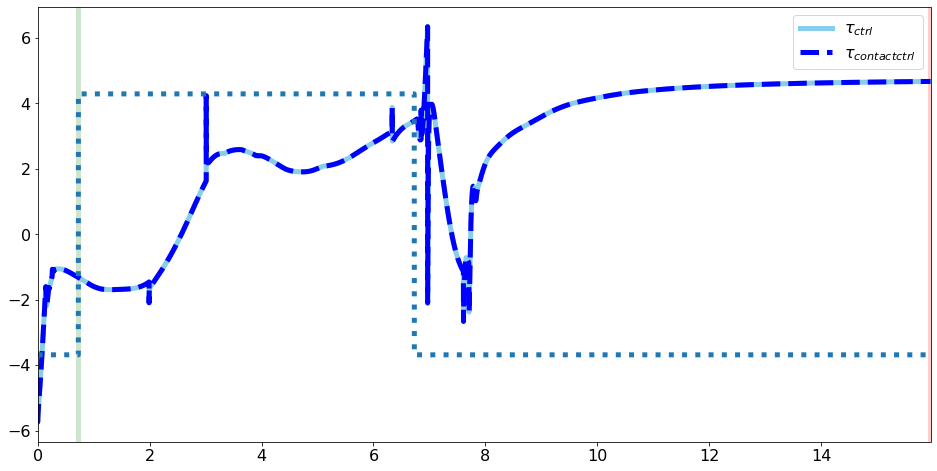

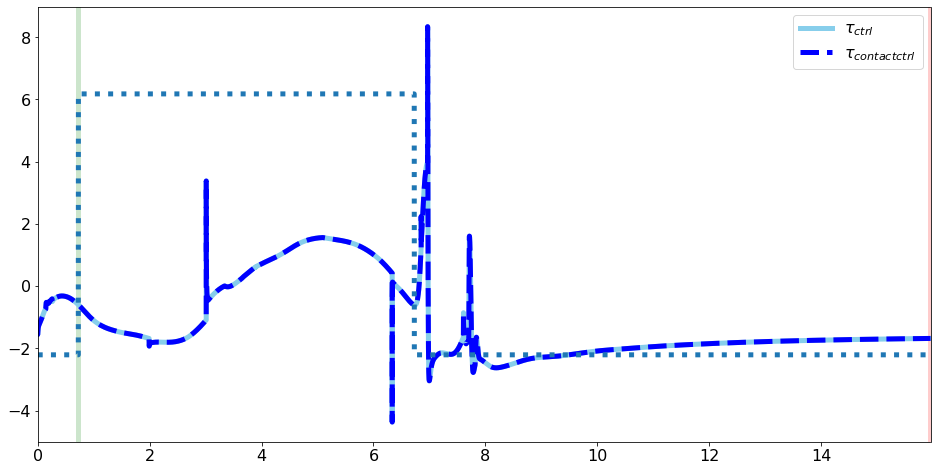

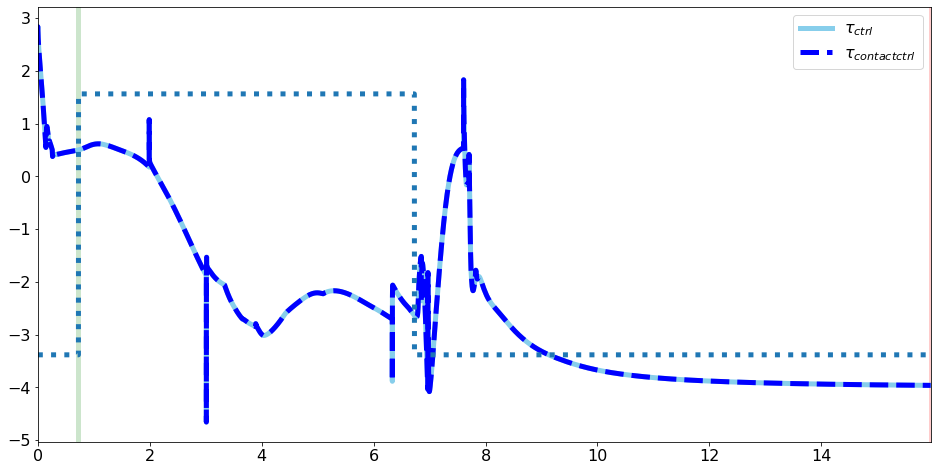

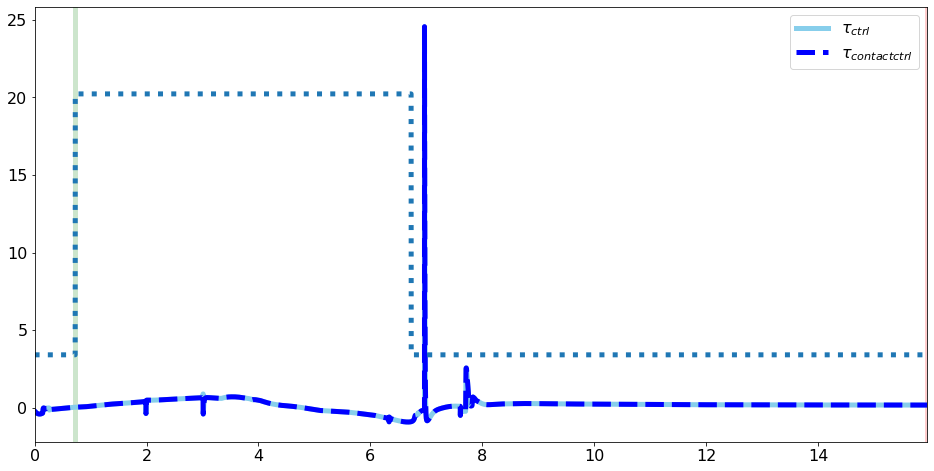

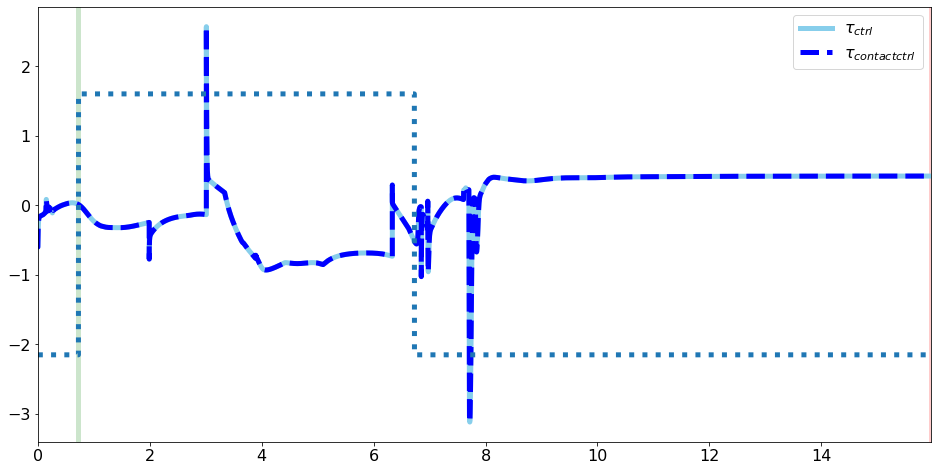

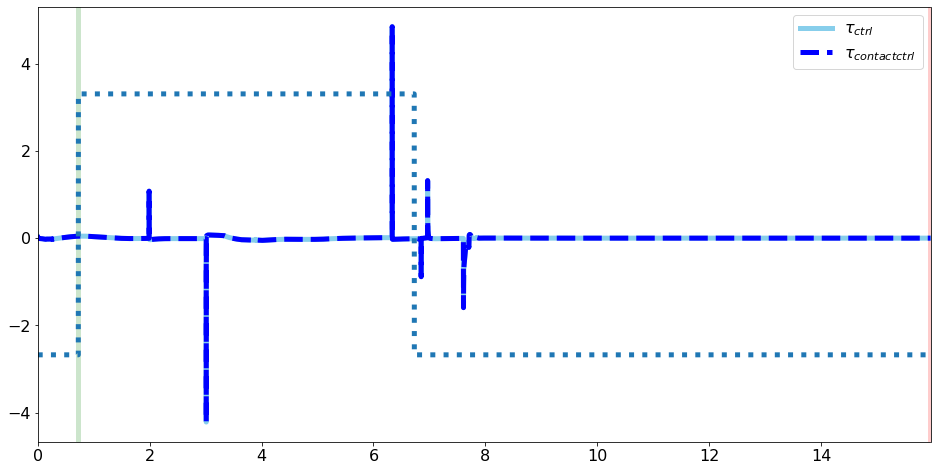

In [162]:
for i in range(nq):
    plt.figure()
    plt.plot(l_times, tau_ctrl[:,i], color="skyblue", label=r"$\tau_{ctrl}$")
    plt.plot(l_times, tau_contact_ctrl[:,i], color="b", linestyle='--', label=r"$\tau_{contact ctrl}$")
    
    ylims = plt.ylim()
    ylim_range = ylims[1] - ylims[0]
    no_val = ylims[0]+ylim_range*0.2
    yes_val = ylims[0]+ylim_range*0.8
    contacts_to_plot = np.ones_like(l_times)*no_val
    contacts_to_plot[in_contact == 1] = yes_val
    plt.plot(l_times, contacts_to_plot, linestyle=':')
    
    plt.axvline(t_start, color='g', alpha=0.2, zorder=0)
    plt.axvline(t_end, color='r', zorder=0, alpha=0.2)
    
    plt.legend()
plt.show()

### `in_contact` plots

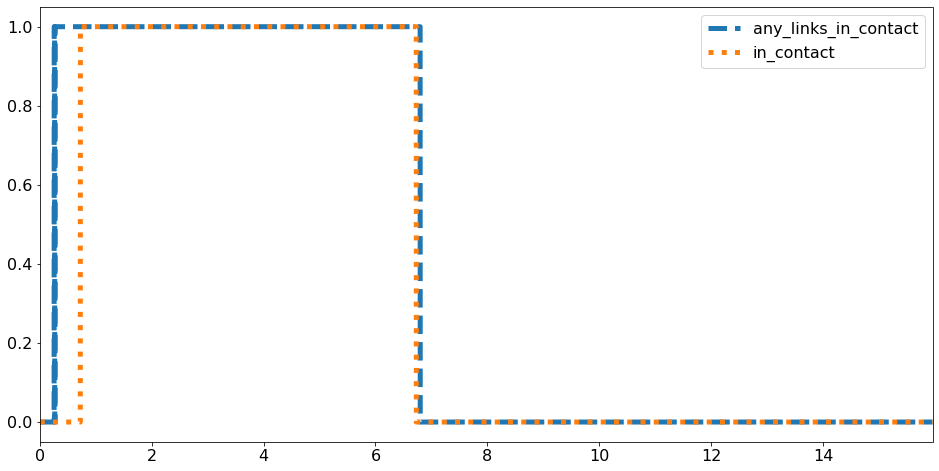

In [163]:
plt.figure()
plt.plot(l_times, any_links_in_contact, '--', label="any_links_in_contact")
plt.plot(l_times, in_contact, ':', label="in_contact")
plt.legend()
plt.show()

### Friction estimates

#### Norm

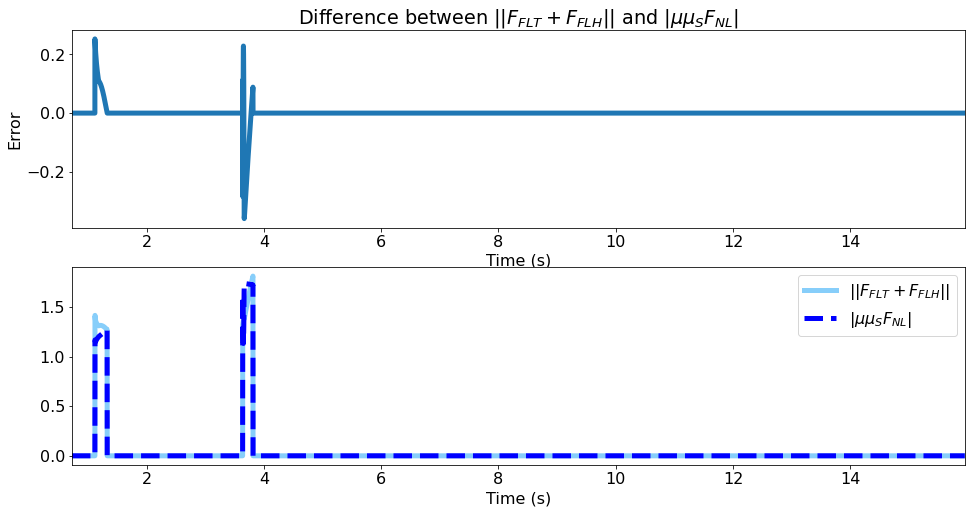

In [164]:
lhs = np.linalg.norm(np.expand_dims(F_FLH, [1,2])*H_hat + np.expand_dims(F_FLT, [1,2])*T_hat, axis=1)
lhs_label = r"$||F_{FLT} + F_{FLH}||$"

rhs = np.abs(np.expand_dims(mu*mu_S*F_NL, 1))
rhs_label = "$|\mu\mu_{S}F_{NL}|$"

plot_eq(lhs, lhs_label, rhs, rhs_label)
plt.show()

In [165]:
F_FLT

array([-0., -0., -0., ..., -0., -0., -0.])

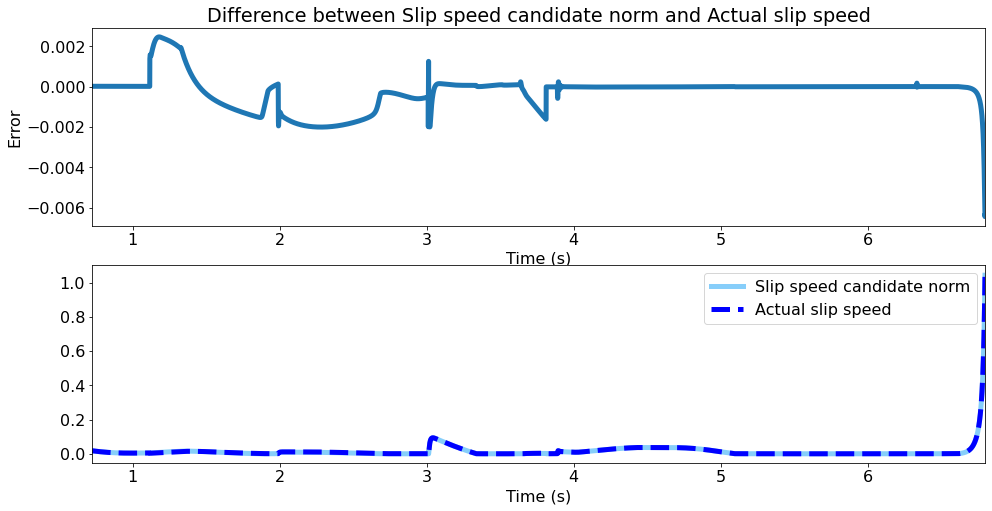

In [166]:
lhs = s_S
lhs_label = r"Slip speed candidate norm"

rhs = slip_speed
rhs_label = "Actual slip speed"

plot_eq(lhs, lhs_label, rhs, rhs_label)
plt.show()

#### Direction

In [167]:
F_hat = np.expand_dims(F_FLT, [1,2])*T_hat + np.expand_dims(F_FLH, [1,2])*H_hat
F_hat = F_hat/np.expand_dims(np.linalg.norm(F_hat, axis=1), 2)

<ipython-input-167-119124d8a821>:2: RuntimeWarning: invalid value encountered in true_divide
  F_hat = F_hat/np.expand_dims(np.linalg.norm(F_hat, axis=1), 2)


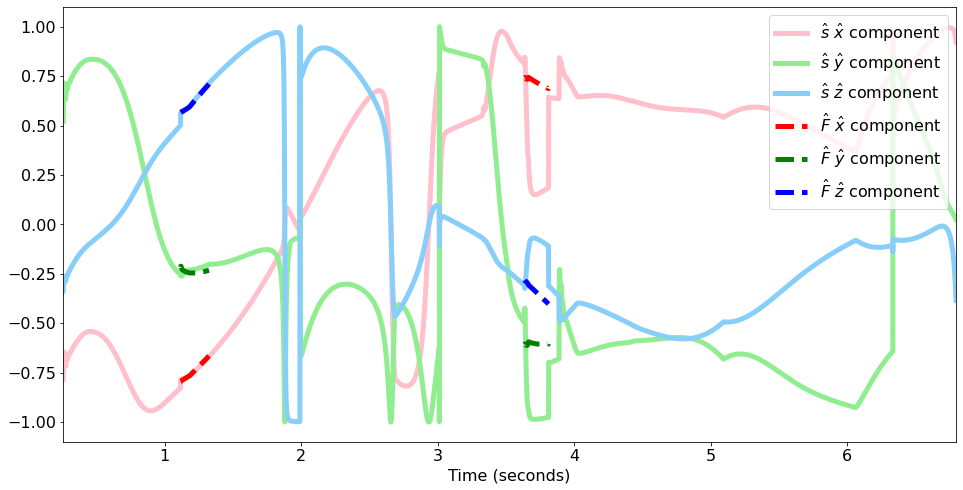

In [168]:
sig1 = s_hat
sig1_label = r"$\hat s$"

sig2 = F_hat
sig2_label = r"$\hat F$"
plot_vec(sig1, sig1_label, sig2, sig2_label, start_time=t_start_of_last_contact)

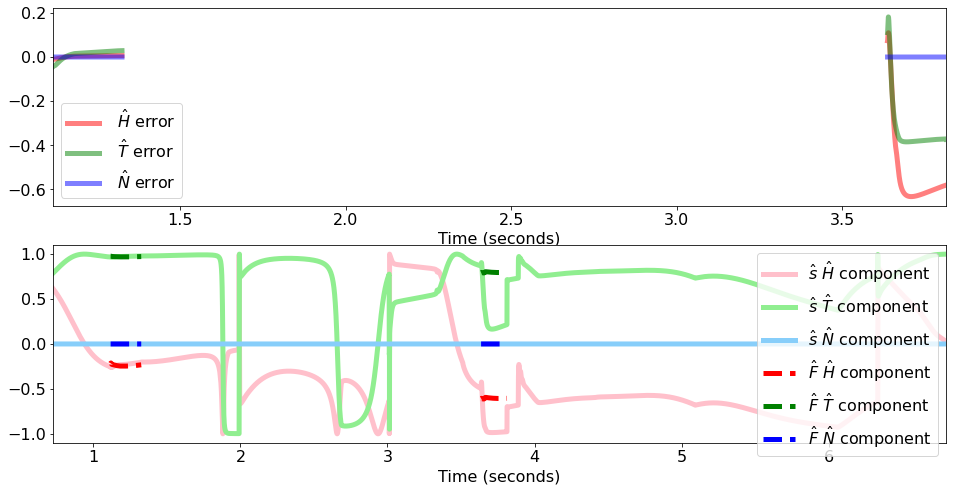

In [169]:
sig1 = s_hat
sig1_label = r"$\hat s$"

sig2 = F_hat
sig2_label = r"$\hat F$"
plot_vec_HTN(sig1, sig1_label, sig2, sig2_label, plot_error=True)#, start_time=t_start_of_last_contact)

#### Comparison against actual values

In [170]:
F_mag = mu_S*F_NL*mu

In [171]:
F_F_est = s_hat*np.expand_dims(np.vstack((F_mag,F_mag,F_mag)).T, 2)

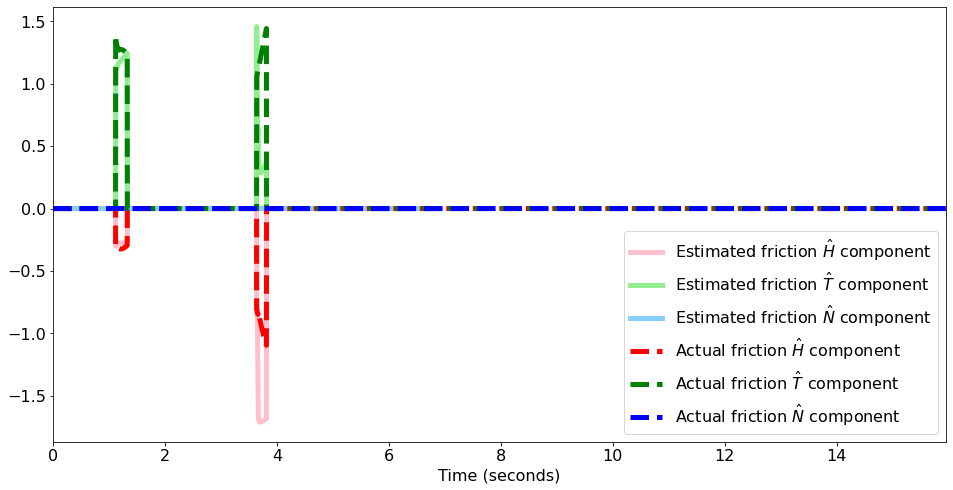

In [172]:
sig1 = F_F_est
sig1_label = r"Estimated friction"

sig2 = F_contact_L - N_hat_proj_mat@F_contact_L
sig2_label = r"Actual friction"
plot_vec_HTN(sig1, sig1_label, sig2, sig2_label, start_time=t_start_of_last_contact)

### Friction measurements

#### Friction cone
Whether or not we bump up against the friction cone.

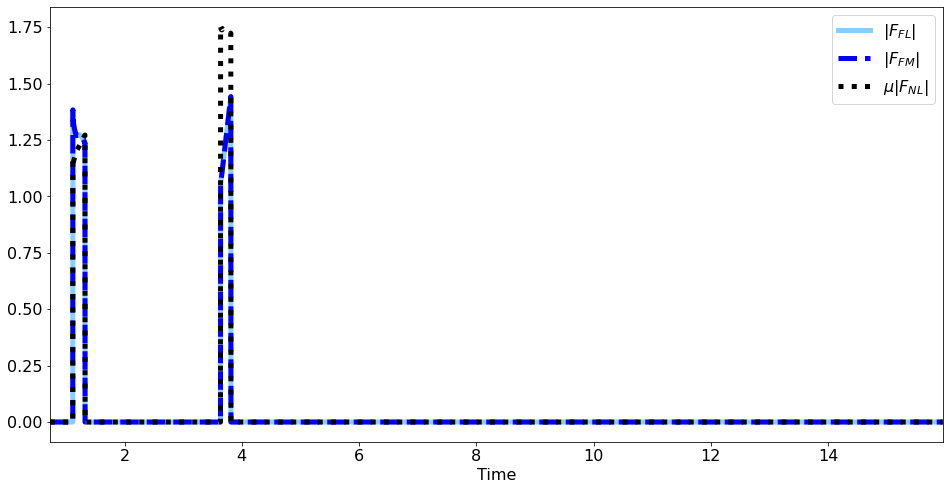

In [173]:
lw=5
plt.figure(figsize=(16,8))
plt.plot(l_times[idx_start:idx_end],
         abs(F_FLT[idx_start:idx_end]), label=r"$\left|F_{FL}\right|$", linewidth=lw, color='lightskyblue', zorder=0)
plt.plot(l_times[idx_start:idx_end],
         abs(F_FMT[idx_start:idx_end]), label=r"$\left|F_{FM}\right|$", linewidth=lw, color='b', linestyle='--', zorder=1)
plt.plot(l_times[idx_start:idx_end],
         abs(F_NL[idx_start:idx_end])*mu, label=r"$\mu\left|F_{NL}\right|$", linewidth=lw, color='k', linestyle=':')

plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.xlabel("Time")
plt.show()

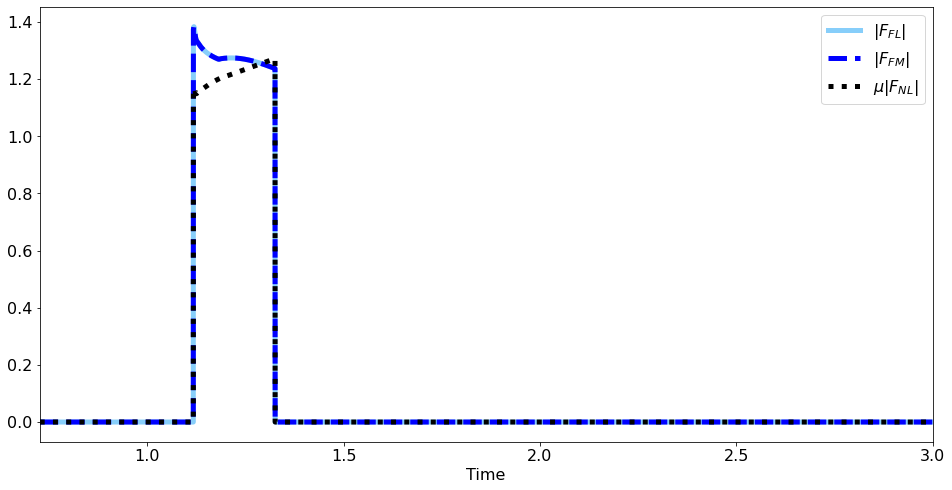

In [174]:
lw=5
idx_end_ = idx_end
idx_end_ = np.argmax(l_times > 3)
plt.figure(figsize=(16,8))
plt.plot(l_times[idx_start:idx_end_],
         abs(F_FLT[idx_start:idx_end_]), label=r"$\left|F_{FL}\right|$", linewidth=lw, color='lightskyblue', zorder=0)
plt.plot(l_times[idx_start:idx_end_],
         abs(F_FMT[idx_start:idx_end_]), label=r"$\left|F_{FM}\right|$", linewidth=lw, color='b', linestyle='--', zorder=1)
plt.plot(l_times[idx_start:idx_end_],
         abs(F_NL[idx_start:idx_end_])*mu, label=r"$\mu\left|F_{NL}\right|$", linewidth=lw, color='k', linestyle=':')

plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.xlabel("Time")
plt.show()

#### Slip speed

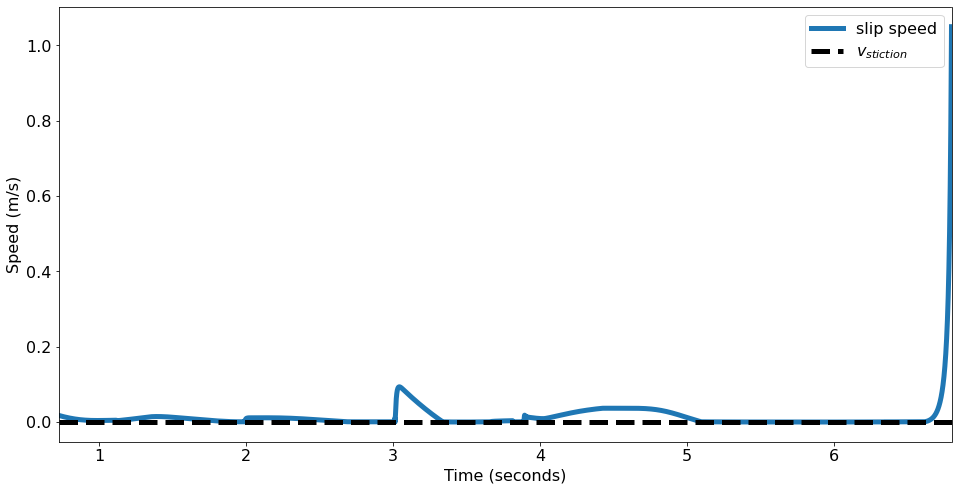

In [175]:
lw=5
plt.figure(figsize=(16, 8))
plt.plot(l_times[idx_start:idx_end], slip_speed[idx_start:idx_end], label="slip speed", linewidth=5)
plt.axhline(constants.v_stiction, linestyle="--", color="k", label="$v_{stiction}$", linewidth=5)
plt.xlabel("Time (seconds)")
plt.ylabel("Speed (m/s)")
# plt.ylim(0, 2*constants.v_stiction)
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.show()

### Joint torques

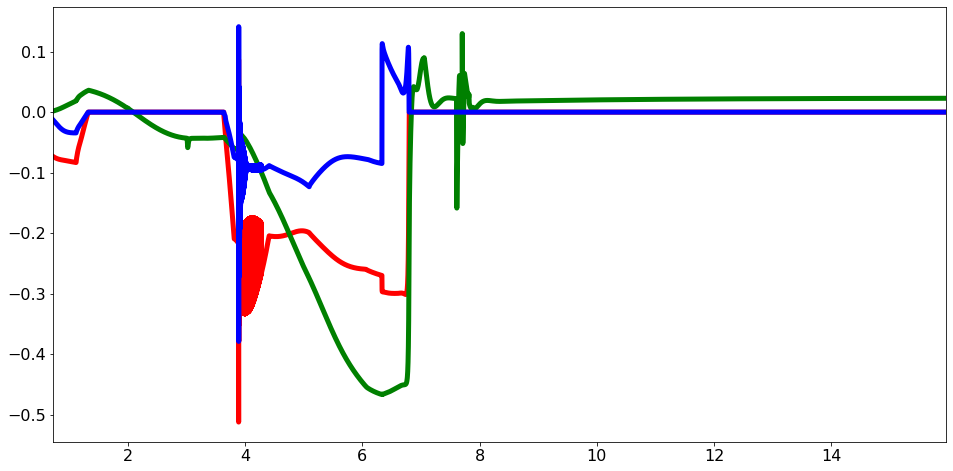

In [176]:
plt.figure(figsize=(16,8))
plt.plot(l_times[idx_start:idx_end], 
         joint_torque_in_compliance_frame[0,idx_start:idx_end], linewidth=5, color='r', label=r"\tau_x")
plt.plot(l_times[idx_start:idx_end], 
         joint_torque_in_compliance_frame[1,idx_start:idx_end], linewidth=5, color='g', label=r"\tau_y")
plt.plot(l_times[idx_start:idx_end], 
         joint_torque_in_compliance_frame[2,idx_start:idx_end], linewidth=5, color='b', label=r"\tau_z")
plt.autoscale(enable=True, axis='x', tight=True)

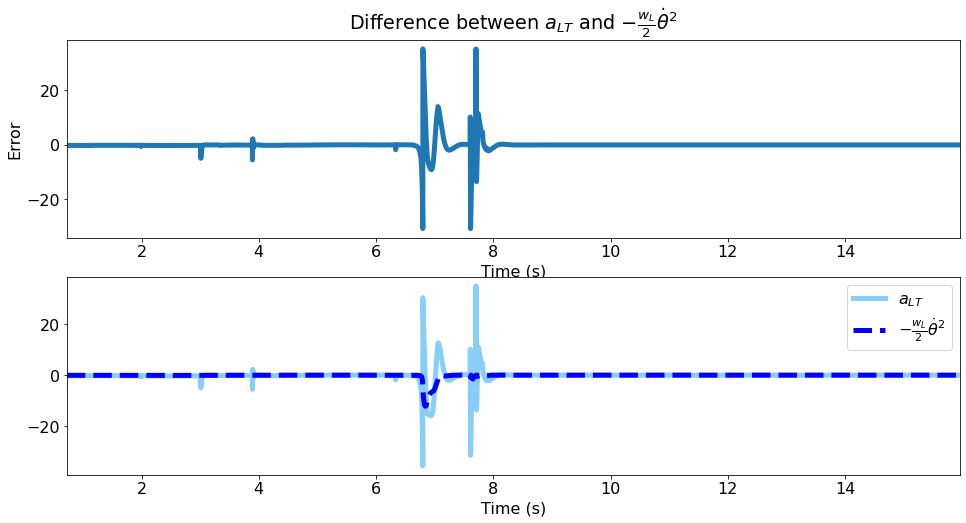

In [177]:
lhs = a_LT
lhs_label = r"$a_{LT}$"
rhs = (-w_L/2)*d_theta_L**2
rhs_label = r"$-\frac{w_L}{2}\dot\theta^2$"
plot_eq(lhs, lhs_label, rhs, rhs_label)

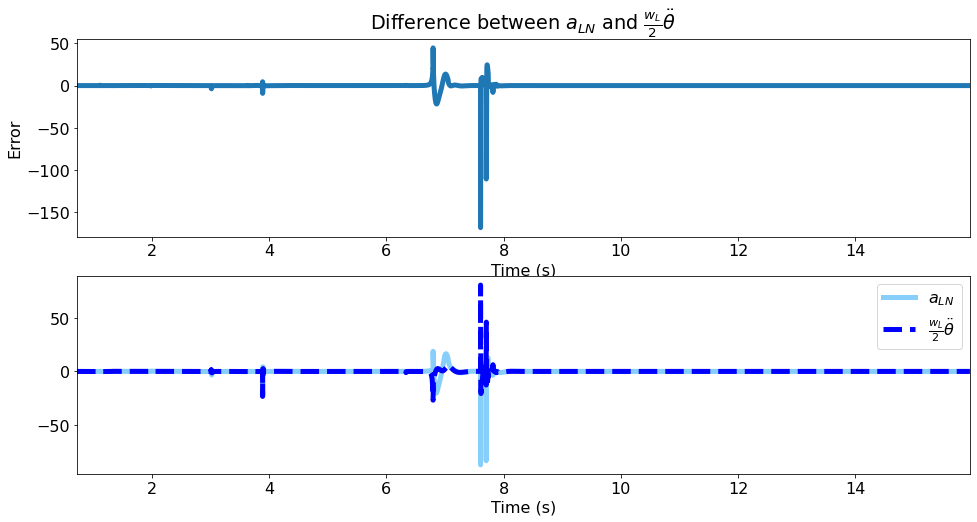

In [178]:
lhs = a_LN
lhs_label = r"$a_{LN}$"
rhs = (w_L/2)*dd_theta_L
rhs_label = r"$\frac{w_L}{2}\ddot\theta$"
plot_eq(lhs, lhs_label, rhs, rhs_label)

### Contact normal

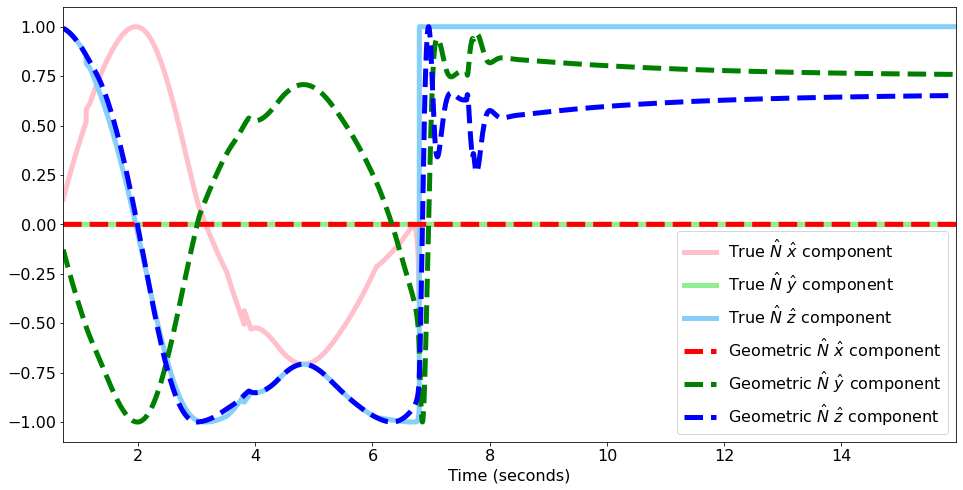

In [179]:
plot_vec(N_hat, r"True $\hat N$", N_hat_geo, r"Geometric $\hat N$")

### Kinematic singularities
How close we are to kinematic singularities, measured in various ways.

#### Singular value decomposition

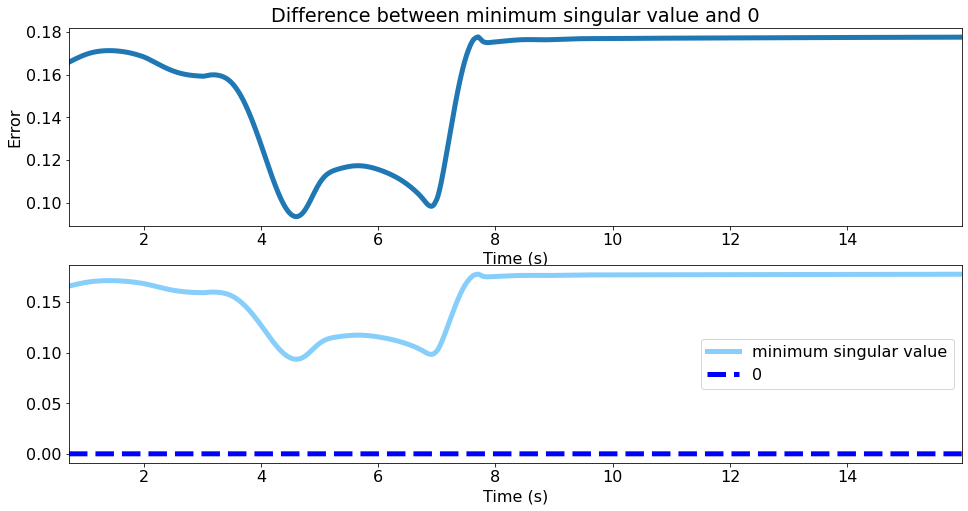

In [180]:
min_svds = np.min(np.linalg.svd(J)[1], axis=1)
plot_eq(min_svds, "minimum singular value", 0, "0")

#### Volume of manipulability ellipsoid

Page 195 of Modern Robotics says that the volume of the manipulability ellipsoid is proportional to $\sqrt{\det\left(JJ^T\right)}$.

In [181]:
V = np.linalg.det(np.matmul(J, J.transpose([0, 2, 1])))

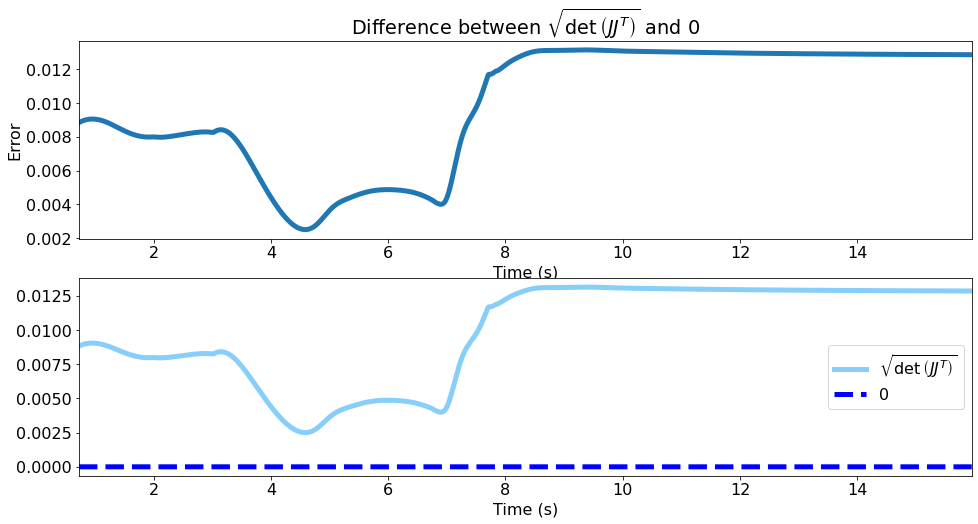

In [182]:
plot_eq(V, r"$\sqrt{\det\left(JJ^T\right)}$", 0, "0")

#### Mass matrix deteriminant

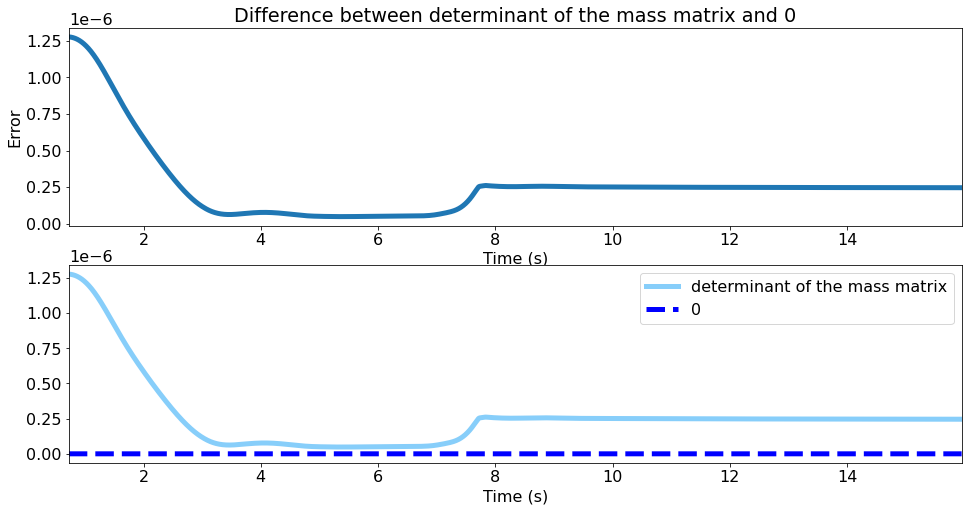

In [183]:
plot_eq(np.linalg.det(M), "determinant of the mass matrix", 0, "0")

### Drag plots

This is a sanity check to see how much force we're neglecting by ignoring drag. The colored lines are the drag forces at each link, and the dashed black line is the force due to gravity for scale.

Note that the formula for drag force is $\rho v^2 C_d A_{paper}$.

$C_d$ comes from [this site](https://www.engineersedge.com/fluid_flow/rectangular_flat_plate_drag_14036.htm), which says it depends on $L/d$. For 20 links, $L/d\approx15$. Rounding this down to 10, we get $C_d=1.22$.

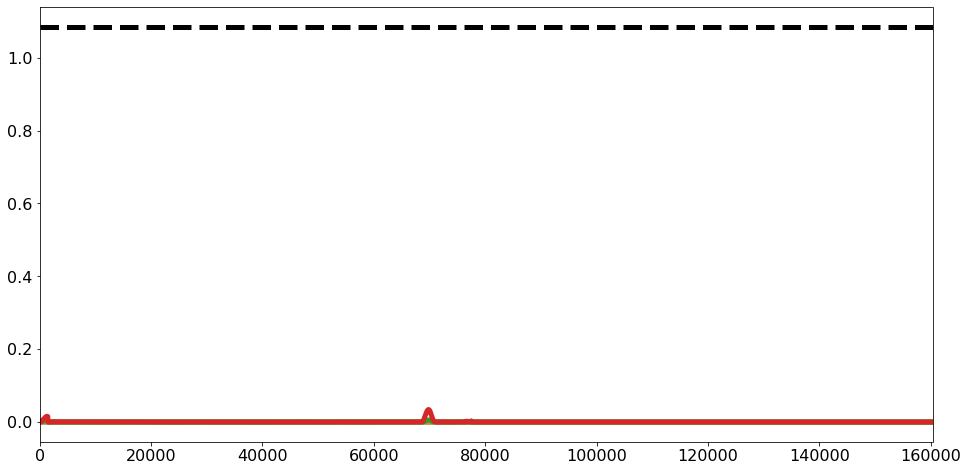

In [184]:
# Plot drag forces
vel_traces = []
for b in sim.paper.link_idxs:
    rho = 1.225
    C_d = sim.paper.w_L*sim.paper.x_dim
    vel_sqr = log.data()[sim.log_wrapper.entries_per_body*b+7]**2+log.data()[sim.log_wrapper.entries_per_body*b+8]**2
    f = 0.5*rho*C_d*vel_sqr
    plt.plot(f)

plt.axhline(sim.paper.m_L*9.81, color='black', linestyle='--')
plt.show()

# Debugging sandbox
Plots that I don't intend to keep long-term, but are useful to have while debugging my current problem.

## Simplified normal acceleration analysis
### Link vs. manipulator normal acceleration

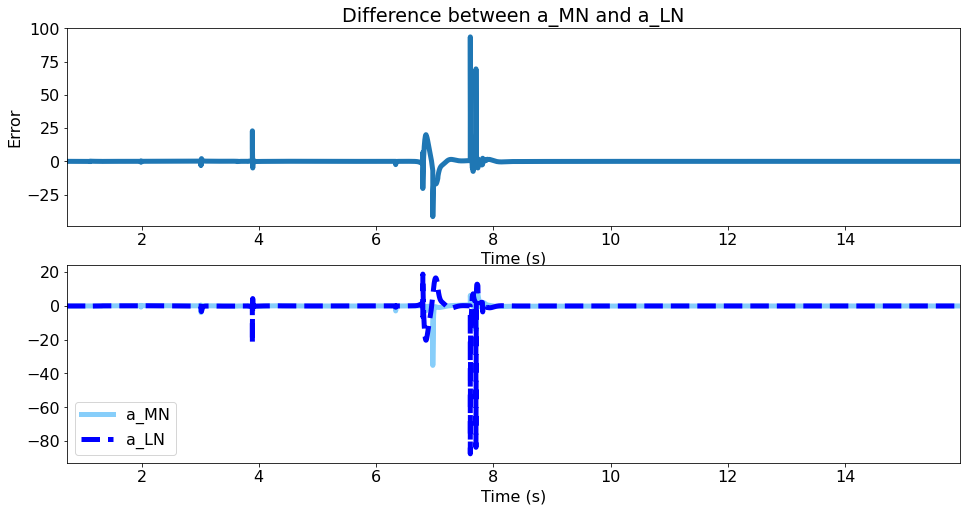

In [185]:
plot_eq(a_MN, "a_MN", a_LN, "a_LN")

This confirms we can analyze the two bodies as moving together.

### Adding together N hat equations
Because they're moving together, everything should cancel. First, just adding back the sphere equations:

In [186]:
# TODO

### Generating new figure of merit

In [187]:
overall_thetas = np.arctan2((p_L - p_W_FJ)[:,2], -(p_L - p_W_FJ)[:,1-hinge_rotation_axis])
idxs = overall_thetas < 0
# overall_thetas[idxs] += 2*np.pi

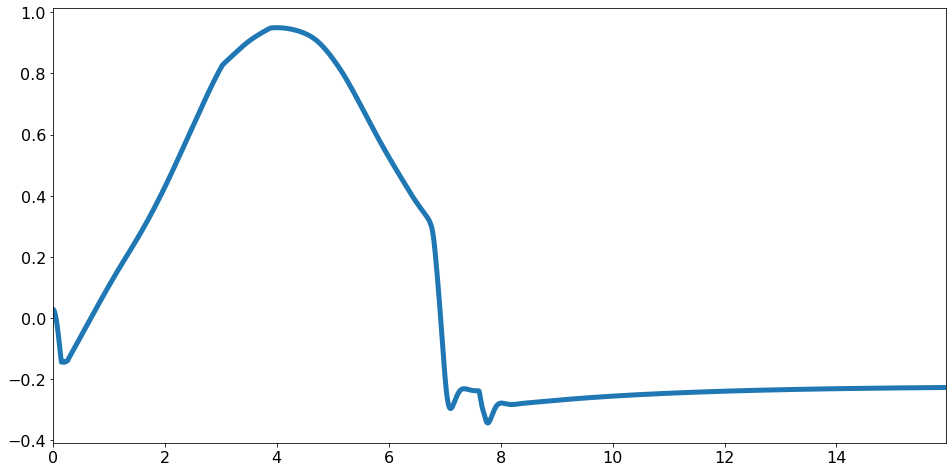

In [188]:
plt.plot(l_times, overall_thetas/np.pi)
# plt.axhline(0)

In [189]:
num_jnts = sim.paper.num_links.value - 1
F_ONs = []
plt.figure()
for i in range(num_jnts):
    idx = sim.log_wrapper.joint_entry_start_idx + 6*i
    joint_force_in_compliance_frame = log.data()[idx:idx+3]
    F_ONs.append(joint_force_in_compliance_frame[2,:])

<Figure size 1152x576 with 0 Axes>

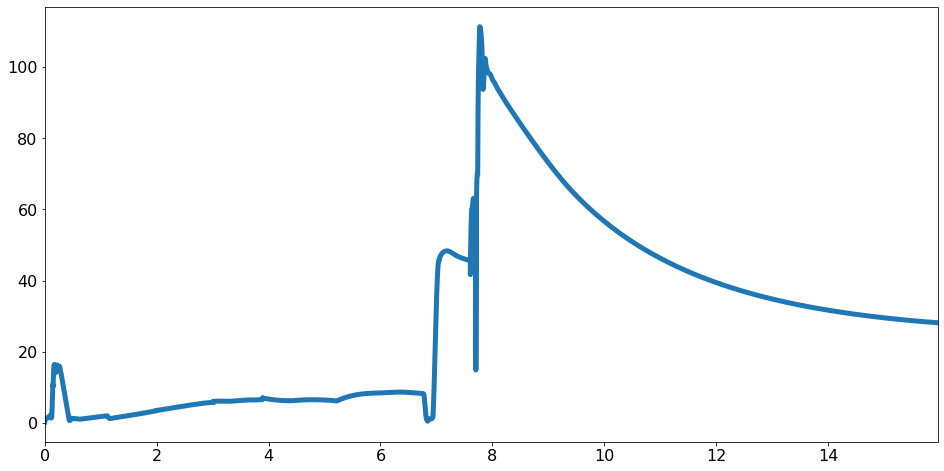

In [190]:
plt.plot(l_times, np.max(np.abs(F_ONs), axis=0))

# Other

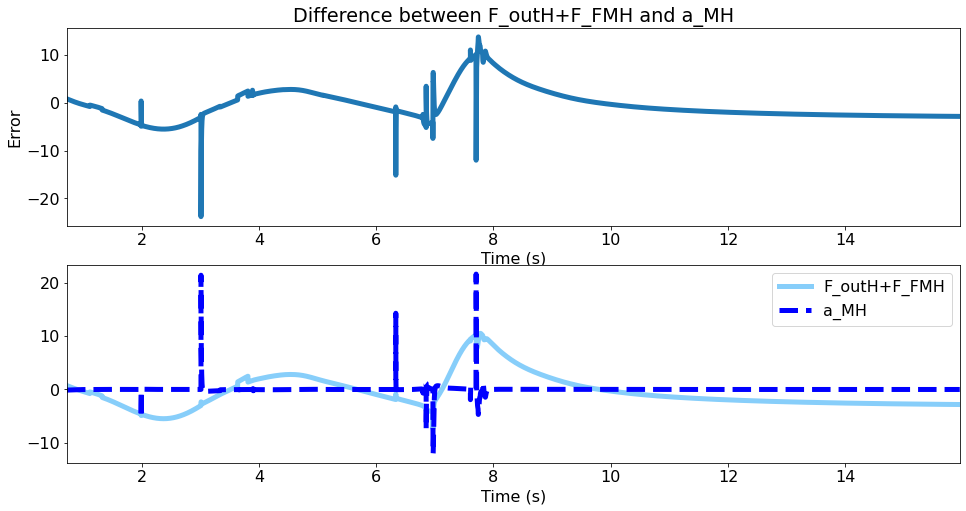

In [191]:
plot_eq(F_outH+F_FMH, "F_outH+F_FMH", a_MH, "a_MH")

In [192]:
M_inv = np.linalg.inv(M)

In [193]:
np.linalg.inv(M).shape

(160296, 7, 7)

In [194]:
hinge_rotation_axis

1

In [195]:
J.shape

(160296, 6, 7)

In [196]:
Jdot_qdot.shape

(160296, 6, 1)

In [197]:
Cv.shape

(160296, 7, 1)

In [198]:
T(J).shape

(160296, 7, 6)

In [199]:
Mx = np.matmul(np.matmul(J, M_inv), T(J))

In [200]:
Mx.shape

(160296, 6, 6)

In [201]:
other_term = -np.matmul(np.matmul(J, M_inv), Cv)

In [202]:
total_force = F_outH+F_FMH
lhs = np.matmul(Mx, total_force) -np.matmul(np.matmul(J, M_inv), Cv) + Jdot_qdot
plot_eq(lhs, "F_outH+F_FMH", a_MH, "a_MH")

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 160296 is different from 6)

In [ ]:
np.matmul(Mx, total_force).shape

In [ ]:
Mx.shape

In [ ]:
total_force = 

In [ ]:
h_hat

In [ ]:
fig, axs = plt.subplots(1, 6, constrained_layout=True,sharex=True, sharey=True)
for j in range(6):
    axs[j].plot(l_times, Mx[:,4,j])

In [ ]:
axs

# Comparison with data

In [ ]:
import warnings
from pydrake.all import Quaternion, RollPitchYaw


In [ ]:
def process_poses(poses):
    xs = []
    ys = []
    zs = []
    theta_xs = []
    theta_ys = []
    theta_zs = []
    q_ws = []
    q_xs = []
    q_ys = []
    q_zs = []
    
    for pose in poses:
        xs.append(pose["position"][0])
        ys.append(pose["position"][1])
        zs.append(pose["position"][2])

        quat_vec = np.array([
            pose['orientation'].w,
            pose['orientation'].x,
            pose['orientation'].y,
            pose['orientation'].z
        ])

        q_ws.append(quat_vec[0])
        q_xs.append(quat_vec[1])
        q_ys.append(quat_vec[2])
        q_zs.append(quat_vec[3])
        
        quat = Quaternion(
            w=pose['orientation'].w,
            x=pose['orientation'].x,
            y=pose['orientation'].y,
            z=pose['orientation'].z,
        )
        rpy = RollPitchYaw(quat).vector()
        theta_xs.append(rpy[0])
        theta_ys.append(rpy[1])
        theta_zs.append(rpy[2])
    return {
        'x': np.array(xs),
        'y': np.array(ys),
        'z': np.array(zs),
        'theta_x': np.array(theta_xs),
        'theta_y': np.array(theta_ys),
        'theta_z': np.array(theta_zs),
        'q_w': np.array(q_ws), 
        'q_x': np.array(q_xs),
        'q_y': np.array(q_ys),
        'q_z': np.array(q_zs),
    }

In [ ]:
def process_poses_log(poses):
    xs = poses[()]['x']
    ys = poses[()]['y']
    zs = poses[()]['z']
    theta_xs = []
    theta_ys = []
    theta_zs = []
    q_ws = []
    q_xs = []
    q_ys = []
    q_zs = []
    
    for i in range(len(poses[()]['x'])):
        quat = Quaternion(
            w=poses[()]['q_w'][i],
            x=poses[()]['q_x'][i],
            y=poses[()]['q_y'][i],
            z=poses[()]['q_z'][i],
        )
        rpy = RollPitchYaw(quat).vector()
        theta_xs.append(rpy[0])
        theta_ys.append(rpy[1])
        theta_zs.append(rpy[2])

        q_ws.append(poses[()]['q_w'][i])
        q_xs.append(poses[()]['q_x'][i])
        q_ys.append(poses[()]['q_y'][i])
        q_zs.append(poses[()]['q_z'][i])
    return {
        'x': xs,
        'y': ys,
        'z': zs,
        'theta_x': np.array(theta_xs),
        'theta_y': np.array(theta_ys),
        'theta_z': np.array(theta_zs),
        'q_w': np.array(q_ws), 
        'q_x': np.array(q_xs),
        'q_y': np.array(q_ys),
        'q_z': np.array(q_zs),
    }

In [ ]:
def load_data(run_num, gain, prefix="q_ee"):
    pref_path = "/Users/dani/Documents/lis/notes/testing/2022-04-29/"
    # Load npz
    log_npz = np.load(pref_path + "test1/runs/run{}/{}_log.npz".format(run_num, prefix), allow_pickle=True)
    
    # Handle time
    dt = log_npz["dt"][()]
    end_time = log_npz["end_time"][()]
    act_t = log_npz['t_log'] - log_npz['t_log'][0]
    des_t = np.arange(0, end_time, dt)
    
    print("dt:", dt)
    print("end_time:", end_time)

    # Pull out trajectories
    poses_fixed__npz = np.load(pref_path + "test1/x0s/x0s.npz".format(end_time, dt), allow_pickle=True)
    position_traj__npz = np.load(pref_path + "test1/qs/qs.npz".format(end_time, dt), allow_pickle=True)
    
    # Suppress numba warnings and prcess dicts
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        dict_des_ee_poses = poses_fixed__npz["poses"]
        if 'ee_log' in log_npz.files:
            log_act_ee_poses = log_npz['ee_log']

        des_qs = position_traj__npz['qs']
        if 'q_log' in log_npz.files:
            dict_act_qs = log_npz['q_log']

    if 'q_log' in log_npz.files:
        act_qs = process_q_dict(dict_act_qs)
    else:
        act_qs = np.zeros((len(act_t), 7))*np.nan
    if 'ee_log' in log_npz.files:
        act_ee_poses = process_poses_log(log_act_ee_poses)
    else:
        act_ee_poses = {
            'x': np.zeros_like(act_t)*np.nan,
            'y': np.zeros_like(act_t)*np.nan,
            'z': np.zeros_like(act_t)*np.nan,
            'theta_x': np.zeros_like(act_t)*np.nan,
            'theta_y': np.zeros_like(act_t)*np.nan,
            'theta_z': np.zeros_like(act_t)*np.nan
        }

    des_ee_poses = process_poses(dict_des_ee_poses)

    out_dict = {
        "q": {
            "act": act_qs,
            "des": des_qs,
        },
        "ee_pose": {
            "act": act_ee_poses,
            "des": des_ee_poses
        },
        "t": {
            "act": act_t,
            "des": des_t
        },
        "dt": dt,
        "end_time": end_time,
        "gain": gain
    }
    return out_dict

In [ ]:
run_1_data = load_data(1, 40, prefix="data")

In [ ]:
run_data = run_1_data

In [ ]:
plt.figure()
labels = ["Desired", "Actual"]
keys = ["des", "act"]
cmaps = ["cool", "hot"]

for label, key, cmap in zip(labels, keys, cmaps):
    plt.scatter(
        run_data['ee_pose'][key]['x'],
        run_data['ee_pose'][key]['z'],
        c=run_data['t'][key],
        label=label, cmap=cmap)
plt.plot(p_M[:,0].flatten(), p_M[:,2].flatten())
plt.plot(x0s[:,3], x0s[:,5])
    

plt.xlabel("$x$ position (m)")
plt.ylabel("$z$ position (m)")
plt.gca().set_aspect("equal")
plt.legend()
plt.show()

In [ ]:
run_data['q']

In [ ]:
p_L[:,0].shape

In [ ]:
run_data['q']['des'][0]

In [ ]:
test_file_ = np.load("qs_2_links.npz")["qs"]
test_file_[0]

In [ ]:
x0s = np.array(sim.fold_ctrl.debug['x0'])

In [ ]:
x0s.shape

In [ ]:
plt.figure()

plt.plot(run_data['ee_pose']["act"]['x'], run_data['ee_pose']["act"]['z'])
plt.plot(p_M[:,0].flatten(), p_M[:,2].flatten())
plt.plot(x0s[:,3], x0s[:,5])
    

plt.xlabel("$x$ position (m)")
plt.ylabel("$z$ position (m)")
plt.gca().set_aspect("equal")
plt.legend()
plt.show()